In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.8355]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8888]], requires_grad=True)
alpha:  tensor([0.3800])
gt ols coef:  [[0.83543706]]
gt ols intercept:  [-0.9875288]
trunc ols coef:  [[0.45437628]]
trunc ols intercept:  [0.72016466]


Text(0, 0.5, 'y')

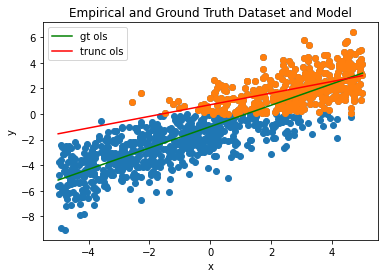

In [30]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))

    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [31]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9969)
beta:  tensor(4.9969)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.2282])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

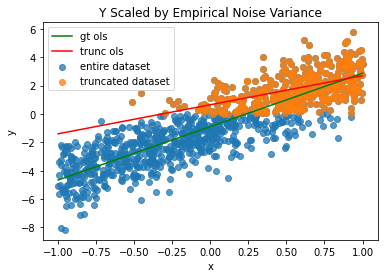

In [32]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.6141])
reg noise var:  tensor([1.0073])


Text(0, 0.5, 'y')

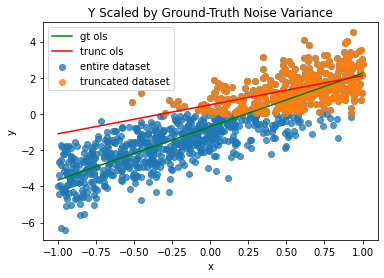

In [33]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [34]:
known_emp_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var))

Iteration: 0.0 | Score: [-0.02536662295460701]
Iteration: 1.0 | Score: [-0.11982166767120361]
Iteration: 2.0 | Score: [-0.13763217628002167]
Iteration: 3.0 | Score: [-0.132592111825943]
Iteration: 4.0 | Score: [-0.19211918115615845]
Iteration: 5.0 | Score: [-0.21674875915050507]
Iteration: 6.0 | Score: [-0.12453445047140121]
Iteration: 7.0 | Score: [-0.16877827048301697]
Iteration: 8.0 | Score: [-0.15939711034297943]
Iteration: 9.0 | Score: [-0.14601503312587738]
Iteration: 10.0 | Score: [-0.1455003172159195]


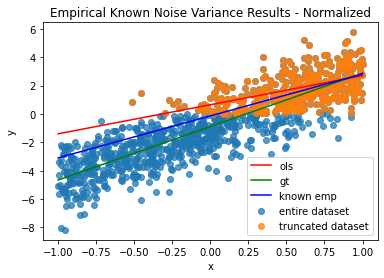

Text(0, 0.5, 'y')

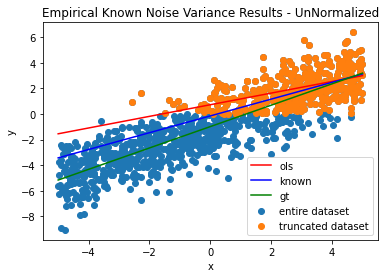

In [35]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [36]:
known_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=10, bs=100, n=100, tol=1e-2, steps=1500)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var)

Iteration: 0.0 | Score: [0.240791916847229]
Iteration: 1.0 | Score: [0.10804712772369385]
Iteration: 2.0 | Score: [0.03135845810174942]
Iteration: 3.0 | Score: [0.019305363297462463]
Iteration: 4.0 | Score: [-0.001671120524406433]


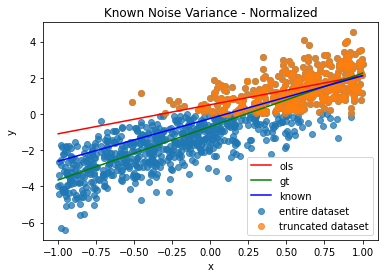

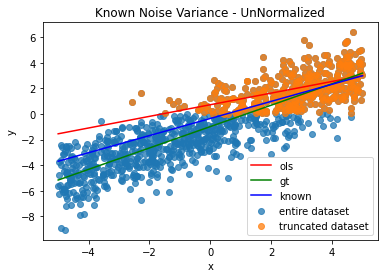

In [37]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [40]:
unknown_trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-1, val=10, steps=2000)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
with ch.no_grad():
    unknown_weight_unnorm = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta)

    if args.bias: 
        unknown_bias_unnorm = ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var))
    

Iteration: 0.0 | Score: [-0.12165714800357819, 0.21924637258052826]
Iteration: 1.0 | Score: [-0.21214184165000916, 0.3598797619342804]
Iteration: 2.0 | Score: [-0.4744935631752014, 0.8935776948928833]
Iteration: 3.0 | Score: [-0.04646763205528259, -0.1492982804775238]
Iteration: 4.0 | Score: [-0.044621843844652176, -0.1630980223417282]
Iteration: 5.0 | Score: [-0.3639185428619385, 0.6632825136184692]
Iteration: 6.0 | Score: [-0.4053798019886017, 0.721343994140625]
Iteration: 7.0 | Score: [-0.3445623815059662, 0.590284526348114]
Iteration: 8.0 | Score: [0.07597371190786362, -0.5455248355865479]
Iteration: 9.0 | Score: [-0.20857703685760498, 0.2699781060218811]
Iteration: 10.0 | Score: [-0.27680179476737976, 0.4481775462627411]
Iteration: 11.0 | Score: [-0.0911467894911766, -0.055534347891807556]


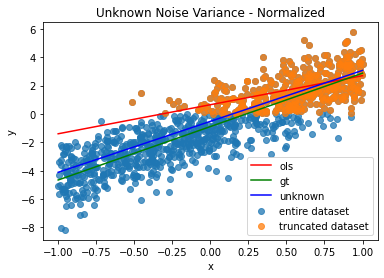

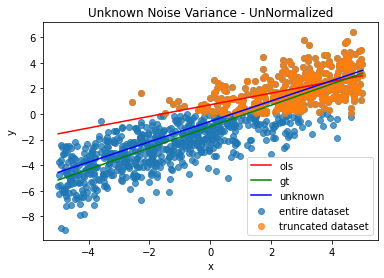

In [41]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [74]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('samples', 1000)
args.__setattr__('n', 100)

EXP = '10Uniform5Features1000Samples'

In [75]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [ ]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    for noise_var in range(1, 21): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(.1*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        known_emp_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc)
        
        with ch.no_grad():
            w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var)
            known_emp_params = ch.cat([w, w0]).flatten()
        
            # known emp results
            store[TABLE_NAME].update_row({
                'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
                'known_emp_time': total_time, 
            })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        
        with ch.no_grad():
            w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
            known_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(noised.flatten(), X@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params),
                'known_time': total_time, 
            })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': phi, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
    
        with ch.no_grad():
            unknown_var = unknown_trunc_reg.variance * emp_noise_var
            w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var)))[None,...]
            unknown_params = ch.cat([w, w0]).flatten()

            # known emp results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params),
                'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
                'unknown_time': total_time, 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/10Uniform5Features1000Samples/792e9f1b-01e9-464f-9af9-ae78d011147d
Iteration: 0.0 | Score: [0.21828189492225647]
Iteration: 1.0 | Score: [0.2697623074054718]
Iteration: 2.0 | Score: [0.20549276471138]
Iteration: 3.0 | Score: [0.07280115783214569]
Iteration: 4.0 | Score: [0.0631147027015686]
Iteration: 5.0 | Score: [0.08201438188552856]
Iteration: 6.0 | Score: [0.08723051100969315]
Iteration: 7.0 | Score: [0.15381579101085663]
Iteration: 8.0 | Score: [0.1235327273607254]
Iteration: 9.0 | Score: [0.1366816759109497]
Iteration: 10.0 | Score: [0.14303690195083618]
Iteration: 11.0 | Score: [0.15186727046966553]
Iteration: 12.0 | Score: [0.1361459195613861]
Iteration: 13.0 | Score: [0.15909284353256226]
Iteration: 14.0 | Score: [0.16475693881511688]
Iteration: 15.0 | Score: [0.13889136910438538]
Iteration: 16.0 | Score: [0.1075362116098404]
Iteration: 17.0 | Score: [0.12834709882736206]
Iteration: 18.0 | Score: [0.12260838598012924]
Iteration: 19

Iteration: 12.0 | Score: [-0.16740120947360992]
Iteration: 13.0 | Score: [-0.16246920824050903]
Iteration: 14.0 | Score: [-0.1895942986011505]
Iteration: 15.0 | Score: [-0.1789594292640686]
Iteration: 16.0 | Score: [-0.2014133632183075]
Iteration: 17.0 | Score: [-0.20539376139640808]
Iteration: 18.0 | Score: [-0.2197040319442749]
Iteration: 19.0 | Score: [-0.1899501085281372]
Iteration: 20.0 | Score: [-0.19716361165046692]
Iteration: 21.0 | Score: [-0.19400811195373535]
Iteration: 22.0 | Score: [-0.20884302258491516]
Iteration: 23.0 | Score: [-0.21189728379249573]
Iteration: 24.0 | Score: [-0.2093127965927124]
Iteration: 25.0 | Score: [-0.21412773430347443]
Iteration: 0.0 | Score: [0.2641749382019043]
Iteration: 1.0 | Score: [0.042724695056676865]
Iteration: 2.0 | Score: [0.07841633260250092]
Iteration: 3.0 | Score: [0.1505679190158844]
Iteration: 4.0 | Score: [0.17089921236038208]
Iteration: 5.0 | Score: [0.2024092823266983]
Iteration: 6.0 | Score: [0.14781886339187622]
Iteration: 7.0

Iteration: 24.0 | Score: [0.22469167411327362]
Iteration: 25.0 | Score: [0.2443644106388092]
Iteration: 0.0 | Score: [0.06156085804104805]
Iteration: 1.0 | Score: [-0.01482592523097992]
Iteration: 2.0 | Score: [0.011815730482339859]
Iteration: 3.0 | Score: [-0.03991798684000969]
Iteration: 4.0 | Score: [-0.022429782897233963]
Iteration: 5.0 | Score: [-0.02982216514647007]
Iteration: 6.0 | Score: [0.021642286330461502]
Iteration: 7.0 | Score: [-0.0032936520874500275]
Iteration: 0.0 | Score: [-0.034493401646614075, 0.6423918008804321]
Iteration: 1.0 | Score: [-0.466992050409317, 1.963582992553711]
Iteration: 2.0 | Score: [-0.3930202126502991, 1.6955949068069458]
Iteration: 3.0 | Score: [0.4225737154483795, -1.5618544816970825]
Iteration: 4.0 | Score: [-0.0830019861459732, 0.562644898891449]
Iteration: 5.0 | Score: [0.005347928032279015, 0.241188183426857]
Iteration: 6.0 | Score: [0.06930141150951385, -0.028319399803876877]
Iteration: 7.0 | Score: [0.12415186315774918, -0.2367783635854721

Iteration: 15.0 | Score: [0.06192060932517052, -0.2999551594257355]
Iteration: 16.0 | Score: [0.05265844985842705, -0.23437216877937317]
Iteration: 17.0 | Score: [0.015840722247958183, -0.1628379225730896]
Iteration: 18.0 | Score: [0.047653332352638245, -0.24840837717056274]
Iteration: 19.0 | Score: [0.11187879741191864, -0.4710058569908142]
Iteration: 20.0 | Score: [0.12575210630893707, -0.5045633316040039]
Iteration: 21.0 | Score: [0.19226087629795074, -0.7279222011566162]
Iteration: 22.0 | Score: [0.11228690296411514, -0.4772881865501404]
Iteration: 23.0 | Score: [0.0790083184838295, -0.3339824676513672]
Iteration: 24.0 | Score: [0.08501388132572174, -0.3939916491508484]
Iteration: 25.0 | Score: [0.10978240519762039, -0.4723525047302246]
Iteration: 0.0 | Score: [0.14200611412525177, -0.27492010593414307]
Iteration: 1.0 | Score: [-0.10632273554801941, 0.2457452118396759]
Iteration: 2.0 | Score: [-0.12737204134464264, 0.2979791462421417]
Iteration: 3.0 | Score: [0.056247252970933914, 

Iteration: 23.0 | Score: [-0.17859899997711182, 0.25308459997177124]
Iteration: 24.0 | Score: [-0.1769620031118393, 0.2386844903230667]
Iteration: 25.0 | Score: [-0.17452871799468994, 0.18137894570827484]
Iteration: 0.0 | Score: [0.2743741571903229]
Iteration: 1.0 | Score: [0.014188520610332489]
Iteration: 2.0 | Score: [0.07928147912025452]
Iteration: 3.0 | Score: [0.0513155460357666]
Iteration: 4.0 | Score: [0.1164405420422554]
Iteration: 5.0 | Score: [0.10287195444107056]
Iteration: 6.0 | Score: [0.11830934882164001]
Iteration: 7.0 | Score: [0.1257784515619278]
Iteration: 8.0 | Score: [0.15807628631591797]
Iteration: 9.0 | Score: [0.15094709396362305]
Iteration: 10.0 | Score: [0.13851115107536316]
Iteration: 11.0 | Score: [0.17900344729423523]
Iteration: 12.0 | Score: [0.18219877779483795]
Iteration: 13.0 | Score: [0.16901668906211853]
Iteration: 14.0 | Score: [0.16154257953166962]
Iteration: 15.0 | Score: [0.18347495794296265]
Iteration: 16.0 | Score: [0.1802399903535843]
Iteration:

Iteration: 7.0 | Score: [0.11370149254798889]
Iteration: 8.0 | Score: [0.0745854526758194]
Iteration: 9.0 | Score: [0.0796549841761589]
Iteration: 10.0 | Score: [0.07470950484275818]
Iteration: 11.0 | Score: [0.04311678931117058]
Iteration: 12.0 | Score: [0.030531855300068855]
Iteration: 13.0 | Score: [0.062190763652324677]
Iteration: 14.0 | Score: [0.05981527641415596]
Iteration: 15.0 | Score: [0.0916253849864006]
Iteration: 16.0 | Score: [0.10198403894901276]
Iteration: 17.0 | Score: [0.06693318486213684]
Iteration: 18.0 | Score: [0.07707155495882034]
Iteration: 19.0 | Score: [0.09233766794204712]
Iteration: 20.0 | Score: [0.07981351017951965]
Iteration: 21.0 | Score: [0.08768822252750397]
Iteration: 22.0 | Score: [0.08015705645084381]
Iteration: 23.0 | Score: [0.08863867074251175]
Iteration: 24.0 | Score: [0.07546508312225342]
Iteration: 25.0 | Score: [0.08027803152799606]
Iteration: 0.0 | Score: [0.23913758993148804]
Iteration: 1.0 | Score: [0.11552900075912476]
Iteration: 2.0 | Sc

Iteration: 3.0 | Score: [0.3655951917171478, -0.7240927815437317]
Iteration: 4.0 | Score: [0.13826343417167664, -0.057209715247154236]
Iteration: 5.0 | Score: [0.19132743775844574, -0.21971669793128967]
Iteration: 6.0 | Score: [0.21355392038822174, -0.2639879584312439]
Iteration: 7.0 | Score: [0.17907360196113586, -0.17577862739562988]
Iteration: 8.0 | Score: [0.16782246530056, -0.15680882334709167]
Iteration: 9.0 | Score: [0.3565382957458496, -0.6965609192848206]
Iteration: 10.0 | Score: [0.13718324899673462, -0.07710855454206467]
Iteration: 11.0 | Score: [0.23749849200248718, -0.36545830965042114]
Iteration: 12.0 | Score: [0.1737544685602188, -0.17548875510692596]
Iteration: 13.0 | Score: [0.09144863486289978, 0.06295815110206604]
Iteration: 14.0 | Score: [0.1814158707857132, -0.19984760880470276]
Iteration: 15.0 | Score: [0.1603584885597229, -0.12879516184329987]
Iteration: 16.0 | Score: [0.15129612386226654, -0.10363948345184326]
Iteration: 17.0 | Score: [0.1593761146068573, -0.150

Iteration: 23.0 | Score: [0.06965000182390213, 0.05980706214904785]
Iteration: 24.0 | Score: [0.07859079539775848, 0.02504335343837738]
Iteration: 25.0 | Score: [0.08571592718362808, -0.02421681210398674]
Iteration: 0.0 | Score: [0.18030139803886414]
Iteration: 1.0 | Score: [0.060458168387413025]
Iteration: 2.0 | Score: [0.07742325961589813]
Iteration: 3.0 | Score: [0.08150684833526611]
Iteration: 4.0 | Score: [0.039105791598558426]
Iteration: 5.0 | Score: [0.057241182774305344]
Iteration: 6.0 | Score: [0.045827850699424744]
Iteration: 7.0 | Score: [0.053963541984558105]
Iteration: 8.0 | Score: [0.02146117016673088]
Iteration: 9.0 | Score: [0.017235813662409782]
Iteration: 10.0 | Score: [0.0027731098234653473]
Iteration: 0.0 | Score: [0.31748855113983154]
Iteration: 1.0 | Score: [0.09873147308826447]
Iteration: 2.0 | Score: [0.08511354774236679]
Iteration: 3.0 | Score: [0.10660351067781448]
Iteration: 4.0 | Score: [0.11092926561832428]
Iteration: 5.0 | Score: [0.1290655881166458]
Itera

Iteration: 1.0 | Score: [0.1621629148721695]
Iteration: 2.0 | Score: [0.14309391379356384]
Iteration: 3.0 | Score: [0.1314634531736374]
Iteration: 4.0 | Score: [0.11663103103637695]
Iteration: 5.0 | Score: [0.13337068259716034]
Iteration: 6.0 | Score: [0.11815975606441498]
Iteration: 7.0 | Score: [0.11537007987499237]
Iteration: 8.0 | Score: [0.13084614276885986]
Iteration: 9.0 | Score: [0.11973414570093155]
Iteration: 10.0 | Score: [0.1225883811712265]
Iteration: 11.0 | Score: [0.10697732865810394]
Iteration: 12.0 | Score: [0.1314050853252411]
Iteration: 13.0 | Score: [0.10617531090974808]
Iteration: 14.0 | Score: [0.12668529152870178]
Iteration: 15.0 | Score: [0.09814199805259705]
Iteration: 16.0 | Score: [0.12239409238100052]
Iteration: 17.0 | Score: [0.09189104288816452]
Iteration: 18.0 | Score: [0.10793790221214294]
Iteration: 19.0 | Score: [0.11681026965379715]
Iteration: 20.0 | Score: [0.11065506935119629]
Iteration: 21.0 | Score: [0.11120282113552094]
Iteration: 22.0 | Score: [

Iteration: 10.0 | Score: [-0.13578370213508606]
Iteration: 11.0 | Score: [-0.13620343804359436]
Iteration: 12.0 | Score: [-0.1247309222817421]
Iteration: 13.0 | Score: [-0.12662577629089355]
Iteration: 14.0 | Score: [-0.1192098930478096]
Iteration: 15.0 | Score: [-0.120941162109375]
Iteration: 16.0 | Score: [-0.13893795013427734]
Iteration: 17.0 | Score: [-0.13122232258319855]
Iteration: 18.0 | Score: [-0.10458359867334366]
Iteration: 19.0 | Score: [-0.13313612341880798]
Iteration: 20.0 | Score: [-0.1304042935371399]
Iteration: 21.0 | Score: [-0.12317584455013275]
Iteration: 22.0 | Score: [-0.10700073093175888]
Iteration: 23.0 | Score: [-0.14058630168437958]
Iteration: 24.0 | Score: [-0.12918251752853394]
Iteration: 25.0 | Score: [-0.127183198928833]
Iteration: 0.0 | Score: [0.2079188972711563]
Iteration: 1.0 | Score: [0.03558734804391861]
Iteration: 2.0 | Score: [0.001956980675458908]
Iteration: 0.0 | Score: [0.17668014764785767, -0.1505720019340515]
Iteration: 1.0 | Score: [-0.109873

Iteration: 16.0 | Score: [0.08034037053585052, -0.14410391449928284]
Iteration: 17.0 | Score: [0.1143304780125618, -0.18978309631347656]
Iteration: 18.0 | Score: [0.14623308181762695, -0.2802928686141968]
Iteration: 19.0 | Score: [0.12515661120414734, -0.23922261595726013]
Iteration: 20.0 | Score: [0.1632707715034485, -0.3505101203918457]
Iteration: 21.0 | Score: [0.16129836440086365, -0.32914111018180847]
Iteration: 22.0 | Score: [0.1979943811893463, -0.38916027545928955]
Iteration: 23.0 | Score: [0.20887330174446106, -0.42227795720100403]
Iteration: 24.0 | Score: [0.19985602796077728, -0.4004075527191162]
Iteration: 25.0 | Score: [0.21615907549858093, -0.4501765966415405]
Iteration: 0.0 | Score: [0.24800561368465424, -0.3276422321796417]
Iteration: 1.0 | Score: [0.24614019691944122, -0.5607014894485474]
Iteration: 2.0 | Score: [0.008038490079343319, -0.04493192583322525]
Iteration: 3.0 | Score: [-0.06498198956251144, 0.11727391183376312]
Iteration: 4.0 | Score: [-0.07368540018796921,

Iteration: 1.0 | Score: [-0.08679679781198502]
Iteration: 2.0 | Score: [-0.1238403469324112]
Iteration: 3.0 | Score: [-0.0544319823384285]
Iteration: 4.0 | Score: [-0.07807832211256027]
Iteration: 5.0 | Score: [-0.128278911113739]
Iteration: 6.0 | Score: [-0.11836951971054077]
Iteration: 7.0 | Score: [-0.1898166686296463]
Iteration: 8.0 | Score: [-0.14760148525238037]
Iteration: 9.0 | Score: [-0.11555353552103043]
Iteration: 10.0 | Score: [-0.08153187483549118]
Iteration: 11.0 | Score: [-0.09061256796121597]
Iteration: 12.0 | Score: [-0.141575425863266]
Iteration: 13.0 | Score: [-0.0968303307890892]
Iteration: 14.0 | Score: [-0.1304684430360794]
Iteration: 15.0 | Score: [-0.10655448585748672]
Iteration: 16.0 | Score: [-0.12476618587970734]
Iteration: 17.0 | Score: [-0.10862523317337036]
Iteration: 18.0 | Score: [-0.11238620430231094]
Iteration: 19.0 | Score: [-0.13824233412742615]
Iteration: 20.0 | Score: [-0.10965471714735031]
Iteration: 21.0 | Score: [-0.11498720198869705]
Iteration:

Iteration: 5.0 | Score: [0.15547984838485718]
Iteration: 6.0 | Score: [0.1890462040901184]
Iteration: 7.0 | Score: [0.17436683177947998]
Iteration: 8.0 | Score: [0.20722992718219757]
Iteration: 9.0 | Score: [0.23629090189933777]
Iteration: 10.0 | Score: [0.1922866702079773]
Iteration: 11.0 | Score: [0.2110181301832199]
Iteration: 12.0 | Score: [0.21586909890174866]
Iteration: 13.0 | Score: [0.17475804686546326]
Iteration: 14.0 | Score: [0.17603525519371033]
Iteration: 15.0 | Score: [0.17864340543746948]
Iteration: 16.0 | Score: [0.21607479453086853]
Iteration: 17.0 | Score: [0.19632303714752197]
Iteration: 18.0 | Score: [0.19521665573120117]
Iteration: 19.0 | Score: [0.21695366501808167]
Iteration: 20.0 | Score: [0.2062067985534668]
Iteration: 21.0 | Score: [0.19359639286994934]
Iteration: 22.0 | Score: [0.22443798184394836]
Iteration: 23.0 | Score: [0.2080833613872528]
Iteration: 24.0 | Score: [0.20392730832099915]
Iteration: 25.0 | Score: [0.20723885297775269]
Iteration: 0.0 | Score:

Iteration: 20.0 | Score: [0.12270694226026535]
Iteration: 21.0 | Score: [0.08399906754493713]
Iteration: 22.0 | Score: [0.13485412299633026]
Iteration: 23.0 | Score: [0.1072988212108612]
Iteration: 24.0 | Score: [0.1232631728053093]
Iteration: 25.0 | Score: [0.12470006942749023]
Iteration: 0.0 | Score: [0.2634814977645874, -0.5795161724090576]
Iteration: 1.0 | Score: [0.7758787274360657, -3.279618978500366]
Iteration: 2.0 | Score: [0.34318807721138, -1.1493722200393677]
Iteration: 3.0 | Score: [-0.20459678769111633, 1.1214263439178467]
Iteration: 4.0 | Score: [0.029974693432450294, 0.10689046233892441]
Iteration: 5.0 | Score: [0.7104719877243042, -3.17118763923645]
Iteration: 6.0 | Score: [0.946869432926178, -4.529225826263428]
Iteration: 7.0 | Score: [0.11517531424760818, -0.33681321144104004]
Iteration: 8.0 | Score: [-0.0878138542175293, 0.5074865221977234]
Iteration: 9.0 | Score: [-0.18921628594398499, 0.9676738977432251]
Iteration: 10.0 | Score: [0.12477625906467438, -0.37787526845

Iteration: 10.0 | Score: [-0.08061910420656204, 0.01257617399096489]
Iteration: 11.0 | Score: [-0.19459110498428345, 0.45719242095947266]
Iteration: 12.0 | Score: [-0.07126342505216599, -0.023780707269906998]
Iteration: 13.0 | Score: [-0.015586608089506626, -0.2737712264060974]
Iteration: 14.0 | Score: [0.2761024236679077, -1.5338574647903442]
Iteration: 15.0 | Score: [0.07658647745847702, -0.6728872656822205]
Iteration: 16.0 | Score: [-0.06802105903625488, -0.11509616672992706]
Iteration: 17.0 | Score: [-0.13388799130916595, 0.12342683970928192]
Iteration: 18.0 | Score: [-0.050328128039836884, -0.14663515985012054]
Iteration: 19.0 | Score: [-0.11721204221248627, 0.11415135115385056]
Iteration: 20.0 | Score: [-0.004652767442166805, -0.3186000883579254]
Iteration: 21.0 | Score: [-0.07542640715837479, -0.07535580545663834]
Iteration: 22.0 | Score: [0.08770868927240372, -0.8263255953788757]
Iteration: 23.0 | Score: [0.15408866107463837, -1.0021202564239502]
Iteration: 24.0 | Score: [0.006

Iteration: 11.0 | Score: [-0.1570764034986496, 0.36404484510421753]
Iteration: 12.0 | Score: [0.11213614046573639, -0.5744713544845581]
Iteration: 13.0 | Score: [-0.019755816087126732, -0.14755621552467346]
Iteration: 14.0 | Score: [0.0612642802298069, -0.3788982033729553]
Iteration: 15.0 | Score: [0.03160998970270157, -0.29153650999069214]
Iteration: 16.0 | Score: [0.07991693913936615, -0.4518515467643738]
Iteration: 17.0 | Score: [-0.05114243924617767, 0.008942734450101852]
Iteration: 18.0 | Score: [0.07295554131269455, -0.401848703622818]
Iteration: 19.0 | Score: [0.07378074526786804, -0.47280165553092957]
Iteration: 20.0 | Score: [0.08135005831718445, -0.4562737047672272]
Iteration: 21.0 | Score: [0.023934585973620415, -0.24755644798278809]
Iteration: 22.0 | Score: [0.026071997359395027, -0.2706140875816345]
Iteration: 23.0 | Score: [-0.04348941147327423, -0.0075997523963451385]
Iteration: 24.0 | Score: [0.023750165477395058, -0.29288211464881897]
Iteration: 25.0 | Score: [0.075431

Iteration: 11.0 | Score: [0.2796819508075714, -0.7458655834197998]
Iteration: 12.0 | Score: [0.21291744709014893, -0.5660831928253174]
Iteration: 13.0 | Score: [0.2841111421585083, -0.7516059279441833]
Iteration: 14.0 | Score: [0.4637813866138458, -1.3205839395523071]
Iteration: 15.0 | Score: [0.45870256423950195, -1.2817109823226929]
Iteration: 16.0 | Score: [0.36791300773620605, -0.9914712309837341]
Iteration: 17.0 | Score: [0.3794788122177124, -1.0480268001556396]
Iteration: 18.0 | Score: [0.217862069606781, -0.582161009311676]
Iteration: 19.0 | Score: [0.31352558732032776, -0.8880051970481873]
Iteration: 20.0 | Score: [0.3696410059928894, -1.0024436712265015]
Iteration: 21.0 | Score: [0.3256388306617737, -0.8459923267364502]
Iteration: 22.0 | Score: [0.30864396691322327, -0.8785776495933533]
Iteration: 23.0 | Score: [0.3545941412448883, -0.9782750010490417]
Iteration: 24.0 | Score: [0.3873100280761719, -1.0931410789489746]
Iteration: 25.0 | Score: [0.3758608102798462, -1.0362250804

Iteration: 1.0 | Score: [-0.002995437942445278]
Iteration: 0.0 | Score: [0.4314175248146057, -0.6623929142951965]
Iteration: 1.0 | Score: [0.25419139862060547, -0.43477296829223633]
Iteration: 2.0 | Score: [0.35198676586151123, -0.7234593033790588]
Iteration: 3.0 | Score: [0.05604824796319008, 0.01036134548485279]
Iteration: 4.0 | Score: [0.24936777353286743, -0.536618709564209]
Iteration: 5.0 | Score: [0.34871986508369446, -0.8439466953277588]
Iteration: 6.0 | Score: [0.04618791863322258, -0.045157499611377716]
Iteration: 7.0 | Score: [0.04849974438548088, -0.02913336269557476]
Iteration: 8.0 | Score: [0.44960516691207886, -1.1550285816192627]
Iteration: 9.0 | Score: [0.13735917210578918, -0.24030539393424988]
Iteration: 10.0 | Score: [0.22061066329479218, -0.49052193760871887]
Iteration: 11.0 | Score: [0.30895769596099854, -0.7301512956619263]
Iteration: 12.0 | Score: [0.21746927499771118, -0.48571401834487915]
Iteration: 13.0 | Score: [0.21667012572288513, -0.44133126735687256]
Iter

Iteration: 9.0 | Score: [0.1635652333498001]
Iteration: 10.0 | Score: [0.15531815588474274]
Iteration: 11.0 | Score: [0.11343474686145782]
Iteration: 12.0 | Score: [0.14853979647159576]
Iteration: 13.0 | Score: [0.14959564805030823]
Iteration: 14.0 | Score: [0.12603069841861725]
Iteration: 15.0 | Score: [0.11917108297348022]
Iteration: 16.0 | Score: [0.1309703141450882]
Iteration: 17.0 | Score: [0.14922790229320526]
Iteration: 18.0 | Score: [0.14257943630218506]
Iteration: 19.0 | Score: [0.14656315743923187]
Iteration: 20.0 | Score: [0.15654852986335754]
Iteration: 21.0 | Score: [0.12222461402416229]
Iteration: 22.0 | Score: [0.13148194551467896]
Iteration: 23.0 | Score: [0.15246295928955078]
Iteration: 24.0 | Score: [0.12818968296051025]
Iteration: 25.0 | Score: [0.14718468487262726]
Iteration: 0.0 | Score: [0.4025976061820984]
Iteration: 1.0 | Score: [0.22029247879981995]
Iteration: 2.0 | Score: [0.19691847264766693]
Iteration: 3.0 | Score: [0.15386512875556946]
Iteration: 4.0 | Scor

Iteration: 20.0 | Score: [-0.11033447086811066, 0.38918542861938477]
Iteration: 21.0 | Score: [-0.09435383975505829, 0.3750642240047455]
Iteration: 22.0 | Score: [-0.08803438395261765, 0.32407787442207336]
Iteration: 23.0 | Score: [-0.08522789925336838, 0.3278713822364807]
Iteration: 24.0 | Score: [-0.1552216112613678, 0.5022079348564148]
Iteration: 25.0 | Score: [-0.08711107075214386, 0.3525385558605194]
Iteration: 0.0 | Score: [-0.20712615549564362, 1.2825802564620972]
Iteration: 1.0 | Score: [-0.5138847231864929, 1.843417763710022]
Iteration: 2.0 | Score: [-0.25927233695983887, 1.1644643545150757]
Iteration: 3.0 | Score: [-0.14015431702136993, 0.7965124249458313]
Iteration: 4.0 | Score: [-0.43248429894447327, 1.5767730474472046]
Iteration: 5.0 | Score: [-0.47362515330314636, 1.6632652282714844]
Iteration: 6.0 | Score: [-0.31534427404403687, 1.2134665250778198]
Iteration: 7.0 | Score: [-0.26929140090942383, 1.1133062839508057]
Iteration: 8.0 | Score: [-0.25560709834098816, 1.07773661

Iteration: 17.0 | Score: [-0.04183203727006912, -0.16424569487571716]
Iteration: 18.0 | Score: [-0.11101024597883224, -0.02499215304851532]
Iteration: 19.0 | Score: [-0.1917998343706131, 0.16467976570129395]
Iteration: 20.0 | Score: [-0.18272458016872406, 0.16885174810886383]
Iteration: 21.0 | Score: [-0.15418806672096252, 0.07720799744129181]
Iteration: 22.0 | Score: [-0.101933553814888, -0.02095653861761093]
Iteration: 23.0 | Score: [-0.13738581538200378, 0.06639719009399414]
Iteration: 24.0 | Score: [-0.14729230105876923, 0.08014857023954391]
Iteration: 25.0 | Score: [-0.14205852150917053, 0.0690959095954895]
Iteration: 0.0 | Score: [0.140035018324852]
Iteration: 1.0 | Score: [0.016370996832847595]
Iteration: 2.0 | Score: [-0.019411956891417503]
Iteration: 3.0 | Score: [-0.05806896835565567]
Iteration: 4.0 | Score: [-0.1273866891860962]
Iteration: 5.0 | Score: [-0.12278425693511963]
Iteration: 6.0 | Score: [-0.032533351331949234]
Iteration: 7.0 | Score: [-0.01498693972826004]
Iterat

Iteration: 2.0 | Score: [-0.04563456028699875]
Iteration: 3.0 | Score: [0.03257220238447189]
Iteration: 4.0 | Score: [0.000736139714717865]
Iteration: 0.0 | Score: [0.12240242958068848, -0.0030174069106578827]
Iteration: 1.0 | Score: [0.2265598028898239, -0.4647968113422394]
Iteration: 2.0 | Score: [-0.023751500993967056, 0.07937107235193253]
Iteration: 3.0 | Score: [-0.08033588528633118, 0.19790025055408478]
Iteration: 4.0 | Score: [-0.03158888593316078, 0.04484592378139496]
Iteration: 5.0 | Score: [-0.15528133511543274, 0.35825449228286743]
Iteration: 6.0 | Score: [-0.01338791474699974, 0.0324547216296196]
Iteration: 7.0 | Score: [-0.03415782004594803, 0.056228846311569214]
Iteration: 8.0 | Score: [0.3120284080505371, -0.9152272939682007]
Iteration: 9.0 | Score: [0.011818652041256428, -0.026534855365753174]
Iteration: 10.0 | Score: [-0.009455358609557152, 0.027052268385887146]
Iteration: 11.0 | Score: [0.028063930571079254, -0.08708634972572327]
Iteration: 12.0 | Score: [0.0245318226

Iteration: 9.0 | Score: [0.0985584408044815, -0.18626129627227783]
Iteration: 10.0 | Score: [0.29547902941703796, -0.667977511882782]
Iteration: 11.0 | Score: [0.18544314801692963, -0.3972100615501404]
Iteration: 12.0 | Score: [0.09806311875581741, -0.2252596914768219]
Iteration: 13.0 | Score: [0.15034465491771698, -0.3363470435142517]
Iteration: 14.0 | Score: [0.1057349219918251, -0.24332834780216217]
Iteration: 15.0 | Score: [0.0844377726316452, -0.17231601476669312]
Iteration: 16.0 | Score: [0.30213919281959534, -0.6674733757972717]
Iteration: 17.0 | Score: [0.2709366977214813, -0.6356858015060425]
Iteration: 18.0 | Score: [0.10588371753692627, -0.24650372564792633]
Iteration: 19.0 | Score: [0.14876241981983185, -0.3180132508277893]
Iteration: 20.0 | Score: [0.10870629549026489, -0.24124684929847717]
Iteration: 21.0 | Score: [0.1817958503961563, -0.3844790458679199]
Iteration: 22.0 | Score: [0.22744257748126984, -0.49927133321762085]
Iteration: 23.0 | Score: [0.1787850260734558, -0.

Iteration: 24.0 | Score: [-0.2835845649242401]
Iteration: 25.0 | Score: [-0.30123743414878845]
Iteration: 0.0 | Score: [0.27939265966415405]
Iteration: 1.0 | Score: [0.1422424614429474]
Iteration: 2.0 | Score: [0.09083452820777893]
Iteration: 3.0 | Score: [0.14227037131786346]
Iteration: 4.0 | Score: [0.1051761656999588]
Iteration: 5.0 | Score: [0.10308463871479034]
Iteration: 6.0 | Score: [0.12473516911268234]
Iteration: 7.0 | Score: [0.09283670037984848]
Iteration: 8.0 | Score: [0.05975332111120224]
Iteration: 9.0 | Score: [0.08650227636098862]
Iteration: 10.0 | Score: [0.1282562017440796]
Iteration: 11.0 | Score: [0.08819948136806488]
Iteration: 12.0 | Score: [0.13755162060260773]
Iteration: 13.0 | Score: [0.09870084375143051]
Iteration: 14.0 | Score: [0.12498457729816437]
Iteration: 15.0 | Score: [0.08754412829875946]
Iteration: 16.0 | Score: [0.07505474984645844]
Iteration: 17.0 | Score: [0.07583409547805786]
Iteration: 18.0 | Score: [0.12176623195409775]
Iteration: 19.0 | Score: 

Iteration: 23.0 | Score: [0.31008580327033997, -0.4470524489879608]
Iteration: 24.0 | Score: [0.205190971493721, -0.18500256538391113]
Iteration: 25.0 | Score: [0.14991042017936707, -0.05714826658368111]
Iteration: 0.0 | Score: [0.17580652236938477, -0.29694923758506775]
Iteration: 1.0 | Score: [0.43919435143470764, -1.1181484460830688]
Iteration: 2.0 | Score: [-0.20749488472938538, 0.30844801664352417]
Iteration: 3.0 | Score: [-0.12852293252944946, 0.13913041353225708]
Iteration: 4.0 | Score: [-0.14663715660572052, 0.16226425766944885]
Iteration: 5.0 | Score: [-0.07192201912403107, 0.007915813475847244]
Iteration: 6.0 | Score: [0.1151881217956543, -0.4070713222026825]
Iteration: 7.0 | Score: [-0.1995280534029007, 0.260332852602005]
Iteration: 8.0 | Score: [-0.10773932188749313, 0.09873667359352112]
Iteration: 9.0 | Score: [-0.004449700005352497, -0.1590212881565094]
Iteration: 10.0 | Score: [0.0830463245511055, -0.3520753085613251]
Iteration: 11.0 | Score: [-0.1532524973154068, 0.1339

Iteration: 17.0 | Score: [-0.20734059810638428, 1.3855375051498413]
Iteration: 18.0 | Score: [-0.22195039689540863, 1.4555500745773315]
Iteration: 19.0 | Score: [-0.3723911941051483, 2.311580181121826]
Iteration: 20.0 | Score: [0.21143288910388947, -1.107488751411438]
Iteration: 21.0 | Score: [0.08799058943986893, -0.5076979398727417]
Iteration: 22.0 | Score: [-0.36035946011543274, 2.3144049644470215]
Iteration: 23.0 | Score: [0.11109957098960876, -0.6025266647338867]
Iteration: 24.0 | Score: [0.18785539269447327, -1.0795130729675293]
Iteration: 25.0 | Score: [-0.22090454399585724, 1.3866770267486572]
Iteration: 0.0 | Score: [-0.012066859751939774]
Iteration: 1.0 | Score: [-0.15080396831035614]
Iteration: 2.0 | Score: [-0.15677472949028015]
Iteration: 3.0 | Score: [-0.1114591583609581]
Iteration: 4.0 | Score: [-0.10083615779876709]
Iteration: 5.0 | Score: [-0.16398274898529053]
Iteration: 6.0 | Score: [-0.10077089816331863]
Iteration: 7.0 | Score: [-0.11537118256092072]
Iteration: 8.0 

Iteration: 4.0 | Score: [-0.44081124663352966, 1.175567865371704]
Iteration: 5.0 | Score: [-0.34780704975128174, 0.8010784387588501]
Iteration: 6.0 | Score: [-0.26761478185653687, 0.5119046568870544]
Iteration: 7.0 | Score: [-0.36971092224121094, 0.9224095940589905]
Iteration: 8.0 | Score: [-0.2186264544725418, 0.308622807264328]
Iteration: 9.0 | Score: [-0.44971993565559387, 1.2135640382766724]
Iteration: 10.0 | Score: [-0.2723458409309387, 0.5535687804222107]
Iteration: 11.0 | Score: [-0.2689097225666046, 0.49909982085227966]
Iteration: 12.0 | Score: [-0.09604601562023163, -0.23997615277767181]
Iteration: 13.0 | Score: [-0.13835656642913818, -0.08909595012664795]
Iteration: 14.0 | Score: [-0.286668062210083, 0.6361901760101318]
Iteration: 15.0 | Score: [-0.2519916892051697, 0.5558255910873413]
Iteration: 16.0 | Score: [-0.13748669624328613, 0.013694286346435547]
Iteration: 17.0 | Score: [-0.2681143581867218, 0.5420576930046082]
Iteration: 18.0 | Score: [-0.35894620418548584, 0.830662

Iteration: 5.0 | Score: [-0.12211541831493378]
Iteration: 6.0 | Score: [-0.12146694958209991]
Iteration: 7.0 | Score: [-0.08733412623405457]
Iteration: 8.0 | Score: [-0.14065012335777283]
Iteration: 9.0 | Score: [-0.10469651967287064]
Iteration: 10.0 | Score: [-0.11120691895484924]
Iteration: 11.0 | Score: [-0.10340839624404907]
Iteration: 12.0 | Score: [-0.12170222401618958]
Iteration: 13.0 | Score: [-0.08969337493181229]
Iteration: 14.0 | Score: [-0.10553054511547089]
Iteration: 15.0 | Score: [-0.1084246039390564]
Iteration: 16.0 | Score: [-0.09488406777381897]
Iteration: 17.0 | Score: [-0.09642459452152252]
Iteration: 18.0 | Score: [-0.06573423743247986]
Iteration: 19.0 | Score: [-0.1009637713432312]
Iteration: 20.0 | Score: [-0.12808522582054138]
Iteration: 21.0 | Score: [-0.11450967937707901]
Iteration: 22.0 | Score: [-0.11355207860469818]
Iteration: 23.0 | Score: [-0.08358076959848404]
Iteration: 24.0 | Score: [-0.10357794165611267]
Iteration: 25.0 | Score: [-0.10385376214981079]

Iteration: 18.0 | Score: [-0.10283031314611435]
Iteration: 19.0 | Score: [-0.10645349323749542]
Iteration: 20.0 | Score: [-0.12286008894443512]
Iteration: 21.0 | Score: [-0.1046329066157341]
Iteration: 22.0 | Score: [-0.10184822976589203]
Iteration: 23.0 | Score: [-0.09495627135038376]
Iteration: 24.0 | Score: [-0.10613112896680832]
Iteration: 25.0 | Score: [-0.09130246937274933]
Iteration: 0.0 | Score: [0.2372346669435501, -0.39022189378738403]
Iteration: 1.0 | Score: [0.14476172626018524, -0.45322418212890625]
Iteration: 2.0 | Score: [-0.25741031765937805, 0.5996705889701843]
Iteration: 3.0 | Score: [-0.06991057097911835, 0.0793309360742569]
Iteration: 4.0 | Score: [-0.2043103575706482, 0.46470513939857483]
Iteration: 5.0 | Score: [-0.14845676720142365, 0.23730556666851044]
Iteration: 6.0 | Score: [0.14379127323627472, -0.6397218704223633]
Iteration: 7.0 | Score: [-0.08936255425214767, 0.1416683942079544]
Iteration: 8.0 | Score: [0.07409993559122086, -0.37611719965934753]
Iteration: 

Iteration: 18.0 | Score: [0.07237793505191803, -0.20526351034641266]
Iteration: 19.0 | Score: [-0.04645569995045662, 0.1661711037158966]
Iteration: 20.0 | Score: [0.1296720951795578, -0.3337179124355316]
Iteration: 21.0 | Score: [0.011718399822711945, 0.011147614568471909]
Iteration: 22.0 | Score: [0.03508161008358002, -0.10452166944742203]
Iteration: 23.0 | Score: [-0.049190420657396317, 0.15882718563079834]
Iteration: 24.0 | Score: [-0.03533076122403145, 0.1264626532793045]
Iteration: 25.0 | Score: [0.020918365567922592, -0.032018955796957016]
Iteration: 0.0 | Score: [0.34675106406211853]
Iteration: 1.0 | Score: [0.13498333096504211]
Iteration: 2.0 | Score: [0.18173527717590332]
Iteration: 3.0 | Score: [0.19257904589176178]
Iteration: 4.0 | Score: [0.06876962631940842]
Iteration: 5.0 | Score: [0.20343245565891266]
Iteration: 6.0 | Score: [0.17930008471012115]
Iteration: 7.0 | Score: [0.14124825596809387]
Iteration: 8.0 | Score: [0.09948518872261047]
Iteration: 9.0 | Score: [0.1753215

Iteration: 12.0 | Score: [0.10101351886987686]
Iteration: 13.0 | Score: [0.11817244440317154]
Iteration: 14.0 | Score: [0.08606702089309692]
Iteration: 15.0 | Score: [0.10160143673419952]
Iteration: 16.0 | Score: [0.0937228873372078]
Iteration: 17.0 | Score: [0.08986249566078186]
Iteration: 18.0 | Score: [0.08618992567062378]
Iteration: 19.0 | Score: [0.09860502183437347]
Iteration: 20.0 | Score: [0.08871836960315704]
Iteration: 21.0 | Score: [0.0823809802532196]
Iteration: 22.0 | Score: [0.06670542061328888]
Iteration: 23.0 | Score: [0.09099211543798447]
Iteration: 24.0 | Score: [0.08916758745908737]
Iteration: 25.0 | Score: [0.0761207640171051]
Iteration: 0.0 | Score: [0.09795993566513062, 0.129229336977005]
Iteration: 1.0 | Score: [0.09866460412740707, -0.1264781951904297]
Iteration: 2.0 | Score: [-0.32846683263778687, 0.9316849112510681]
Iteration: 3.0 | Score: [-0.2386942356824875, 0.7050783038139343]
Iteration: 4.0 | Score: [-0.32288995385169983, 0.9003270864486694]
Iteration: 5.

Iteration: 16.0 | Score: [0.23422060906887054, -0.36171698570251465]
Iteration: 17.0 | Score: [0.14526936411857605, -0.10593339055776596]
Iteration: 18.0 | Score: [0.17395828664302826, -0.19419479370117188]
Iteration: 19.0 | Score: [0.08288740366697311, 0.023979753255844116]
Iteration: 20.0 | Score: [0.14635294675827026, -0.10966214537620544]
Iteration: 21.0 | Score: [0.18502095341682434, -0.20794498920440674]
Iteration: 22.0 | Score: [0.14179475605487823, -0.10060764849185944]
Iteration: 23.0 | Score: [0.1509200632572174, -0.11720851063728333]
Iteration: 24.0 | Score: [0.15759459137916565, -0.15418130159378052]
Iteration: 25.0 | Score: [0.19531533122062683, -0.23832623660564423]
Iteration: 0.0 | Score: [0.22203212976455688]
Iteration: 1.0 | Score: [-0.002493593841791153]
Iteration: 0.0 | Score: [0.2928515672683716]
Iteration: 1.0 | Score: [0.024873295798897743]
Iteration: 2.0 | Score: [0.08051230758428574]
Iteration: 3.0 | Score: [0.05294673889875412]
Iteration: 4.0 | Score: [0.091331

Iteration: 5.0 | Score: [0.10482317209243774]
Iteration: 6.0 | Score: [0.11560001224279404]
Iteration: 7.0 | Score: [0.06515343487262726]
Iteration: 8.0 | Score: [0.06447844952344894]
Iteration: 9.0 | Score: [0.08816471695899963]
Iteration: 10.0 | Score: [0.13409994542598724]
Iteration: 11.0 | Score: [0.09736719727516174]
Iteration: 12.0 | Score: [0.08174031227827072]
Iteration: 13.0 | Score: [0.09382056444883347]
Iteration: 14.0 | Score: [0.09386603534221649]
Iteration: 15.0 | Score: [0.09511266648769379]
Iteration: 16.0 | Score: [0.1002514585852623]
Iteration: 17.0 | Score: [0.07363284379243851]
Iteration: 18.0 | Score: [0.08604046702384949]
Iteration: 19.0 | Score: [0.09855350852012634]
Iteration: 20.0 | Score: [0.09739326685667038]
Iteration: 21.0 | Score: [0.09803957492113113]
Iteration: 22.0 | Score: [0.10626880079507828]
Iteration: 23.0 | Score: [0.07502774894237518]
Iteration: 24.0 | Score: [0.07291591167449951]
Iteration: 25.0 | Score: [0.11389853060245514]
Iteration: 0.0 | Sc

Iteration: 21.0 | Score: [-0.22492769360542297, 0.4138181507587433]
Iteration: 22.0 | Score: [-0.19402755796909332, 0.3590267300605774]
Iteration: 23.0 | Score: [-0.19991295039653778, 0.3533577620983124]
Iteration: 24.0 | Score: [-0.1827082633972168, 0.33815962076187134]
Iteration: 25.0 | Score: [-0.2092513144016266, 0.3706464469432831]
Iteration: 0.0 | Score: [-0.07154729962348938, 0.3261670470237732]
Iteration: 1.0 | Score: [-0.04721055179834366, 0.1096174567937851]
Iteration: 2.0 | Score: [-0.3904871344566345, 0.738349199295044]
Iteration: 3.0 | Score: [-0.38737791776657104, 0.7475780248641968]
Iteration: 4.0 | Score: [-0.2303018420934677, 0.3495504856109619]
Iteration: 5.0 | Score: [-0.30626705288887024, 0.5455042123794556]
Iteration: 6.0 | Score: [-0.4116568863391876, 0.755162239074707]
Iteration: 7.0 | Score: [-0.4295629560947418, 0.8015512228012085]
Iteration: 8.0 | Score: [-0.2574988007545471, 0.41221702098846436]
Iteration: 9.0 | Score: [-0.22034437954425812, 0.307625025510787

Iteration: 21.0 | Score: [0.04097812995314598, -0.04811246693134308]
Iteration: 22.0 | Score: [-0.031352099031209946, 0.13572558760643005]
Iteration: 23.0 | Score: [-0.06728015094995499, 0.1751464307308197]
Iteration: 24.0 | Score: [0.07146379351615906, -0.09998321533203125]
Iteration: 25.0 | Score: [0.03185495361685753, -0.025285348296165466]
Iteration: 0.0 | Score: [0.29142633080482483]
Iteration: 1.0 | Score: [0.07774071395397186]
Iteration: 2.0 | Score: [0.12243813276290894]
Iteration: 3.0 | Score: [0.11060436069965363]
Iteration: 4.0 | Score: [0.14718911051750183]
Iteration: 5.0 | Score: [0.09197968244552612]
Iteration: 6.0 | Score: [0.1648641973733902]
Iteration: 7.0 | Score: [0.1561121642589569]
Iteration: 8.0 | Score: [0.14890873432159424]
Iteration: 9.0 | Score: [0.11565953493118286]
Iteration: 10.0 | Score: [0.16129359602928162]
Iteration: 11.0 | Score: [0.17025718092918396]
Iteration: 12.0 | Score: [0.14223721623420715]
Iteration: 13.0 | Score: [0.14355437457561493]
Iteratio

Iteration: 5.0 | Score: [-0.13326102495193481]
Iteration: 6.0 | Score: [-0.06287282705307007]
Iteration: 7.0 | Score: [-0.1263037770986557]
Iteration: 8.0 | Score: [-0.08554510027170181]
Iteration: 9.0 | Score: [-0.10789544880390167]
Iteration: 10.0 | Score: [-0.07020502537488937]
Iteration: 11.0 | Score: [-0.12779679894447327]
Iteration: 12.0 | Score: [-0.10712464898824692]
Iteration: 13.0 | Score: [-0.08358243852853775]
Iteration: 14.0 | Score: [-0.14440090954303741]
Iteration: 15.0 | Score: [-0.06681885570287704]
Iteration: 16.0 | Score: [-0.13138215243816376]
Iteration: 17.0 | Score: [-0.11639050394296646]
Iteration: 18.0 | Score: [-0.1234077736735344]
Iteration: 19.0 | Score: [-0.10775028169155121]
Iteration: 20.0 | Score: [-0.10525190085172653]
Iteration: 21.0 | Score: [-0.11147385835647583]
Iteration: 22.0 | Score: [-0.10369620472192764]
Iteration: 23.0 | Score: [-0.08278249204158783]
Iteration: 24.0 | Score: [-0.11859413981437683]
Iteration: 25.0 | Score: [-0.09709758311510086]

Iteration: 0.0 | Score: [0.22191773355007172, -0.9322126507759094]
Iteration: 1.0 | Score: [0.22245082259178162, 1.2121081352233887]
Iteration: 2.0 | Score: [0.6414222717285156, -1.3918349742889404]
Iteration: 3.0 | Score: [2.7930264472961426, -15.603506088256836]
Iteration: 4.0 | Score: [0.10465529561042786, 1.0183274745941162]
Iteration: 5.0 | Score: [-0.4673234522342682, 3.2179181575775146]
Iteration: 6.0 | Score: [-0.6111172437667847, 3.5514349937438965]
Iteration: 7.0 | Score: [-1.3317712545394897, 5.67595911026001]
Iteration: 8.0 | Score: [1.0696732997894287, -3.746044635772705]
Iteration: 9.0 | Score: [-0.5242462754249573, 3.2632193565368652]
Iteration: 10.0 | Score: [1.4261268377304077, -5.548365116119385]
Iteration: 11.0 | Score: [0.3895942270755768, -0.3053394556045532]
Iteration: 12.0 | Score: [7.992644786834717, -69.74302673339844]
Iteration: 13.0 | Score: [-0.04250391200184822, 0.9185893535614014]
Iteration: 14.0 | Score: [0.19857467710971832, -0.2881215214729309]
Iteratio

Iteration: 10.0 | Score: [-0.012002713978290558, 0.13227979838848114]
Iteration: 11.0 | Score: [0.04796553775668144, -0.10721365362405777]
Iteration: 12.0 | Score: [1.1110554933547974, -4.609830856323242]
Iteration: 13.0 | Score: [0.15367631614208221, -0.5312486290931702]
Iteration: 14.0 | Score: [0.4020179808139801, -1.5727672576904297]
Iteration: 15.0 | Score: [0.8393287658691406, -3.3864119052886963]
Iteration: 16.0 | Score: [0.1483914703130722, -0.6149992346763611]
Iteration: 17.0 | Score: [0.253094345331192, -1.0189791917800903]
Iteration: 18.0 | Score: [0.08059294521808624, -0.3225439488887787]
Iteration: 19.0 | Score: [0.7261093854904175, -2.9618895053863525]
Iteration: 20.0 | Score: [0.34897616505622864, -1.337465763092041]
Iteration: 21.0 | Score: [0.44476720690727234, -1.7414016723632812]
Iteration: 22.0 | Score: [0.20752084255218506, -0.8128445148468018]
Iteration: 23.0 | Score: [0.18566924333572388, -0.7157493233680725]
Iteration: 24.0 | Score: [0.6037041544914246, -2.41462

Iteration: 2.0 | Score: [0.21156026422977448, -0.42049291729927063]
Iteration: 3.0 | Score: [-0.0672745555639267, 0.3759465217590332]
Iteration: 4.0 | Score: [0.020192811265587807, 0.11077843606472015]
Iteration: 5.0 | Score: [0.2848706841468811, -0.7631780505180359]
Iteration: 6.0 | Score: [-0.12672825157642365, 0.5342311263084412]
Iteration: 7.0 | Score: [-0.10623244196176529, 0.47567567229270935]
Iteration: 8.0 | Score: [-0.026926131919026375, 0.1903819590806961]
Iteration: 9.0 | Score: [-0.06364616751670837, 0.30501821637153625]
Iteration: 10.0 | Score: [0.07906631380319595, -0.09098044037818909]
Iteration: 11.0 | Score: [0.11346633732318878, -0.19713173806667328]
Iteration: 12.0 | Score: [-0.00641924561932683, 0.16177889704704285]
Iteration: 13.0 | Score: [-0.012289687059819698, 0.14422905445098877]
Iteration: 14.0 | Score: [0.026779280975461006, 0.03666476905345917]
Iteration: 15.0 | Score: [-0.04262915998697281, 0.3021751940250397]
Iteration: 16.0 | Score: [0.11865554004907608, 

Iteration: 1.0 | Score: [0.18036101758480072, -0.02588225156068802]
Iteration: 2.0 | Score: [0.09270284324884415, 0.1444503217935562]
Iteration: 3.0 | Score: [-0.024604132398962975, 0.4152451753616333]
Iteration: 4.0 | Score: [0.11408883333206177, 0.04190674424171448]
Iteration: 5.0 | Score: [0.18840166926383972, -0.18597379326820374]
Iteration: 6.0 | Score: [0.17890378832817078, -0.14430750906467438]
Iteration: 7.0 | Score: [0.392337441444397, -0.7679060697555542]
Iteration: 8.0 | Score: [0.23652739822864532, -0.33246347308158875]
Iteration: 9.0 | Score: [0.1898493617773056, -0.1703362911939621]
Iteration: 10.0 | Score: [0.14943325519561768, -0.0592026486992836]
Iteration: 11.0 | Score: [0.13352353870868683, -0.006999313831329346]
Iteration: 12.0 | Score: [0.2745214104652405, -0.43933844566345215]
Iteration: 13.0 | Score: [0.17717930674552917, -0.13596400618553162]
Iteration: 14.0 | Score: [0.12690351903438568, -0.043588683009147644]
Iteration: 15.0 | Score: [0.2204878032207489, -0.30

Iteration: 25.0 | Score: [0.05159667879343033, 0.0243394672870636]
Iteration: 0.0 | Score: [0.17469187080860138]
Iteration: 1.0 | Score: [0.02647569216787815]
Iteration: 2.0 | Score: [-0.04344039037823677]
Iteration: 3.0 | Score: [0.06924280524253845]
Iteration: 4.0 | Score: [-0.004395674914121628]
Iteration: 0.0 | Score: [0.252883642911911]
Iteration: 1.0 | Score: [0.027388127520680428]
Iteration: 2.0 | Score: [0.00720590353012085]
Iteration: 0.0 | Score: [0.1552411913871765, -0.1916198879480362]
Iteration: 1.0 | Score: [0.42877432703971863, -1.215703010559082]
Iteration: 2.0 | Score: [-0.21632614731788635, 0.5028562545776367]
Iteration: 3.0 | Score: [-0.0003647745761554688, -0.06879746913909912]
Iteration: 4.0 | Score: [-0.2034176141023636, 0.4487287998199463]
Iteration: 5.0 | Score: [-0.046237725764513016, 0.04158654808998108]
Iteration: 6.0 | Score: [0.1793013960123062, -0.6095239520072937]
Iteration: 7.0 | Score: [-0.30911609530448914, 0.7146234512329102]
Iteration: 8.0 | Score: [

Iteration: 14.0 | Score: [-0.14340892434120178, 0.5249626636505127]
Iteration: 15.0 | Score: [-0.018382905051112175, 0.21421699225902557]
Iteration: 16.0 | Score: [0.12901374697685242, -0.2069605588912964]
Iteration: 17.0 | Score: [0.024254538118839264, 0.09641194343566895]
Iteration: 18.0 | Score: [-0.08780783414840698, 0.313858300447464]
Iteration: 19.0 | Score: [-0.046357665210962296, 0.2520066499710083]
Iteration: 20.0 | Score: [0.08718948066234589, -0.02953970432281494]
Iteration: 21.0 | Score: [-0.025328058749437332, 0.2191794514656067]
Iteration: 22.0 | Score: [-0.02160373516380787, 0.22884702682495117]
Iteration: 23.0 | Score: [-0.03633365035057068, 0.23402249813079834]
Iteration: 24.0 | Score: [-0.005100485868752003, 0.1708395630121231]
Iteration: 25.0 | Score: [0.031097320839762688, 0.08561336994171143]
Iteration: 0.0 | Score: [0.31626754999160767]
Iteration: 1.0 | Score: [0.14213593304157257]
Iteration: 2.0 | Score: [0.11713571101427078]
Iteration: 3.0 | Score: [0.1477421373

Iteration: 17.0 | Score: [-0.03609659895300865, 0.06992945075035095]
Iteration: 18.0 | Score: [0.04468771070241928, -0.139397531747818]
Iteration: 19.0 | Score: [-0.01118654664605856, -0.022139133885502815]
Iteration: 20.0 | Score: [0.07012490183115005, -0.1902891993522644]
Iteration: 21.0 | Score: [-0.022218020632863045, -0.005930677056312561]
Iteration: 22.0 | Score: [-0.0074766757898032665, -0.03179812803864479]
Iteration: 23.0 | Score: [0.05903329700231552, -0.24134451150894165]
Iteration: 24.0 | Score: [-0.022229040041565895, -0.01695813238620758]
Iteration: 25.0 | Score: [-0.009697282686829567, -0.022163551300764084]
Iteration: 0.0 | Score: [0.07036427408456802]
Iteration: 1.0 | Score: [-0.15767277777194977]
Iteration: 2.0 | Score: [-0.13498489558696747]
Iteration: 3.0 | Score: [-0.06186651438474655]
Iteration: 4.0 | Score: [-0.05034627765417099]
Iteration: 5.0 | Score: [-0.05973406508564949]
Iteration: 6.0 | Score: [-0.08278807997703552]
Iteration: 7.0 | Score: [-0.0698378086090

Iteration: 4.0 | Score: [-0.1265162229537964]
Iteration: 5.0 | Score: [-0.16149058938026428]
Iteration: 6.0 | Score: [-0.13466176390647888]
Iteration: 7.0 | Score: [-0.18403148651123047]
Iteration: 8.0 | Score: [-0.1900227963924408]
Iteration: 9.0 | Score: [-0.13366585969924927]
Iteration: 10.0 | Score: [-0.14448906481266022]
Iteration: 11.0 | Score: [-0.12831100821495056]
Iteration: 12.0 | Score: [-0.11999647319316864]
Iteration: 13.0 | Score: [-0.1861584633588791]
Iteration: 14.0 | Score: [-0.16044871509075165]
Iteration: 15.0 | Score: [-0.12903448939323425]
Iteration: 16.0 | Score: [-0.1704263985157013]
Iteration: 17.0 | Score: [-0.15732669830322266]
Iteration: 18.0 | Score: [-0.14225704967975616]
Iteration: 19.0 | Score: [-0.16819575428962708]
Iteration: 20.0 | Score: [-0.19054259359836578]
Iteration: 21.0 | Score: [-0.15508952736854553]
Iteration: 22.0 | Score: [-0.15413591265678406]
Iteration: 23.0 | Score: [-0.17257653176784515]
Iteration: 24.0 | Score: [-0.14751587808132172]
It

Iteration: 15.0 | Score: [0.17786896228790283]
Iteration: 16.0 | Score: [0.191493958234787]
Iteration: 17.0 | Score: [0.1813054382801056]
Iteration: 18.0 | Score: [0.17951427400112152]
Iteration: 19.0 | Score: [0.16956515610218048]
Iteration: 20.0 | Score: [0.1735900342464447]
Iteration: 21.0 | Score: [0.16980920732021332]
Iteration: 22.0 | Score: [0.17666639387607574]
Iteration: 23.0 | Score: [0.1721305102109909]
Iteration: 24.0 | Score: [0.19318194687366486]
Iteration: 25.0 | Score: [0.18237951397895813]
Iteration: 0.0 | Score: [0.3816254734992981, -0.6003557443618774]
Iteration: 1.0 | Score: [0.00461931899189949, 0.06169135868549347]
Iteration: 2.0 | Score: [-0.031225165352225304, 0.09304550290107727]
Iteration: 3.0 | Score: [0.22931988537311554, -0.4904344081878662]
Iteration: 4.0 | Score: [0.22885382175445557, -0.4967957139015198]
Iteration: 5.0 | Score: [0.21352453529834747, -0.454868882894516]
Iteration: 6.0 | Score: [0.1284368932247162, -0.24123500287532806]
Iteration: 7.0 | Sc

Iteration: 14.0 | Score: [-0.10070794820785522, 0.13167449831962585]
Iteration: 15.0 | Score: [-0.07923035323619843, 0.07928694039583206]
Iteration: 16.0 | Score: [-0.1180988997220993, 0.17199888825416565]
Iteration: 17.0 | Score: [-0.1342114955186844, 0.20097990334033966]
Iteration: 18.0 | Score: [-0.09785051643848419, 0.10225576907396317]
Iteration: 19.0 | Score: [-0.09197290986776352, 0.07666172087192535]
Iteration: 20.0 | Score: [0.051889583468437195, -0.2231839895248413]
Iteration: 21.0 | Score: [-0.04354839026927948, 0.0051262881606817245]
Iteration: 22.0 | Score: [-0.019830267876386642, -0.04797615110874176]
Iteration: 23.0 | Score: [-0.10209764540195465, 0.12611836194992065]
Iteration: 24.0 | Score: [-0.1311332732439041, 0.1875396966934204]
Iteration: 25.0 | Score: [-0.12772874534130096, 0.17570440471172333]
Iteration: 0.0 | Score: [-0.2569797933101654]
Iteration: 1.0 | Score: [-0.5534098148345947]
Iteration: 2.0 | Score: [-0.4068490266799927]
Iteration: 3.0 | Score: [-0.342965

Iteration: 17.0 | Score: [0.08404846489429474]
Iteration: 18.0 | Score: [0.054159726947546005]
Iteration: 19.0 | Score: [0.05709144100546837]
Iteration: 20.0 | Score: [0.05716901645064354]
Iteration: 21.0 | Score: [0.06127670034766197]
Iteration: 22.0 | Score: [0.041636981070041656]
Iteration: 23.0 | Score: [0.08311909437179565]
Iteration: 24.0 | Score: [0.07911721616983414]
Iteration: 25.0 | Score: [0.052908189594745636]
Iteration: 0.0 | Score: [-0.11883430182933807, 0.38352328538894653]
Iteration: 1.0 | Score: [0.07240743935108185, -0.2145313322544098]
Iteration: 2.0 | Score: [-0.3242494761943817, 0.6195971965789795]
Iteration: 3.0 | Score: [-0.09833264350891113, 0.07674414664506912]
Iteration: 4.0 | Score: [-0.27476975321769714, 0.46177616715431213]
Iteration: 5.0 | Score: [-0.2254924774169922, 0.3714880645275116]
Iteration: 6.0 | Score: [-0.23426444828510284, 0.441662073135376]
Iteration: 7.0 | Score: [-0.3440265655517578, 0.6392550468444824]
Iteration: 8.0 | Score: [-0.38151639699

Iteration: 21.0 | Score: [-0.12954723834991455]
Iteration: 22.0 | Score: [-0.13843825459480286]
Iteration: 23.0 | Score: [-0.14989182353019714]
Iteration: 24.0 | Score: [-0.1399558037519455]
Iteration: 25.0 | Score: [-0.17345064878463745]
Iteration: 0.0 | Score: [0.31807732582092285]
Iteration: 1.0 | Score: [0.04141338914632797]
Iteration: 2.0 | Score: [-0.010737692937254906]
Iteration: 3.0 | Score: [-0.0015024878084659576]
Iteration: 0.0 | Score: [0.24611017107963562, -0.2310529351234436]
Iteration: 1.0 | Score: [-0.09463184326887131, 0.3642626404762268]
Iteration: 2.0 | Score: [0.1444293111562729, -0.23038619756698608]
Iteration: 3.0 | Score: [-0.028930095955729485, 0.11652682721614838]
Iteration: 4.0 | Score: [-0.0526634082198143, 0.19290918111801147]
Iteration: 5.0 | Score: [0.22988073527812958, -0.4784509837627411]
Iteration: 6.0 | Score: [0.08747930824756622, -0.15688428282737732]
Iteration: 7.0 | Score: [0.2239319235086441, -0.5061989426612854]
Iteration: 8.0 | Score: [-0.078118

Iteration: 17.0 | Score: [0.12679152190685272, 0.9406993389129639]
Iteration: 18.0 | Score: [-0.99473637342453, 8.41719913482666]
Iteration: 19.0 | Score: [-0.48534807562828064, 4.788588047027588]
Iteration: 20.0 | Score: [1.2489063739776611, -9.931443214416504]
Iteration: 21.0 | Score: [-0.7584713697433472, 6.355396270751953]
Iteration: 22.0 | Score: [-0.11153683066368103, 1.443153977394104]
Iteration: 23.0 | Score: [-0.0515376478433609, 0.892247200012207]
Iteration: 24.0 | Score: [-0.24095703661441803, 2.3485705852508545]
Iteration: 25.0 | Score: [-0.6420767307281494, 5.175835609436035]
Iteration: 0.0 | Score: [0.2458660751581192]
Iteration: 1.0 | Score: [0.1916966736316681]
Iteration: 2.0 | Score: [0.2610544264316559]
Iteration: 3.0 | Score: [0.21113485097885132]
Iteration: 4.0 | Score: [0.26316753029823303]
Iteration: 5.0 | Score: [0.2491653561592102]
Iteration: 6.0 | Score: [0.2120489478111267]
Iteration: 7.0 | Score: [0.2120427042245865]
Iteration: 8.0 | Score: [0.239962264895439

Iteration: 0.0 | Score: [-0.015027020126581192]
Iteration: 1.0 | Score: [-0.08409247547388077]
Iteration: 2.0 | Score: [-0.06892728805541992]
Iteration: 3.0 | Score: [-0.14177200198173523]
Iteration: 4.0 | Score: [-0.1613120287656784]
Iteration: 5.0 | Score: [-0.19413119554519653]
Iteration: 6.0 | Score: [-0.15994898974895477]
Iteration: 7.0 | Score: [-0.14820139110088348]
Iteration: 8.0 | Score: [-0.16571849584579468]
Iteration: 9.0 | Score: [-0.14742937684059143]
Iteration: 10.0 | Score: [-0.12773838639259338]
Iteration: 11.0 | Score: [-0.11539065092802048]
Iteration: 12.0 | Score: [-0.11185359209775925]
Iteration: 13.0 | Score: [-0.1081935241818428]
Iteration: 14.0 | Score: [-0.11202041804790497]
Iteration: 15.0 | Score: [-0.10747373104095459]
Iteration: 16.0 | Score: [-0.1256481111049652]
Iteration: 17.0 | Score: [-0.13700340688228607]
Iteration: 18.0 | Score: [-0.1414996087551117]
Iteration: 19.0 | Score: [-0.138860821723938]
Iteration: 20.0 | Score: [-0.13187441229820251]
Iterati

Iteration: 11.0 | Score: [0.19035395979881287]
Iteration: 12.0 | Score: [0.21624337136745453]
Iteration: 13.0 | Score: [0.19474583864212036]
Iteration: 14.0 | Score: [0.21515803039073944]
Iteration: 15.0 | Score: [0.23983775079250336]
Iteration: 16.0 | Score: [0.24882915616035461]
Iteration: 17.0 | Score: [0.24012874066829681]
Iteration: 18.0 | Score: [0.20025748014450073]
Iteration: 19.0 | Score: [0.18816736340522766]
Iteration: 20.0 | Score: [0.2167699635028839]
Iteration: 21.0 | Score: [0.1881503015756607]
Iteration: 22.0 | Score: [0.20155027508735657]
Iteration: 23.0 | Score: [0.21751177310943604]
Iteration: 24.0 | Score: [0.22799094021320343]
Iteration: 25.0 | Score: [0.197132870554924]
Iteration: 0.0 | Score: [0.11692489683628082]
Iteration: 1.0 | Score: [-0.07972614467144012]
Iteration: 2.0 | Score: [-0.05011528730392456]
Iteration: 3.0 | Score: [-0.06790903955698013]
Iteration: 4.0 | Score: [-0.006707202643156052]
Iteration: 0.0 | Score: [-0.02712216041982174, 0.824312925338745

Iteration: 4.0 | Score: [-0.32723554968833923, 0.9129754304885864]
Iteration: 5.0 | Score: [-0.4866015315055847, 1.4417260885238647]
Iteration: 6.0 | Score: [-0.12849189341068268, 0.16566696763038635]
Iteration: 7.0 | Score: [-0.2996329367160797, 0.8103545904159546]
Iteration: 8.0 | Score: [-0.1991685926914215, 0.41726770997047424]
Iteration: 9.0 | Score: [-0.021516306325793266, -0.24045684933662415]
Iteration: 10.0 | Score: [0.01751049980521202, -0.47107836604118347]
Iteration: 11.0 | Score: [-0.13482503592967987, 0.16112500429153442]
Iteration: 12.0 | Score: [-0.34925517439842224, 0.9039181470870972]
Iteration: 13.0 | Score: [-0.23319853842258453, 0.46156442165374756]
Iteration: 14.0 | Score: [-0.20653533935546875, 0.3786127269268036]
Iteration: 15.0 | Score: [-0.24795156717300415, 0.5624911189079285]
Iteration: 16.0 | Score: [-0.3600357174873352, 0.9628899097442627]
Iteration: 17.0 | Score: [-0.3476017117500305, 0.8944875001907349]
Iteration: 18.0 | Score: [-0.20203544199466705, 0.3

Iteration: 8.0 | Score: [0.20049439370632172]
Iteration: 9.0 | Score: [0.21519047021865845]
Iteration: 10.0 | Score: [0.18301498889923096]
Iteration: 11.0 | Score: [0.20263075828552246]
Iteration: 12.0 | Score: [0.1233583390712738]
Iteration: 13.0 | Score: [0.15456324815750122]
Iteration: 14.0 | Score: [0.19306784868240356]
Iteration: 15.0 | Score: [0.2084798663854599]
Iteration: 16.0 | Score: [0.20288392901420593]
Iteration: 17.0 | Score: [0.2152305245399475]
Iteration: 18.0 | Score: [0.1925807148218155]
Iteration: 19.0 | Score: [0.20193058252334595]
Iteration: 20.0 | Score: [0.1696130633354187]
Iteration: 21.0 | Score: [0.17603212594985962]
Iteration: 22.0 | Score: [0.176904559135437]
Iteration: 23.0 | Score: [0.21538734436035156]
Iteration: 24.0 | Score: [0.20972517132759094]
Iteration: 25.0 | Score: [0.21681714057922363]
Iteration: 0.0 | Score: [0.020797979086637497]
Iteration: 1.0 | Score: [-0.08726735413074493]
Iteration: 2.0 | Score: [-0.14059072732925415]
Iteration: 3.0 | Score

Iteration: 19.0 | Score: [-0.2047731578350067]
Iteration: 20.0 | Score: [-0.206279456615448]
Iteration: 21.0 | Score: [-0.21149137616157532]
Iteration: 22.0 | Score: [-0.20405295491218567]
Iteration: 23.0 | Score: [-0.22617606818675995]
Iteration: 24.0 | Score: [-0.2126864343881607]
Iteration: 25.0 | Score: [-0.2181054949760437]
Iteration: 0.0 | Score: [0.3993236720561981]
Iteration: 1.0 | Score: [0.28016749024391174]
Iteration: 2.0 | Score: [0.23678438365459442]
Iteration: 3.0 | Score: [0.27556905150413513]
Iteration: 4.0 | Score: [0.2688252329826355]
Iteration: 5.0 | Score: [0.24455669522285461]
Iteration: 6.0 | Score: [0.222384512424469]
Iteration: 7.0 | Score: [0.17009228467941284]
Iteration: 8.0 | Score: [0.18791937828063965]
Iteration: 9.0 | Score: [0.18452954292297363]
Iteration: 10.0 | Score: [0.1936165690422058]
Iteration: 11.0 | Score: [0.15374602377414703]
Iteration: 12.0 | Score: [0.19427110254764557]
Iteration: 13.0 | Score: [0.1858304888010025]
Iteration: 14.0 | Score: [0

Iteration: 9.0 | Score: [0.04977678880095482, -0.1676177829504013]
Iteration: 10.0 | Score: [-0.1254616230726242, 0.31206774711608887]
Iteration: 11.0 | Score: [-0.09324713051319122, 0.18761757016181946]
Iteration: 12.0 | Score: [-0.11592897027730942, 0.2759065330028534]
Iteration: 13.0 | Score: [-0.07805395871400833, 0.17920097708702087]
Iteration: 14.0 | Score: [-0.05403736233711243, 0.13043434917926788]
Iteration: 15.0 | Score: [-0.1106758639216423, 0.26957735419273376]
Iteration: 16.0 | Score: [-0.06540653109550476, 0.1325586587190628]
Iteration: 17.0 | Score: [-0.01030989270657301, -0.0026556551456451416]
Iteration: 18.0 | Score: [-0.12505681812763214, 0.3117091953754425]
Iteration: 19.0 | Score: [-0.03591477498412132, 0.07167407870292664]
Iteration: 20.0 | Score: [-0.1056353822350502, 0.24409520626068115]
Iteration: 21.0 | Score: [-0.09864159673452377, 0.17564603686332703]
Iteration: 22.0 | Score: [-0.10040519386529922, 0.18691223859786987]
Iteration: 23.0 | Score: [-0.0658272579

Iteration: 13.0 | Score: [-0.1152099221944809, 0.3695327639579773]
Iteration: 14.0 | Score: [-0.16994914412498474, 0.5342661142349243]
Iteration: 15.0 | Score: [-0.013956231065094471, 0.1257704794406891]
Iteration: 16.0 | Score: [0.12356388568878174, -0.2601468861103058]
Iteration: 17.0 | Score: [0.11161020398139954, -0.24839799106121063]
Iteration: 18.0 | Score: [0.10250195115804672, -0.19758759438991547]
Iteration: 19.0 | Score: [0.11806966364383698, -0.2836019694805145]
Iteration: 20.0 | Score: [0.029619824141263962, -0.017271041870117188]
Iteration: 21.0 | Score: [-0.02697700448334217, 0.18271559476852417]
Iteration: 22.0 | Score: [-0.061250388622283936, 0.25453799962997437]
Iteration: 23.0 | Score: [-0.030505390837788582, 0.17036128044128418]
Iteration: 24.0 | Score: [-0.041649043560028076, 0.1980859637260437]
Iteration: 25.0 | Score: [-0.04701073095202446, 0.21384915709495544]
Iteration: 0.0 | Score: [0.39030951261520386]
Iteration: 1.0 | Score: [0.22286106646060944]
Iteration: 2

Iteration: 21.0 | Score: [-0.10643911361694336, 0.15072964131832123]
Iteration: 22.0 | Score: [-0.09638196229934692, 0.11393825709819794]
Iteration: 23.0 | Score: [-0.08838190138339996, 0.08470017462968826]
Iteration: 24.0 | Score: [-0.08697237074375153, 0.08675319701433182]
Iteration: 25.0 | Score: [-0.11991136521100998, 0.20817288756370544]
Iteration: 0.0 | Score: [0.16361282765865326]
Iteration: 1.0 | Score: [0.04826917499303818]
Iteration: 2.0 | Score: [0.1616383045911789]
Iteration: 3.0 | Score: [0.11396175622940063]
Iteration: 4.0 | Score: [0.09166844934225082]
Iteration: 5.0 | Score: [0.018435761332511902]
Iteration: 6.0 | Score: [0.01837017945945263]
Iteration: 7.0 | Score: [-0.03836779296398163]
Iteration: 8.0 | Score: [-0.01591198891401291]
Iteration: 9.0 | Score: [0.011793524026870728]
Iteration: 10.0 | Score: [0.006555398926138878]
Iteration: 0.0 | Score: [0.15554043650627136]
Iteration: 1.0 | Score: [0.0797356367111206]
Iteration: 2.0 | Score: [0.08437466621398926]
Iterati

Iteration: 19.0 | Score: [0.14533306658267975, -0.29733070731163025]
Iteration: 20.0 | Score: [0.0925828143954277, -0.18648843467235565]
Iteration: 21.0 | Score: [0.08007413893938065, -0.10685929656028748]
Iteration: 22.0 | Score: [0.13167685270309448, -0.2784486413002014]
Iteration: 23.0 | Score: [0.0924006775021553, -0.17471405863761902]
Iteration: 24.0 | Score: [0.14734813570976257, -0.3375098705291748]
Iteration: 25.0 | Score: [0.14072592556476593, -0.258897602558136]
Iteration: 0.0 | Score: [0.2085334062576294]
Iteration: 1.0 | Score: [0.0767541229724884]
Iteration: 2.0 | Score: [0.012685606256127357]
Iteration: 3.0 | Score: [0.09111034125089645]
Iteration: 4.0 | Score: [0.08384717255830765]
Iteration: 5.0 | Score: [0.08868598192930222]
Iteration: 6.0 | Score: [0.05289853364229202]
Iteration: 7.0 | Score: [0.04429003596305847]
Iteration: 8.0 | Score: [0.05851462110877037]
Iteration: 9.0 | Score: [0.06896130740642548]
Iteration: 10.0 | Score: [0.09007826447486877]
Iteration: 11.0 |

Iteration: 22.0 | Score: [0.08145937323570251]
Iteration: 23.0 | Score: [0.10677637159824371]
Iteration: 24.0 | Score: [0.09546208381652832]
Iteration: 25.0 | Score: [0.09515184164047241]
Iteration: 0.0 | Score: [0.12898381054401398]
Iteration: 1.0 | Score: [-0.0886644572019577]
Iteration: 2.0 | Score: [-0.12070496380329132]
Iteration: 3.0 | Score: [-0.11804497987031937]
Iteration: 4.0 | Score: [-0.10665401071310043]
Iteration: 5.0 | Score: [-0.10802431404590607]
Iteration: 6.0 | Score: [-0.09476770460605621]
Iteration: 7.0 | Score: [-0.09517079591751099]
Iteration: 8.0 | Score: [-0.10046935081481934]
Iteration: 9.0 | Score: [-0.1001136526465416]
Iteration: 10.0 | Score: [-0.07091225683689117]
Iteration: 11.0 | Score: [-0.08492082357406616]
Iteration: 12.0 | Score: [-0.0961860790848732]
Iteration: 13.0 | Score: [-0.11176738142967224]
Iteration: 14.0 | Score: [-0.07175157964229584]
Iteration: 15.0 | Score: [-0.06581845879554749]
Iteration: 16.0 | Score: [-0.09391609579324722]
Iteration:

Iteration: 5.0 | Score: [41.02964782714844, -1180.732177734375]
Iteration: 6.0 | Score: [-4.9237518310546875, 21.485349655151367]
Iteration: 7.0 | Score: [-0.40450766682624817, 7.001800060272217]
Iteration: 8.0 | Score: [30.761474609375, -659.8778076171875]
Iteration: 9.0 | Score: [-1.3231027126312256, 11.910860061645508]
Iteration: 10.0 | Score: [-0.23876218497753143, 6.426226615905762]
Iteration: 11.0 | Score: [-5.54752254486084, 21.77755355834961]
Iteration: 12.0 | Score: [-4.541206359863281, 21.065954208374023]
Iteration: 13.0 | Score: [-0.5653954744338989, 7.356434345245361]
Iteration: 14.0 | Score: [2.437079668045044, -14.894926071166992]
Iteration: 15.0 | Score: [3.9391229152679443, -32.01229476928711]
Iteration: 16.0 | Score: [-0.7088050842285156, 6.9950056076049805]
Iteration: 17.0 | Score: [-0.043724510818719864, 2.159788131713867]
Iteration: 18.0 | Score: [-0.6875988841056824, 6.1161932945251465]
Iteration: 19.0 | Score: [-0.7748886346817017, 6.295164585113525]
Iteration: 20

Iteration: 15.0 | Score: [0.30501070618629456, -2.006805181503296]
Iteration: 16.0 | Score: [-0.3462687134742737, 1.7268996238708496]
Iteration: 17.0 | Score: [-0.20210857689380646, 1.0021121501922607]
Iteration: 18.0 | Score: [-0.7853242754936218, 4.036243438720703]
Iteration: 19.0 | Score: [-0.5566605925559998, 2.8457274436950684]
Iteration: 20.0 | Score: [-0.47298505902290344, 2.327666997909546]
Iteration: 21.0 | Score: [-0.27316415309906006, 1.2978909015655518]
Iteration: 22.0 | Score: [-0.36252090334892273, 1.8260829448699951]
Iteration: 23.0 | Score: [-0.2840534448623657, 1.4047857522964478]
Iteration: 24.0 | Score: [-0.17444577813148499, 0.7963278293609619]
Iteration: 25.0 | Score: [-0.07408726960420609, 0.017564862966537476]
Iteration: 0.0 | Score: [0.16238689422607422, -0.37253937125205994]
Iteration: 1.0 | Score: [-1.7271528244018555, 8.809332847595215]
Iteration: 2.0 | Score: [0.8944748640060425, -1.5160306692123413]
Iteration: 3.0 | Score: [-1.9210470914840698, 9.4694633483

Iteration: 12.0 | Score: [0.44979482889175415, -1.6935640573501587]
Iteration: 13.0 | Score: [-0.09673721343278885, 0.9172104597091675]
Iteration: 14.0 | Score: [-0.10385064035654068, 0.8895885944366455]
Iteration: 15.0 | Score: [0.03271957114338875, 0.28710952401161194]
Iteration: 16.0 | Score: [0.3437003195285797, -1.2665995359420776]
Iteration: 17.0 | Score: [0.3110940754413605, -1.009722352027893]
Iteration: 18.0 | Score: [-0.13077813386917114, 1.0262715816497803]
Iteration: 19.0 | Score: [0.0714087262749672, 0.1445675641298294]
Iteration: 20.0 | Score: [-0.010314219631254673, 0.4179094433784485]
Iteration: 21.0 | Score: [-0.18493251502513885, 1.1693034172058105]
Iteration: 22.0 | Score: [-0.1389496922492981, 1.0417778491973877]
Iteration: 23.0 | Score: [0.09912898391485214, -0.07072068005800247]
Iteration: 24.0 | Score: [0.08771514892578125, -0.041304878890514374]
Iteration: 25.0 | Score: [0.08745132386684418, -0.0030366629362106323]
Iteration: 0.0 | Score: [-0.040020279586315155,

Iteration: 9.0 | Score: [0.3472825586795807, -1.444884181022644]
Iteration: 10.0 | Score: [0.22186650335788727, -0.973548948764801]
Iteration: 11.0 | Score: [-0.2864628732204437, 0.8326839804649353]
Iteration: 12.0 | Score: [-0.12708112597465515, 0.35459619760513306]
Iteration: 13.0 | Score: [0.12369471788406372, -0.5671415328979492]
Iteration: 14.0 | Score: [0.03316504880785942, -0.23875023424625397]
Iteration: 15.0 | Score: [-0.18273189663887024, 0.5117427110671997]
Iteration: 16.0 | Score: [-0.044768352061510086, 0.021277055144309998]
Iteration: 17.0 | Score: [0.005746285431087017, -0.12020040303468704]
Iteration: 18.0 | Score: [0.01750047877430916, -0.19087982177734375]
Iteration: 19.0 | Score: [-0.21204747259616852, 0.5859652161598206]
Iteration: 20.0 | Score: [-0.10568613559007645, 0.2822030484676361]
Iteration: 21.0 | Score: [-0.10623128712177277, 0.17586316168308258]
Iteration: 22.0 | Score: [0.052993159741163254, -0.2965349555015564]
Iteration: 23.0 | Score: [-0.09344767779111

Iteration: 1.0 | Score: [0.04847295954823494]
Iteration: 2.0 | Score: [-0.03359976410865784]
Iteration: 3.0 | Score: [0.09015749394893646]
Iteration: 4.0 | Score: [-0.01704547554254532]
Iteration: 5.0 | Score: [-0.04403917118906975]
Iteration: 6.0 | Score: [-0.05164651200175285]
Iteration: 7.0 | Score: [-0.021548878401517868]
Iteration: 8.0 | Score: [0.012352395802736282]
Iteration: 9.0 | Score: [0.020266592502593994]
Iteration: 10.0 | Score: [0.035271499305963516]
Iteration: 11.0 | Score: [-0.021829750388860703]
Iteration: 12.0 | Score: [-0.005287058651447296]
Iteration: 0.0 | Score: [-0.024872269481420517, 0.4357410967350006]
Iteration: 1.0 | Score: [-0.25924330949783325, 0.9150089025497437]
Iteration: 2.0 | Score: [-0.03830018267035484, 0.18449996411800385]
Iteration: 3.0 | Score: [-0.21645276248455048, 0.7490288019180298]
Iteration: 4.0 | Score: [-0.34085986018180847, 1.0898411273956299]
Iteration: 5.0 | Score: [-0.30549776554107666, 0.9913504123687744]
Iteration: 6.0 | Score: [0.1

Iteration: 25.0 | Score: [0.19662201404571533]
Iteration: 0.0 | Score: [0.3052881956100464, -0.39645612239837646]
Iteration: 1.0 | Score: [0.07745792716741562, 0.04297685623168945]
Iteration: 2.0 | Score: [0.0007898396579548717, 0.21611955761909485]
Iteration: 3.0 | Score: [0.7099629044532776, -2.3088316917419434]
Iteration: 4.0 | Score: [-0.030774924904108047, 0.306602418422699]
Iteration: 5.0 | Score: [0.006823041010648012, 0.1727766990661621]
Iteration: 6.0 | Score: [0.16999107599258423, -0.3298130929470062]
Iteration: 7.0 | Score: [0.21828009188175201, -0.5066443085670471]
Iteration: 8.0 | Score: [0.23910322785377502, -0.5510662794113159]
Iteration: 9.0 | Score: [-0.0879458487033844, 0.44433727860450745]
Iteration: 10.0 | Score: [0.4620935022830963, -1.3580355644226074]
Iteration: 11.0 | Score: [0.40452495217323303, -1.1813219785690308]
Iteration: 12.0 | Score: [0.19886204600334167, -0.4601002037525177]
Iteration: 13.0 | Score: [0.20487530529499054, -0.44327741861343384]
Iteration:

Iteration: 13.0 | Score: [0.08225725591182709]
Iteration: 14.0 | Score: [0.08289185166358948]
Iteration: 15.0 | Score: [0.0753464475274086]
Iteration: 16.0 | Score: [0.08160902559757233]
Iteration: 17.0 | Score: [0.10394516587257385]
Iteration: 18.0 | Score: [0.10128196328878403]
Iteration: 19.0 | Score: [0.09195184707641602]
Iteration: 20.0 | Score: [0.10110332071781158]
Iteration: 21.0 | Score: [0.0849849283695221]
Iteration: 22.0 | Score: [0.08500038087368011]
Iteration: 23.0 | Score: [0.08303485810756683]
Iteration: 24.0 | Score: [0.07488536089658737]
Iteration: 25.0 | Score: [0.08431241661310196]
Iteration: 0.0 | Score: [0.22009684145450592]
Iteration: 1.0 | Score: [0.054514966905117035]
Iteration: 2.0 | Score: [0.056430548429489136]
Iteration: 3.0 | Score: [0.01929868757724762]
Iteration: 4.0 | Score: [-0.00024210289120674133]
Iteration: 0.0 | Score: [0.3786408305168152, -0.7140330076217651]
Iteration: 1.0 | Score: [0.3496208190917969, -0.816909909248352]
Iteration: 2.0 | Score: 

Iteration: 21.0 | Score: [-0.25912073254585266, 1.0382872819900513]
Iteration: 22.0 | Score: [-0.16880308091640472, 0.7004916667938232]
Iteration: 23.0 | Score: [-0.13957829773426056, 0.6083641052246094]
Iteration: 24.0 | Score: [-0.13222171366214752, 0.6065717935562134]
Iteration: 25.0 | Score: [-0.10364516079425812, 0.5308650732040405]
Iteration: 0.0 | Score: [0.21619930863380432, -0.1469162404537201]
Iteration: 1.0 | Score: [-0.04953562468290329, 0.397220253944397]
Iteration: 2.0 | Score: [-0.22066053748130798, 0.804516077041626]
Iteration: 3.0 | Score: [0.09579451382160187, -0.13029013574123383]
Iteration: 4.0 | Score: [0.0005571658839471638, 0.17134572565555573]
Iteration: 5.0 | Score: [0.10742136836051941, -0.13294059038162231]
Iteration: 6.0 | Score: [0.20491375029087067, -0.4624820947647095]
Iteration: 7.0 | Score: [0.6427751779556274, -2.059736490249634]
Iteration: 8.0 | Score: [-0.04552387073636055, 0.2765997648239136]
Iteration: 9.0 | Score: [-0.1831068992614746, 0.687162280

Iteration: 21.0 | Score: [0.24320116639137268]
Iteration: 22.0 | Score: [0.22823145985603333]
Iteration: 23.0 | Score: [0.2157106250524521]
Iteration: 24.0 | Score: [0.23031428456306458]
Iteration: 25.0 | Score: [0.2240254282951355]
Iteration: 0.0 | Score: [0.051299504935741425, 0.4050738513469696]
Iteration: 1.0 | Score: [-0.34642019867897034, 1.2496309280395508]
Iteration: 2.0 | Score: [0.018766267225146294, 0.19895654916763306]
Iteration: 3.0 | Score: [-0.30315181612968445, 1.1085472106933594]
Iteration: 4.0 | Score: [-0.0889020636677742, 0.49985945224761963]
Iteration: 5.0 | Score: [-0.10264471173286438, 0.563113272190094]
Iteration: 6.0 | Score: [-0.03388337045907974, 0.3609324097633362]
Iteration: 7.0 | Score: [-0.04276612401008606, 0.3902554214000702]
Iteration: 8.0 | Score: [-0.10070454329252243, 0.5643176436424255]
Iteration: 9.0 | Score: [-0.16743026673793793, 0.6906230449676514]
Iteration: 10.0 | Score: [-0.03864508122205734, 0.40501517057418823]
Iteration: 11.0 | Score: [-0

Iteration: 24.0 | Score: [0.14876337349414825]
Iteration: 25.0 | Score: [0.17195472121238708]
Iteration: 0.0 | Score: [0.37372466921806335]
Iteration: 1.0 | Score: [0.22862619161605835]
Iteration: 2.0 | Score: [0.18870460987091064]
Iteration: 3.0 | Score: [0.1912953406572342]
Iteration: 4.0 | Score: [0.22034655511379242]
Iteration: 5.0 | Score: [0.24636758863925934]
Iteration: 6.0 | Score: [0.22445867955684662]
Iteration: 7.0 | Score: [0.21444684267044067]
Iteration: 8.0 | Score: [0.21652613580226898]
Iteration: 9.0 | Score: [0.1581917256116867]
Iteration: 10.0 | Score: [0.13722865283489227]
Iteration: 11.0 | Score: [0.15494471788406372]
Iteration: 12.0 | Score: [0.1589040607213974]
Iteration: 13.0 | Score: [0.20985281467437744]
Iteration: 14.0 | Score: [0.1924317479133606]
Iteration: 15.0 | Score: [0.17431782186031342]
Iteration: 16.0 | Score: [0.1810397207736969]
Iteration: 17.0 | Score: [0.1998368799686432]
Iteration: 18.0 | Score: [0.20260897278785706]
Iteration: 19.0 | Score: [0.1

Iteration: 10.0 | Score: [-0.05854800343513489]
Iteration: 11.0 | Score: [-0.050799958407878876]
Iteration: 12.0 | Score: [-0.05233310908079147]
Iteration: 13.0 | Score: [-0.08677592873573303]
Iteration: 14.0 | Score: [-0.09741270542144775]
Iteration: 15.0 | Score: [-0.10619974881410599]
Iteration: 16.0 | Score: [-0.08254562318325043]
Iteration: 17.0 | Score: [-0.08259861171245575]
Iteration: 18.0 | Score: [-0.08481478691101074]
Iteration: 19.0 | Score: [-0.08538692444562912]
Iteration: 20.0 | Score: [-0.06478232890367508]
Iteration: 21.0 | Score: [-0.07051579654216766]
Iteration: 22.0 | Score: [-0.10613430291414261]
Iteration: 23.0 | Score: [-0.09596632421016693]
Iteration: 24.0 | Score: [-0.07789869606494904]
Iteration: 25.0 | Score: [-0.06643939763307571]
Iteration: 0.0 | Score: [0.14525087177753448, -0.046561628580093384]
Iteration: 1.0 | Score: [0.21692682802677155, -0.4236127734184265]
Iteration: 2.0 | Score: [0.06127703934907913, -0.02369949221611023]
Iteration: 3.0 | Score: [-0

Iteration: 14.0 | Score: [0.037582725286483765, -0.43696996569633484]
Iteration: 15.0 | Score: [0.011270596645772457, -0.35655590891838074]
Iteration: 16.0 | Score: [0.03480561077594757, -0.4085094928741455]
Iteration: 17.0 | Score: [0.001966236624866724, -0.34798112511634827]
Iteration: 18.0 | Score: [0.06287962943315506, -0.4995201826095581]
Iteration: 19.0 | Score: [-0.025728104636073112, -0.22560307383537292]
Iteration: 20.0 | Score: [0.023954229429364204, -0.42853641510009766]
Iteration: 21.0 | Score: [0.09714547544717789, -0.5960474014282227]
Iteration: 22.0 | Score: [0.0670301541686058, -0.5009415745735168]
Iteration: 23.0 | Score: [0.09613426774740219, -0.5969387888908386]
Iteration: 24.0 | Score: [0.15576015412807465, -0.7983366847038269]
Iteration: 25.0 | Score: [0.12536442279815674, -0.7129985094070435]
Iteration: 0.0 | Score: [0.3150599002838135, -0.39978912472724915]
Iteration: 1.0 | Score: [0.9022967219352722, -2.6358799934387207]
Iteration: 2.0 | Score: [0.36759307980537

Iteration: 21.0 | Score: [-0.28961724042892456, 0.6051665544509888]
Iteration: 22.0 | Score: [-0.1588163822889328, 0.21375030279159546]
Iteration: 23.0 | Score: [-0.23549698293209076, 0.43052494525909424]
Iteration: 24.0 | Score: [-0.23750196397304535, 0.4271531403064728]
Iteration: 25.0 | Score: [-0.26682043075561523, 0.5283178091049194]
Iteration: 0.0 | Score: [0.24971725046634674, -0.15334142744541168]
Iteration: 1.0 | Score: [-0.055427055805921555, 0.46258074045181274]
Iteration: 2.0 | Score: [-0.10836019366979599, 0.5411402583122253]
Iteration: 3.0 | Score: [0.7575602531433105, -2.294978380203247]
Iteration: 4.0 | Score: [-0.007902808487415314, 0.2383536994457245]
Iteration: 5.0 | Score: [0.31665343046188354, -0.7424120903015137]
Iteration: 6.0 | Score: [-0.26899462938308716, 0.9025641083717346]
Iteration: 7.0 | Score: [0.08320034295320511, -0.0548088476061821]
Iteration: 8.0 | Score: [0.17505858838558197, -0.2910903990268707]
Iteration: 9.0 | Score: [0.3334539830684662, -0.835457

Iteration: 24.0 | Score: [0.07906237244606018]
Iteration: 25.0 | Score: [0.044161222875118256]
Iteration: 0.0 | Score: [-0.03667060285806656]
Iteration: 1.0 | Score: [-0.19568486511707306]
Iteration: 2.0 | Score: [-0.22534655034542084]
Iteration: 3.0 | Score: [-0.19911298155784607]
Iteration: 4.0 | Score: [-0.2099863886833191]
Iteration: 5.0 | Score: [-0.1646789163351059]
Iteration: 6.0 | Score: [-0.2069905698299408]
Iteration: 7.0 | Score: [-0.1754574328660965]
Iteration: 8.0 | Score: [-0.20696666836738586]
Iteration: 9.0 | Score: [-0.19662976264953613]
Iteration: 10.0 | Score: [-0.19520144164562225]
Iteration: 11.0 | Score: [-0.1915702521800995]
Iteration: 12.0 | Score: [-0.20568636059761047]
Iteration: 13.0 | Score: [-0.21998021006584167]
Iteration: 14.0 | Score: [-0.22146759927272797]
Iteration: 15.0 | Score: [-0.1845102608203888]
Iteration: 16.0 | Score: [-0.1809414178133011]
Iteration: 17.0 | Score: [-0.19187122583389282]
Iteration: 18.0 | Score: [-0.20451650023460388]
Iteration:

Iteration: 10.0 | Score: [-0.17992854118347168]
Iteration: 11.0 | Score: [-0.21636630594730377]
Iteration: 12.0 | Score: [-0.20513062179088593]
Iteration: 13.0 | Score: [-0.2095555067062378]
Iteration: 14.0 | Score: [-0.2025299072265625]
Iteration: 15.0 | Score: [-0.22605666518211365]
Iteration: 16.0 | Score: [-0.2183741331100464]
Iteration: 17.0 | Score: [-0.1930631399154663]
Iteration: 18.0 | Score: [-0.18917641043663025]
Iteration: 19.0 | Score: [-0.22925327718257904]
Iteration: 20.0 | Score: [-0.1998690515756607]
Iteration: 21.0 | Score: [-0.19230607151985168]
Iteration: 22.0 | Score: [-0.2151956558227539]
Iteration: 23.0 | Score: [-0.2170715034008026]
Iteration: 24.0 | Score: [-0.23265467584133148]
Iteration: 25.0 | Score: [-0.22817440330982208]
Iteration: 0.0 | Score: [0.38214805722236633, -1.0987423658370972]
Iteration: 1.0 | Score: [0.5309834480285645, -1.9460011720657349]
Iteration: 2.0 | Score: [0.09646924585103989, -0.6082803010940552]
Iteration: 3.0 | Score: [0.455720067024

Iteration: 23.0 | Score: [0.1758424937725067, -0.7652908563613892]
Iteration: 24.0 | Score: [0.23658186197280884, -1.077073574066162]
Iteration: 25.0 | Score: [0.1931232213973999, -0.8527188301086426]
Iteration: 0.0 | Score: [0.1372256875038147, -0.2777012586593628]
Iteration: 1.0 | Score: [-0.2644035220146179, 0.6491603255271912]
Iteration: 2.0 | Score: [0.14169062674045563, -0.6747292280197144]
Iteration: 3.0 | Score: [-0.2833390533924103, 0.6007376909255981]
Iteration: 4.0 | Score: [0.05348455533385277, -0.3257215619087219]
Iteration: 5.0 | Score: [-0.2231559008359909, 0.47390881180763245]
Iteration: 6.0 | Score: [0.025503790006041527, -0.3051435649394989]
Iteration: 7.0 | Score: [-0.20604972541332245, 0.39306116104125977]
Iteration: 8.0 | Score: [-0.019381530582904816, -0.14299261569976807]
Iteration: 9.0 | Score: [-0.19585075974464417, 0.37313270568847656]
Iteration: 10.0 | Score: [-0.1290578991174698, 0.16578441858291626]
Iteration: 11.0 | Score: [-0.17213992774486542, 0.27370023

Iteration: 19.0 | Score: [-0.045664429664611816]
Iteration: 20.0 | Score: [-0.023762555792927742]
Iteration: 21.0 | Score: [-0.0904921442270279]
Iteration: 22.0 | Score: [-0.06614886224269867]
Iteration: 23.0 | Score: [-0.024090029299259186]
Iteration: 24.0 | Score: [-0.07109860330820084]
Iteration: 25.0 | Score: [-0.0901755690574646]
Iteration: 0.0 | Score: [0.11305023729801178, -0.03306221961975098]
Iteration: 1.0 | Score: [-0.010866218246519566, 0.05390311777591705]
Iteration: 2.0 | Score: [0.040564585477113724, -0.25679492950439453]
Iteration: 3.0 | Score: [-0.11935107409954071, 0.2670031487941742]
Iteration: 4.0 | Score: [0.01751975528895855, -0.19902844727039337]
Iteration: 5.0 | Score: [-0.16311059892177582, 0.3780509829521179]
Iteration: 6.0 | Score: [-0.009080048650503159, -0.12382872402667999]
Iteration: 7.0 | Score: [-0.09671037644147873, 0.22229048609733582]
Iteration: 8.0 | Score: [0.0689857080578804, -0.3862984776496887]
Iteration: 9.0 | Score: [-0.12947557866573334, 0.24

Iteration: 7.0 | Score: [0.22527997195720673]
Iteration: 8.0 | Score: [0.15609291195869446]
Iteration: 9.0 | Score: [0.20365643501281738]
Iteration: 10.0 | Score: [0.198822021484375]
Iteration: 11.0 | Score: [0.2225388139486313]
Iteration: 12.0 | Score: [0.25089049339294434]
Iteration: 13.0 | Score: [0.20537105202674866]
Iteration: 14.0 | Score: [0.2505888044834137]
Iteration: 15.0 | Score: [0.20285993814468384]
Iteration: 16.0 | Score: [0.1966199278831482]
Iteration: 17.0 | Score: [0.21627990901470184]
Iteration: 18.0 | Score: [0.18501776456832886]
Iteration: 19.0 | Score: [0.2342897653579712]
Iteration: 20.0 | Score: [0.21129997074604034]
Iteration: 21.0 | Score: [0.22288858890533447]
Iteration: 22.0 | Score: [0.23319441080093384]
Iteration: 23.0 | Score: [0.2250499427318573]
Iteration: 24.0 | Score: [0.18055246770381927]
Iteration: 25.0 | Score: [0.21681645512580872]
Iteration: 0.0 | Score: [0.24120411276817322]
Iteration: 1.0 | Score: [0.04393775388598442]
Iteration: 2.0 | Score: [

Iteration: 2.0 | Score: [-0.06454265862703323, 0.13772878050804138]
Iteration: 3.0 | Score: [-0.14818160235881805, 0.33613321185112]
Iteration: 4.0 | Score: [0.07222674041986465, -0.1782468855381012]
Iteration: 5.0 | Score: [0.11364926397800446, -0.2550969123840332]
Iteration: 6.0 | Score: [-0.015924634411931038, 0.04460117965936661]
Iteration: 7.0 | Score: [0.014524748548865318, -0.043112270534038544]
Iteration: 8.0 | Score: [0.08862686157226562, -0.24368898570537567]
Iteration: 9.0 | Score: [0.04380388930439949, -0.09330391883850098]
Iteration: 10.0 | Score: [0.11404137313365936, -0.2767203450202942]
Iteration: 11.0 | Score: [0.13998198509216309, -0.3541925549507141]
Iteration: 12.0 | Score: [0.08187887072563171, -0.23023271560668945]
Iteration: 13.0 | Score: [0.1267804652452469, -0.3020007312297821]
Iteration: 14.0 | Score: [0.23079004883766174, -0.6147582530975342]
Iteration: 15.0 | Score: [0.12564009428024292, -0.3014789819717407]
Iteration: 16.0 | Score: [0.06248052790760994, -0.

Iteration: 11.0 | Score: [-0.0466756746172905]
Iteration: 12.0 | Score: [-0.043443676084280014]
Iteration: 13.0 | Score: [-0.04916403442621231]
Iteration: 14.0 | Score: [-0.05314052850008011]
Iteration: 15.0 | Score: [-0.051801878958940506]
Iteration: 16.0 | Score: [-0.04548466578125954]
Iteration: 17.0 | Score: [-0.05833854526281357]
Iteration: 18.0 | Score: [-0.051098793745040894]
Iteration: 19.0 | Score: [-0.0825795829296112]
Iteration: 20.0 | Score: [-0.06489892303943634]
Iteration: 21.0 | Score: [-0.06271587312221527]
Iteration: 22.0 | Score: [-0.07829545438289642]
Iteration: 23.0 | Score: [-0.049617916345596313]
Iteration: 24.0 | Score: [-0.03275954723358154]
Iteration: 25.0 | Score: [-0.04148273542523384]
Iteration: 0.0 | Score: [0.37022915482521057, -0.278673380613327]
Iteration: 1.0 | Score: [0.10654153674840927, 0.1522705852985382]
Iteration: 2.0 | Score: [0.360129714012146, -0.6587536334991455]
Iteration: 3.0 | Score: [0.27541983127593994, -0.40009355545043945]
Iteration: 4.

Iteration: 15.0 | Score: [-0.07207070291042328]
Iteration: 16.0 | Score: [-0.06511711329221725]
Iteration: 17.0 | Score: [-0.07798144221305847]
Iteration: 18.0 | Score: [-0.0790807381272316]
Iteration: 19.0 | Score: [-0.09454508125782013]
Iteration: 20.0 | Score: [-0.06981892883777618]
Iteration: 21.0 | Score: [-0.061058491468429565]
Iteration: 22.0 | Score: [-0.08472008258104324]
Iteration: 23.0 | Score: [-0.07619143277406693]
Iteration: 24.0 | Score: [-0.060044851154088974]
Iteration: 25.0 | Score: [-0.08813565969467163]
Iteration: 0.0 | Score: [-0.11624050885438919, 0.45026153326034546]
Iteration: 1.0 | Score: [-0.2087404578924179, 0.5117439031600952]
Iteration: 2.0 | Score: [-0.5117787718772888, 1.1174771785736084]
Iteration: 3.0 | Score: [-0.32824450731277466, 0.7030385136604309]
Iteration: 4.0 | Score: [-0.13956306874752045, 0.2308053970336914]
Iteration: 5.0 | Score: [-0.30601075291633606, 0.6114680171012878]
Iteration: 6.0 | Score: [-0.3056662082672119, 0.5983222126960754]
Iter

Iteration: 1.0 | Score: [0.04434536024928093]
Iteration: 2.0 | Score: [0.1228751614689827]
Iteration: 3.0 | Score: [0.07862436026334763]
Iteration: 4.0 | Score: [0.010078247636556625]
Iteration: 5.0 | Score: [0.10120844095945358]
Iteration: 6.0 | Score: [0.07761640846729279]
Iteration: 7.0 | Score: [0.05541465803980827]
Iteration: 8.0 | Score: [0.0622582882642746]
Iteration: 9.0 | Score: [0.04611723870038986]
Iteration: 10.0 | Score: [0.06904776394367218]
Iteration: 11.0 | Score: [0.0937795639038086]
Iteration: 12.0 | Score: [0.07519613206386566]
Iteration: 13.0 | Score: [0.06444306671619415]
Iteration: 14.0 | Score: [0.03959375247359276]
Iteration: 15.0 | Score: [0.10212564468383789]
Iteration: 16.0 | Score: [0.08628043532371521]
Iteration: 17.0 | Score: [0.05525537580251694]
Iteration: 18.0 | Score: [0.05521276965737343]
Iteration: 19.0 | Score: [0.0693461075425148]
Iteration: 20.0 | Score: [0.07298170030117035]
Iteration: 21.0 | Score: [0.07331551611423492]
Iteration: 22.0 | Score: 

Iteration: 16.0 | Score: [-0.08771688491106033, 0.030540963634848595]
Iteration: 17.0 | Score: [0.11208771914243698, -0.45145609974861145]
Iteration: 18.0 | Score: [-0.18317367136478424, 0.2810066044330597]
Iteration: 19.0 | Score: [-0.04253777861595154, -0.0808662474155426]
Iteration: 20.0 | Score: [-0.00596984475851059, -0.19109679758548737]
Iteration: 21.0 | Score: [-0.16186833381652832, 0.20645883679389954]
Iteration: 22.0 | Score: [0.03505619987845421, -0.26553934812545776]
Iteration: 23.0 | Score: [-0.09352078288793564, 0.05014326423406601]
Iteration: 24.0 | Score: [-0.11145050078630447, 0.06419981271028519]
Iteration: 25.0 | Score: [0.033111851662397385, -0.26817306876182556]
Iteration: 0.0 | Score: [0.023729868233203888]
Iteration: 1.0 | Score: [-0.15075063705444336]
Iteration: 2.0 | Score: [-0.16873355209827423]
Iteration: 3.0 | Score: [-0.11721138656139374]
Iteration: 4.0 | Score: [-0.2173563539981842]
Iteration: 5.0 | Score: [-0.1443524956703186]
Iteration: 6.0 | Score: [-0.

Iteration: 22.0 | Score: [0.07200492918491364, -0.059497468173503876]
Iteration: 23.0 | Score: [0.1101427674293518, -0.1272602528333664]
Iteration: 24.0 | Score: [0.023449063301086426, 0.07152597606182098]
Iteration: 25.0 | Score: [0.06991156190633774, -0.008004967123270035]
Logging in: /home/gridsan/stefanou/Regression/10Uniform5Features1000Samples/f68a6ded-57c3-4587-8675-5c7aa3ec2528
Iteration: 0.0 | Score: [0.06580804288387299]
Iteration: 1.0 | Score: [-0.032711490988731384]
Iteration: 2.0 | Score: [-0.07375264167785645]
Iteration: 3.0 | Score: [-0.08083682507276535]
Iteration: 4.0 | Score: [-0.0867544636130333]
Iteration: 5.0 | Score: [-0.05843040347099304]
Iteration: 6.0 | Score: [0.0018339455127716064]
Iteration: 0.0 | Score: [-0.006058607250452042]
Iteration: 1.0 | Score: [-0.10276374220848083]
Iteration: 2.0 | Score: [-0.008279118686914444]
Iteration: 0.0 | Score: [0.32795509696006775, -1.2656457424163818]
Iteration: 1.0 | Score: [-2.326401948928833, 9.664313316345215]
Iteratio

Iteration: 13.0 | Score: [-0.22165760397911072, 0.6403188705444336]
Iteration: 14.0 | Score: [0.0767202228307724, -0.5626159906387329]
Iteration: 15.0 | Score: [-0.3058396577835083, 0.9147346615791321]
Iteration: 16.0 | Score: [0.003935974091291428, -0.2319055199623108]
Iteration: 17.0 | Score: [-0.09157422930002213, 0.08059564232826233]
Iteration: 18.0 | Score: [-0.19032587110996246, 0.5130091905593872]
Iteration: 19.0 | Score: [-0.2140043079853058, 0.6006362438201904]
Iteration: 20.0 | Score: [-0.1812545508146286, 0.4590057134628296]
Iteration: 21.0 | Score: [0.07058248668909073, -0.5170713663101196]
Iteration: 22.0 | Score: [-0.061837002635002136, -0.02039594203233719]
Iteration: 23.0 | Score: [-0.01506107859313488, -0.21448928117752075]
Iteration: 24.0 | Score: [-0.14503663778305054, 0.3442888557910919]
Iteration: 25.0 | Score: [-0.05602933466434479, -0.043221428990364075]
Iteration: 0.0 | Score: [0.015125621110200882, 0.23355281352996826]
Iteration: 1.0 | Score: [0.001225729356519

Iteration: 10.0 | Score: [0.18880918622016907, -0.9187628626823425]
Iteration: 11.0 | Score: [-0.0261237695813179, 0.0459074042737484]
Iteration: 12.0 | Score: [0.10470126569271088, -0.4696425199508667]
Iteration: 13.0 | Score: [0.1411108374595642, -0.6794897317886353]
Iteration: 14.0 | Score: [0.08801667392253876, -0.5151808857917786]
Iteration: 15.0 | Score: [0.14270563423633575, -0.7242624759674072]
Iteration: 16.0 | Score: [0.2192697674036026, -0.9873980283737183]
Iteration: 17.0 | Score: [0.11606858670711517, -0.5740910768508911]
Iteration: 18.0 | Score: [-0.008745233528316021, -0.043182432651519775]
Iteration: 19.0 | Score: [-0.03664735332131386, 0.050439849495887756]
Iteration: 20.0 | Score: [0.00046660748193971813, -0.11483511328697205]
Iteration: 21.0 | Score: [0.0029092060867697, -0.08050418645143509]
Iteration: 22.0 | Score: [-0.01796509325504303, -0.0033661052584648132]
Iteration: 23.0 | Score: [0.03729582950472832, -0.23551315069198608]
Iteration: 24.0 | Score: [0.02368256

Iteration: 14.0 | Score: [0.15201054513454437, -0.16141489148139954]
Iteration: 15.0 | Score: [0.29476258158683777, -0.5683507323265076]
Iteration: 16.0 | Score: [0.3237428665161133, -0.6936686635017395]
Iteration: 17.0 | Score: [0.34586459398269653, -0.790512204170227]
Iteration: 18.0 | Score: [0.2783415615558624, -0.5361247658729553]
Iteration: 19.0 | Score: [0.29979321360588074, -0.6098257303237915]
Iteration: 20.0 | Score: [0.41370999813079834, -0.9662744998931885]
Iteration: 21.0 | Score: [0.3546837270259857, -0.8141638040542603]
Iteration: 22.0 | Score: [0.385202556848526, -0.8973990678787231]
Iteration: 23.0 | Score: [0.3347519338130951, -0.742233395576477]
Iteration: 24.0 | Score: [0.3070903420448303, -0.6188223361968994]
Iteration: 25.0 | Score: [0.3530317544937134, -0.815298855304718]
Iteration: 0.0 | Score: [0.22601482272148132, -0.5042934417724609]
Iteration: 1.0 | Score: [-0.13196112215518951, 0.3621322512626648]
Iteration: 2.0 | Score: [-0.2087758481502533, 0.536963582038

Iteration: 2.0 | Score: [-0.18272292613983154, 0.3922691345214844]
Iteration: 3.0 | Score: [0.1098218560218811, -0.46735885739326477]
Iteration: 4.0 | Score: [-0.13286228477954865, 0.19475263357162476]
Iteration: 5.0 | Score: [0.17716467380523682, -0.618798017501831]
Iteration: 6.0 | Score: [-0.06190935894846916, 0.05236691236495972]
Iteration: 7.0 | Score: [-0.12796476483345032, 0.21432991325855255]
Iteration: 8.0 | Score: [0.04035792872309685, -0.27655142545700073]
Iteration: 9.0 | Score: [0.009463908150792122, -0.17378121614456177]
Iteration: 10.0 | Score: [0.09458651393651962, -0.4449082612991333]
Iteration: 11.0 | Score: [0.10166855156421661, -0.48253241181373596]
Iteration: 12.0 | Score: [0.04953576624393463, -0.31476908922195435]
Iteration: 13.0 | Score: [-0.06763976067304611, 0.024776756763458252]
Iteration: 14.0 | Score: [-0.0009733705082908273, -0.1284209042787552]
Iteration: 15.0 | Score: [0.017065823078155518, -0.18381837010383606]
Iteration: 16.0 | Score: [-0.0147086093202

Iteration: 25.0 | Score: [-0.17488843202590942]
Iteration: 0.0 | Score: [0.1434365063905716]
Iteration: 1.0 | Score: [-0.10414761304855347]
Iteration: 2.0 | Score: [-0.07488047331571579]
Iteration: 3.0 | Score: [-0.0031242594122886658]
Iteration: 0.0 | Score: [0.09371205419301987, 0.1709018349647522]
Iteration: 1.0 | Score: [0.10418789088726044, -0.023423969745635986]
Iteration: 2.0 | Score: [-0.13651666045188904, 0.5731838345527649]
Iteration: 3.0 | Score: [-0.1354694813489914, 0.5397778153419495]
Iteration: 4.0 | Score: [-0.21651193499565125, 0.7382872700691223]
Iteration: 5.0 | Score: [-0.17387540638446808, 0.6411004066467285]
Iteration: 6.0 | Score: [-0.15162846446037292, 0.5242611765861511]
Iteration: 7.0 | Score: [-0.13923779129981995, 0.539097785949707]
Iteration: 8.0 | Score: [0.12018893659114838, -0.24816696345806122]
Iteration: 9.0 | Score: [0.05878259614109993, -0.08243885636329651]
Iteration: 10.0 | Score: [-0.10398560017347336, 0.4229302704334259]
Iteration: 11.0 | Score: 

Iteration: 5.0 | Score: [-0.10458523780107498, 0.2926696240901947]
Iteration: 6.0 | Score: [-0.057872917503118515, 0.1758650839328766]
Iteration: 7.0 | Score: [0.04110534116625786, -0.09206477552652359]
Iteration: 8.0 | Score: [-0.06799466162919998, 0.20209255814552307]
Iteration: 9.0 | Score: [0.13703103363513947, -0.35400107502937317]
Iteration: 10.0 | Score: [0.052146535366773605, -0.12495885044336319]
Iteration: 11.0 | Score: [0.10403662174940109, -0.2555947005748749]
Iteration: 12.0 | Score: [0.03635035827755928, -0.06356640160083771]
Iteration: 13.0 | Score: [0.0866357684135437, -0.21052785217761993]
Iteration: 14.0 | Score: [0.17150022089481354, -0.4448426365852356]
Iteration: 15.0 | Score: [0.2086445689201355, -0.5542299747467041]
Iteration: 16.0 | Score: [0.30039289593696594, -0.7772152423858643]
Iteration: 17.0 | Score: [0.1359233856201172, -0.3860206604003906]
Iteration: 18.0 | Score: [0.15142126381397247, -0.42429119348526]
Iteration: 19.0 | Score: [0.20346558094024658, -0.

Iteration: 13.0 | Score: [0.05908887833356857]
Iteration: 14.0 | Score: [0.08608247339725494]
Iteration: 15.0 | Score: [0.09959690272808075]
Iteration: 16.0 | Score: [0.10492070764303207]
Iteration: 17.0 | Score: [0.1032596006989479]
Iteration: 18.0 | Score: [0.10853619873523712]
Iteration: 19.0 | Score: [0.10810372233390808]
Iteration: 20.0 | Score: [0.09188464283943176]
Iteration: 21.0 | Score: [0.10169892758131027]
Iteration: 22.0 | Score: [0.11630980670452118]
Iteration: 23.0 | Score: [0.09853668510913849]
Iteration: 24.0 | Score: [0.10026279836893082]
Iteration: 25.0 | Score: [0.1055157408118248]
Iteration: 0.0 | Score: [-0.05512867122888565, 0.4607860743999481]
Iteration: 1.0 | Score: [-0.23803892731666565, 0.7005977630615234]
Iteration: 2.0 | Score: [0.510452389717102, -1.6204043626785278]
Iteration: 3.0 | Score: [-0.20436519384384155, 0.5232037305831909]
Iteration: 4.0 | Score: [-0.33214786648750305, 0.8437708616256714]
Iteration: 5.0 | Score: [-0.20483268797397614, 0.554150104

Iteration: 24.0 | Score: [-0.2159864753484726, 0.4289763867855072]
Iteration: 25.0 | Score: [-0.2612355053424835, 0.5392785668373108]
Iteration: 0.0 | Score: [-0.08280728757381439, 0.43990328907966614]
Iteration: 1.0 | Score: [-0.3672436475753784, 0.9964081048965454]
Iteration: 2.0 | Score: [-0.08733201771974564, 0.19673538208007812]
Iteration: 3.0 | Score: [-0.3014937937259674, 0.7471762895584106]
Iteration: 4.0 | Score: [-0.22802262008190155, 0.542760968208313]
Iteration: 5.0 | Score: [0.023128841072320938, -0.23011450469493866]
Iteration: 6.0 | Score: [-0.23861493170261383, 0.572126567363739]
Iteration: 7.0 | Score: [-0.267826646566391, 0.6500853896141052]
Iteration: 8.0 | Score: [-0.24378502368927002, 0.5591208934783936]
Iteration: 9.0 | Score: [-0.30149781703948975, 0.7373115420341492]
Iteration: 10.0 | Score: [-0.3742896616458893, 0.9202790856361389]
Iteration: 11.0 | Score: [-0.3940528333187103, 0.9762454032897949]
Iteration: 12.0 | Score: [-0.3469586670398712, 0.831506371498107

Iteration: 1.0 | Score: [-0.14683230221271515]
Iteration: 2.0 | Score: [-0.1736336201429367]
Iteration: 3.0 | Score: [-0.17513813078403473]
Iteration: 4.0 | Score: [-0.17155416309833527]
Iteration: 5.0 | Score: [-0.1733117401599884]
Iteration: 6.0 | Score: [-0.15669655799865723]
Iteration: 7.0 | Score: [-0.1402645707130432]
Iteration: 8.0 | Score: [-0.15342673659324646]
Iteration: 9.0 | Score: [-0.17364594340324402]
Iteration: 10.0 | Score: [-0.17605485022068024]
Iteration: 11.0 | Score: [-0.1574152410030365]
Iteration: 12.0 | Score: [-0.15687844157218933]
Iteration: 13.0 | Score: [-0.1796966791152954]
Iteration: 14.0 | Score: [-0.19005146622657776]
Iteration: 15.0 | Score: [-0.18804100155830383]
Iteration: 16.0 | Score: [-0.19561035931110382]
Iteration: 17.0 | Score: [-0.19108830392360687]
Iteration: 18.0 | Score: [-0.19598382711410522]
Iteration: 19.0 | Score: [-0.20792533457279205]
Iteration: 20.0 | Score: [-0.1737624853849411]
Iteration: 21.0 | Score: [-0.20525062084197998]
Iterati

Iteration: 24.0 | Score: [0.1493743658065796, -0.30189383029937744]
Iteration: 25.0 | Score: [0.21199508011341095, -0.46304264664649963]
Iteration: 0.0 | Score: [0.12457776814699173, 0.1497323215007782]
Iteration: 1.0 | Score: [0.2661724090576172, -0.33618372678756714]
Iteration: 2.0 | Score: [0.18303519487380981, -0.2074686884880066]
Iteration: 3.0 | Score: [0.02691408060491085, 0.15259332954883575]
Iteration: 4.0 | Score: [0.0017599208513274789, 0.20411156117916107]
Iteration: 5.0 | Score: [-0.06044876575469971, 0.32672834396362305]
Iteration: 6.0 | Score: [-0.2190885692834854, 0.6762081384658813]
Iteration: 7.0 | Score: [-0.1414535939693451, 0.513157308101654]
Iteration: 8.0 | Score: [-0.17712721228599548, 0.5759032964706421]
Iteration: 9.0 | Score: [-0.041621554642915726, 0.29826900362968445]
Iteration: 10.0 | Score: [-0.05906284973025322, 0.32277819514274597]
Iteration: 11.0 | Score: [-0.14017769694328308, 0.5127974152565002]
Iteration: 12.0 | Score: [-0.09867601841688156, 0.39697

Iteration: 19.0 | Score: [0.109942726790905]
Iteration: 20.0 | Score: [0.12643598020076752]
Iteration: 21.0 | Score: [0.1430031657218933]
Iteration: 22.0 | Score: [0.11282645910978317]
Iteration: 23.0 | Score: [0.1514383852481842]
Iteration: 24.0 | Score: [0.14495626091957092]
Iteration: 25.0 | Score: [0.13755159080028534]
Iteration: 0.0 | Score: [0.07320799678564072, -0.075494684278965]
Iteration: 1.0 | Score: [-0.20747016370296478, 0.39358171820640564]
Iteration: 2.0 | Score: [-0.19923579692840576, 0.30380433797836304]
Iteration: 3.0 | Score: [-0.0609765388071537, -0.03018850088119507]
Iteration: 4.0 | Score: [-0.21310454607009888, 0.310268759727478]
Iteration: 5.0 | Score: [-0.2529197633266449, 0.41070878505706787]
Iteration: 6.0 | Score: [-0.2592284381389618, 0.4140052795410156]
Iteration: 7.0 | Score: [-0.07361606508493423, 0.022317416965961456]
Iteration: 8.0 | Score: [-0.21214404702186584, 0.3311474621295929]
Iteration: 9.0 | Score: [-0.15078887343406677, 0.18340355157852173]
It

Iteration: 14.0 | Score: [0.08256682008504868]
Iteration: 15.0 | Score: [0.10566738247871399]
Iteration: 16.0 | Score: [0.10618028789758682]
Iteration: 17.0 | Score: [0.07385481894016266]
Iteration: 18.0 | Score: [0.08883653581142426]
Iteration: 19.0 | Score: [0.09746221452951431]
Iteration: 20.0 | Score: [0.10604213178157806]
Iteration: 21.0 | Score: [0.1006198450922966]
Iteration: 22.0 | Score: [0.10808099806308746]
Iteration: 23.0 | Score: [0.08640559762716293]
Iteration: 24.0 | Score: [0.07720886915922165]
Iteration: 25.0 | Score: [0.08838573098182678]
Iteration: 0.0 | Score: [-0.0045936801470816135, 0.3983311951160431]
Iteration: 1.0 | Score: [-0.27802833914756775, 0.8359730839729309]
Iteration: 2.0 | Score: [-0.28729748725891113, 0.8186677694320679]
Iteration: 3.0 | Score: [-0.2842878997325897, 0.7798466086387634]
Iteration: 4.0 | Score: [-0.33616670966148376, 0.8911068439483643]
Iteration: 5.0 | Score: [-0.29879820346832275, 0.8110723495483398]
Iteration: 6.0 | Score: [-0.269472

Iteration: 11.0 | Score: [-4.727654457092285, 18.110301971435547]
Iteration: 12.0 | Score: [-0.3690546452999115, 6.804125785827637]
Iteration: 13.0 | Score: [0.3151620328426361, 2.735973834991455]
Iteration: 14.0 | Score: [-0.008296082727611065, 3.9783732891082764]
Iteration: 15.0 | Score: [-0.6438939571380615, 6.82199764251709]
Iteration: 16.0 | Score: [0.014548749662935734, 2.4414989948272705]
Iteration: 17.0 | Score: [0.9588119387626648, -5.285013675689697]
Iteration: 18.0 | Score: [-0.3284449577331543, 3.8884127140045166]
Iteration: 19.0 | Score: [0.4003743529319763, -1.5270488262176514]
Iteration: 20.0 | Score: [1.5646865367889404, -11.59014892578125]
Iteration: 21.0 | Score: [0.07094477862119675, 0.8182593584060669]
Iteration: 22.0 | Score: [-0.18491525948047638, 2.468780994415283]
Iteration: 23.0 | Score: [0.2439696490764618, -0.6258325576782227]
Iteration: 24.0 | Score: [0.17348358035087585, -0.18781529366970062]
Iteration: 25.0 | Score: [0.3796404004096985, -1.88107430934906]


Iteration: 21.0 | Score: [-0.045022204518318176, 0.4846314489841461]
Iteration: 22.0 | Score: [0.1724732667207718, -0.46753987669944763]
Iteration: 23.0 | Score: [0.15455007553100586, -0.41333892941474915]
Iteration: 24.0 | Score: [0.4704515039920807, -1.860059380531311]
Iteration: 25.0 | Score: [0.19384582340717316, -0.5059963464736938]
Iteration: 0.0 | Score: [0.18492615222930908, -0.5438593029975891]
Iteration: 1.0 | Score: [0.671638548374176, 0.41526904702186584]
Iteration: 2.0 | Score: [1.2486486434936523, -2.305819272994995]
Iteration: 3.0 | Score: [-3.5374748706817627, 9.70582103729248]
Iteration: 4.0 | Score: [-1.7430826425552368, 7.620743274688721]
Iteration: 5.0 | Score: [-1.9649200439453125, 8.05334758758545]
Iteration: 6.0 | Score: [-2.0304179191589355, 8.217955589294434]
Iteration: 7.0 | Score: [-0.8228324055671692, 5.189018249511719]
Iteration: 8.0 | Score: [-1.1682360172271729, 6.2788567543029785]
Iteration: 9.0 | Score: [-0.49697747826576233, 4.105835437774658]
Iteratio

Iteration: 6.0 | Score: [0.02605307847261429]
Iteration: 7.0 | Score: [-0.047627612948417664]
Iteration: 8.0 | Score: [-0.03876912593841553]
Iteration: 9.0 | Score: [0.043088119477033615]
Iteration: 10.0 | Score: [0.011288445442914963]
Iteration: 11.0 | Score: [-0.013662616722285748]
Iteration: 12.0 | Score: [-0.02202574722468853]
Iteration: 13.0 | Score: [0.015310307964682579]
Iteration: 14.0 | Score: [0.02652336284518242]
Iteration: 15.0 | Score: [0.005685454234480858]
Iteration: 0.0 | Score: [0.381601482629776]
Iteration: 1.0 | Score: [0.12235351651906967]
Iteration: 2.0 | Score: [0.08236885070800781]
Iteration: 3.0 | Score: [0.08381117880344391]
Iteration: 4.0 | Score: [0.12390288710594177]
Iteration: 5.0 | Score: [0.2118287831544876]
Iteration: 6.0 | Score: [0.2718551754951477]
Iteration: 7.0 | Score: [0.21995607018470764]
Iteration: 8.0 | Score: [0.1444031447172165]
Iteration: 9.0 | Score: [0.17915727198123932]
Iteration: 10.0 | Score: [0.14793837070465088]
Iteration: 11.0 | Scor

Iteration: 2.0 | Score: [-0.11593311280012131]
Iteration: 3.0 | Score: [-0.151882141828537]
Iteration: 4.0 | Score: [-0.09298132359981537]
Iteration: 5.0 | Score: [-0.08955980092287064]
Iteration: 6.0 | Score: [-0.05089486390352249]
Iteration: 7.0 | Score: [-0.09098123013973236]
Iteration: 8.0 | Score: [-0.12730716168880463]
Iteration: 9.0 | Score: [-0.07454885542392731]
Iteration: 10.0 | Score: [-0.06712791323661804]
Iteration: 11.0 | Score: [-0.08681701868772507]
Iteration: 12.0 | Score: [-0.08205772936344147]
Iteration: 13.0 | Score: [-0.09538378566503525]
Iteration: 14.0 | Score: [-0.11457586288452148]
Iteration: 15.0 | Score: [-0.09129349887371063]
Iteration: 16.0 | Score: [-0.08623060584068298]
Iteration: 17.0 | Score: [-0.07297074049711227]
Iteration: 18.0 | Score: [-0.06213110685348511]
Iteration: 19.0 | Score: [-0.0686287134885788]
Iteration: 20.0 | Score: [-0.10858428478240967]
Iteration: 21.0 | Score: [-0.10887619107961655]
Iteration: 22.0 | Score: [-0.07486800104379654]
Ite

Iteration: 6.0 | Score: [0.13442490994930267, -0.2938527464866638]
Iteration: 7.0 | Score: [0.23160775005817413, -0.7305545210838318]
Iteration: 8.0 | Score: [-0.05133088305592537, 0.26236218214035034]
Iteration: 9.0 | Score: [-0.042007796466350555, 0.23465484380722046]
Iteration: 10.0 | Score: [-0.19332455098628998, 0.7268854379653931]
Iteration: 11.0 | Score: [-0.0879383459687233, 0.36103618144989014]
Iteration: 12.0 | Score: [0.30799737572669983, -1.0969997644424438]
Iteration: 13.0 | Score: [0.16045978665351868, -0.5347341299057007]
Iteration: 14.0 | Score: [0.2547093629837036, -0.8644180297851562]
Iteration: 15.0 | Score: [0.11337665468454361, -0.384827196598053]
Iteration: 16.0 | Score: [0.06621149927377701, -0.1873430609703064]
Iteration: 17.0 | Score: [0.1273169219493866, -0.4708535373210907]
Iteration: 18.0 | Score: [0.13212057948112488, -0.45048201084136963]
Iteration: 19.0 | Score: [0.16111086308956146, -0.5646230578422546]
Iteration: 20.0 | Score: [0.06578532606363297, -0.2

Iteration: 7.0 | Score: [0.7354815602302551, -2.7043886184692383]
Iteration: 8.0 | Score: [0.5009823441505432, -1.687992811203003]
Iteration: 9.0 | Score: [0.08233467489480972, -0.0685441792011261]
Iteration: 10.0 | Score: [0.07501937448978424, -0.05161527544260025]
Iteration: 11.0 | Score: [-0.09370120614767075, 0.5213111042976379]
Iteration: 12.0 | Score: [0.17733748257160187, -0.41356930136680603]
Iteration: 13.0 | Score: [0.13655985891819, -0.25270944833755493]
Iteration: 14.0 | Score: [-0.010641919448971748, 0.25566747784614563]
Iteration: 15.0 | Score: [0.08455957472324371, -0.10007011890411377]
Iteration: 16.0 | Score: [0.23834110796451569, -0.6764434576034546]
Iteration: 17.0 | Score: [0.39056330919265747, -1.297527551651001]
Iteration: 18.0 | Score: [0.10005857795476913, -0.19169574975967407]
Iteration: 19.0 | Score: [0.0795920193195343, -0.0873069316148758]
Iteration: 20.0 | Score: [0.025105636566877365, 0.13108417391777039]
Iteration: 21.0 | Score: [0.1581265777349472, -0.39

Iteration: 23.0 | Score: [-0.034642595797777176, 0.04937756061553955]
Iteration: 24.0 | Score: [0.028924383223056793, -0.144791379570961]
Iteration: 25.0 | Score: [-0.031646791845560074, -0.007747352123260498]
Iteration: 0.0 | Score: [0.19186612963676453]
Iteration: 1.0 | Score: [0.045013971626758575]
Iteration: 2.0 | Score: [0.03218046575784683]
Iteration: 3.0 | Score: [0.061557069420814514]
Iteration: 4.0 | Score: [0.09804581105709076]
Iteration: 5.0 | Score: [0.0708174929022789]
Iteration: 6.0 | Score: [0.021988537162542343]
Iteration: 7.0 | Score: [0.04535388946533203]
Iteration: 8.0 | Score: [0.05551303178071976]
Iteration: 9.0 | Score: [0.07192394137382507]
Iteration: 10.0 | Score: [0.07506327331066132]
Iteration: 11.0 | Score: [0.07594367861747742]
Iteration: 12.0 | Score: [0.05837376415729523]
Iteration: 13.0 | Score: [0.04096768796443939]
Iteration: 14.0 | Score: [0.07925364375114441]
Iteration: 15.0 | Score: [0.06510670483112335]
Iteration: 16.0 | Score: [0.07963021844625473]

Iteration: 12.0 | Score: [-0.24134859442710876, 0.39420223236083984]
Iteration: 13.0 | Score: [0.07352273166179657, -0.8805071711540222]
Iteration: 14.0 | Score: [-0.046958088874816895, -0.335943341255188]
Iteration: 15.0 | Score: [-0.2292494922876358, 0.32278895378112793]
Iteration: 16.0 | Score: [-0.21798557043075562, 0.27766215801239014]
Iteration: 17.0 | Score: [-0.21038691699504852, 0.24387162923812866]
Iteration: 18.0 | Score: [-0.06807383894920349, -0.34299448132514954]
Iteration: 19.0 | Score: [-0.10091192275285721, -0.2583106458187103]
Iteration: 20.0 | Score: [-0.21375475823879242, 0.22319073975086212]
Iteration: 21.0 | Score: [-0.0580441914498806, -0.29576408863067627]
Iteration: 22.0 | Score: [-0.07752642035484314, -0.18883487582206726]
Iteration: 23.0 | Score: [-0.22667744755744934, 0.2927135229110718]
Iteration: 24.0 | Score: [-0.17477747797966003, 0.0917985737323761]
Iteration: 25.0 | Score: [-0.15081216394901276, 0.010716930031776428]
Iteration: 0.0 | Score: [-0.0487396

Iteration: 17.0 | Score: [-0.026976538822054863, 0.23616021871566772]
Iteration: 18.0 | Score: [0.02769768424332142, 0.09005121886730194]
Iteration: 19.0 | Score: [-0.09437984973192215, 0.44746121764183044]
Iteration: 20.0 | Score: [-0.13329121470451355, 0.5299952030181885]
Iteration: 21.0 | Score: [-0.12462335079908371, 0.5275782346725464]
Iteration: 22.0 | Score: [-0.06084297224879265, 0.343912273645401]
Iteration: 23.0 | Score: [-0.047261759638786316, 0.29505518078804016]
Iteration: 24.0 | Score: [-0.050471603870391846, 0.2733526825904846]
Iteration: 25.0 | Score: [-0.13327397406101227, 0.5248230695724487]
Iteration: 0.0 | Score: [0.19701972603797913]
Iteration: 1.0 | Score: [0.10344509035348892]
Iteration: 2.0 | Score: [0.03454457223415375]
Iteration: 3.0 | Score: [0.005511254072189331]
Iteration: 0.0 | Score: [0.08166035264730453]
Iteration: 1.0 | Score: [-0.15887990593910217]
Iteration: 2.0 | Score: [-0.1551310122013092]
Iteration: 3.0 | Score: [-0.1163330227136612]
Iteration: 4.

Iteration: 19.0 | Score: [-0.14993299543857574, 0.38019508123397827]
Iteration: 20.0 | Score: [-0.17913565039634705, 0.4739363193511963]
Iteration: 21.0 | Score: [-0.14936627447605133, 0.40669500827789307]
Iteration: 22.0 | Score: [-0.1888224482536316, 0.46470513939857483]
Iteration: 23.0 | Score: [-0.11337850242853165, 0.3176248073577881]
Iteration: 24.0 | Score: [-0.10668918490409851, 0.2853490114212036]
Iteration: 25.0 | Score: [-0.15417475998401642, 0.3983467221260071]
Iteration: 0.0 | Score: [-0.019880220293998718, 0.38247519731521606]
Iteration: 1.0 | Score: [-0.11812959611415863, 0.4597528576850891]
Iteration: 2.0 | Score: [0.02769789658486843, 0.061380863189697266]
Iteration: 3.0 | Score: [-0.10890477150678635, 0.3297451138496399]
Iteration: 4.0 | Score: [-0.2112041413784027, 0.5725509524345398]
Iteration: 5.0 | Score: [-0.3413253724575043, 0.8664959073066711]
Iteration: 6.0 | Score: [-0.23420700430870056, 0.6613650321960449]
Iteration: 7.0 | Score: [-0.21966224908828735, 0.593

Iteration: 1.0 | Score: [0.0005376851186156273, 0.23844614624977112]
Iteration: 2.0 | Score: [0.12691321969032288, -0.11521312594413757]
Iteration: 3.0 | Score: [0.5521166324615479, -1.5094858407974243]
Iteration: 4.0 | Score: [0.09452810138463974, -0.05934150516986847]
Iteration: 5.0 | Score: [0.05268292874097824, -0.024897469207644463]
Iteration: 6.0 | Score: [0.19397330284118652, -0.33161601424217224]
Iteration: 7.0 | Score: [-0.17512147128582, 0.5573581457138062]
Iteration: 8.0 | Score: [0.18792584538459778, -0.31684333086013794]
Iteration: 9.0 | Score: [0.005212286487221718, 0.13747930526733398]
Iteration: 10.0 | Score: [0.12114199250936508, -0.1580810844898224]
Iteration: 11.0 | Score: [0.35150858759880066, -0.8655998706817627]
Iteration: 12.0 | Score: [0.09966140985488892, -0.13724297285079956]
Iteration: 13.0 | Score: [0.0378764308989048, -0.0026076622307300568]
Iteration: 14.0 | Score: [0.11317561566829681, -0.12844528257846832]
Iteration: 15.0 | Score: [-0.018925076350569725,

Iteration: 19.0 | Score: [0.08914706856012344, -0.32641807198524475]
Iteration: 20.0 | Score: [0.009828003123402596, -0.09215223789215088]
Iteration: 21.0 | Score: [0.04930741712450981, -0.21101157367229462]
Iteration: 22.0 | Score: [-0.01630742847919464, -0.045832786709070206]
Iteration: 23.0 | Score: [0.020034678280353546, -0.1485408991575241]
Iteration: 24.0 | Score: [0.06001400947570801, -0.21355906128883362]
Iteration: 25.0 | Score: [0.042711175978183746, -0.18139159679412842]
Iteration: 0.0 | Score: [0.007836416363716125]
Iteration: 1.0 | Score: [-0.16137759387493134]
Iteration: 2.0 | Score: [-0.17289716005325317]
Iteration: 3.0 | Score: [-0.14671017229557037]
Iteration: 4.0 | Score: [-0.15530526638031006]
Iteration: 5.0 | Score: [-0.09323166310787201]
Iteration: 6.0 | Score: [-0.09419364482164383]
Iteration: 7.0 | Score: [-0.1254371851682663]
Iteration: 8.0 | Score: [-0.11219288408756256]
Iteration: 9.0 | Score: [-0.1311611831188202]
Iteration: 10.0 | Score: [-0.1344650983810424

Iteration: 15.0 | Score: [0.24024128913879395, -0.5923230051994324]
Iteration: 16.0 | Score: [0.16320067644119263, -0.41822734475135803]
Iteration: 17.0 | Score: [0.24852076172828674, -0.6171655058860779]
Iteration: 18.0 | Score: [0.17936426401138306, -0.46981102228164673]
Iteration: 19.0 | Score: [0.14986412227153778, -0.3618506193161011]
Iteration: 20.0 | Score: [0.12797404825687408, -0.3390781879425049]
Iteration: 21.0 | Score: [0.18233105540275574, -0.5013152956962585]
Iteration: 22.0 | Score: [0.18961191177368164, -0.4856225252151489]
Iteration: 23.0 | Score: [0.2457849383354187, -0.6131018400192261]
Iteration: 24.0 | Score: [0.26957517862319946, -0.6938182711601257]
Iteration: 25.0 | Score: [0.2915416657924652, -0.7123776078224182]
Iteration: 0.0 | Score: [0.15952450037002563, -0.06667082011699677]
Iteration: 1.0 | Score: [0.05787348374724388, 0.009259341284632683]
Iteration: 2.0 | Score: [-0.10353488475084305, 0.2664913237094879]
Iteration: 3.0 | Score: [-0.10771933943033218, 0.

Iteration: 25.0 | Score: [0.1345524936914444, -0.25103437900543213]
Iteration: 0.0 | Score: [0.09248486161231995]
Iteration: 1.0 | Score: [-0.025536227971315384]
Iteration: 2.0 | Score: [-0.11857888102531433]
Iteration: 3.0 | Score: [-0.045350804924964905]
Iteration: 4.0 | Score: [-0.055944785475730896]
Iteration: 5.0 | Score: [-0.057182516902685165]
Iteration: 6.0 | Score: [-0.10916778445243835]
Iteration: 7.0 | Score: [-0.10841254889965057]
Iteration: 8.0 | Score: [-0.000676572322845459]
Iteration: 0.0 | Score: [0.24515743553638458]
Iteration: 1.0 | Score: [0.11259737610816956]
Iteration: 2.0 | Score: [0.07234407961368561]
Iteration: 3.0 | Score: [0.011632069945335388]
Iteration: 4.0 | Score: [0.09130153059959412]
Iteration: 5.0 | Score: [0.051901161670684814]
Iteration: 6.0 | Score: [0.10088252276182175]
Iteration: 7.0 | Score: [0.11466170102357864]
Iteration: 8.0 | Score: [0.08401811122894287]
Iteration: 9.0 | Score: [0.0721825435757637]
Iteration: 10.0 | Score: [0.0783548057079315

Iteration: 22.0 | Score: [0.17997880280017853, -0.2719651460647583]
Iteration: 23.0 | Score: [0.07963626831769943, 0.023447588086128235]
Iteration: 24.0 | Score: [0.0003434147802181542, 0.32143452763557434]
Iteration: 25.0 | Score: [0.14375171065330505, -0.20385216176509857]
Iteration: 0.0 | Score: [-0.027565225958824158]
Iteration: 1.0 | Score: [-0.1820802539587021]
Iteration: 2.0 | Score: [-0.22210490703582764]
Iteration: 3.0 | Score: [-0.17373856902122498]
Iteration: 4.0 | Score: [-0.19290930032730103]
Iteration: 5.0 | Score: [-0.19605141878128052]
Iteration: 6.0 | Score: [-0.1858949065208435]
Iteration: 7.0 | Score: [-0.17871609330177307]
Iteration: 8.0 | Score: [-0.21545767784118652]
Iteration: 9.0 | Score: [-0.2078360617160797]
Iteration: 10.0 | Score: [-0.2242949903011322]
Iteration: 11.0 | Score: [-0.19135388731956482]
Iteration: 12.0 | Score: [-0.18150374293327332]
Iteration: 13.0 | Score: [-0.20777775347232819]
Iteration: 14.0 | Score: [-0.20369908213615417]
Iteration: 15.0 |

Iteration: 9.0 | Score: [0.06926876306533813, -0.23287057876586914]
Iteration: 10.0 | Score: [-0.097518190741539, 0.25087276101112366]
Iteration: 11.0 | Score: [0.061527613550424576, -0.23401346802711487]
Iteration: 12.0 | Score: [0.04671035334467888, -0.17195697128772736]
Iteration: 13.0 | Score: [-0.035987772047519684, 0.05154839903116226]
Iteration: 14.0 | Score: [0.14211677014827728, -0.5428056120872498]
Iteration: 15.0 | Score: [0.15836891531944275, -0.5520058870315552]
Iteration: 16.0 | Score: [0.12249533832073212, -0.40277624130249023]
Iteration: 17.0 | Score: [-0.04933124780654907, 0.07828722149133682]
Iteration: 18.0 | Score: [0.13868620991706848, -0.5250769257545471]
Iteration: 19.0 | Score: [-0.021882452070713043, 0.021650727838277817]
Iteration: 20.0 | Score: [0.08196784555912018, -0.2998132109642029]
Iteration: 21.0 | Score: [-0.06398656219244003, 0.11874938756227493]
Iteration: 22.0 | Score: [0.09104185551404953, -0.34293848276138306]
Iteration: 23.0 | Score: [0.024182675

Iteration: 23.0 | Score: [-0.10961180180311203]
Iteration: 24.0 | Score: [-0.1541348397731781]
Iteration: 25.0 | Score: [-0.10146798193454742]
Iteration: 0.0 | Score: [0.21889448165893555]
Iteration: 1.0 | Score: [0.10838772356510162]
Iteration: 2.0 | Score: [0.07094735652208328]
Iteration: 3.0 | Score: [-0.005280259996652603]
Iteration: 0.0 | Score: [0.1113160029053688, 0.07234165072441101]
Iteration: 1.0 | Score: [-0.0063448576256632805, 0.12066004425287247]
Iteration: 2.0 | Score: [-0.1624314785003662, 0.5524500012397766]
Iteration: 3.0 | Score: [-0.09020204842090607, 0.2826288640499115]
Iteration: 4.0 | Score: [0.16468240320682526, -0.4456387758255005]
Iteration: 5.0 | Score: [-0.14149099588394165, 0.4530227482318878]
Iteration: 6.0 | Score: [0.17281684279441833, -0.5057389736175537]
Iteration: 7.0 | Score: [-0.07156387716531754, 0.21760421991348267]
Iteration: 8.0 | Score: [-0.09990052878856659, 0.3049047589302063]
Iteration: 9.0 | Score: [0.13952481746673584, -0.4320196211338043]

Iteration: 9.0 | Score: [0.5195359587669373, -1.5763219594955444]
Iteration: 10.0 | Score: [0.10620228201150894, -0.17802798748016357]
Iteration: 11.0 | Score: [0.2895168364048004, -0.7799504995346069]
Iteration: 12.0 | Score: [0.14818443357944489, -0.32436755299568176]
Iteration: 13.0 | Score: [0.2063578963279724, -0.4753732979297638]
Iteration: 14.0 | Score: [0.18780562281608582, -0.45600271224975586]
Iteration: 15.0 | Score: [0.26751917600631714, -0.7325586080551147]
Iteration: 16.0 | Score: [0.12811067700386047, -0.3056739866733551]
Iteration: 17.0 | Score: [0.21252575516700745, -0.5480125546455383]
Iteration: 18.0 | Score: [0.3047069311141968, -0.8349546194076538]
Iteration: 19.0 | Score: [0.17051640152931213, -0.46560028195381165]
Iteration: 20.0 | Score: [0.22882966697216034, -0.5688958764076233]
Iteration: 21.0 | Score: [0.19063493609428406, -0.41130703687667847]
Iteration: 22.0 | Score: [0.22273679077625275, -0.5208043456077576]
Iteration: 23.0 | Score: [0.22449827194213867, -

Iteration: 8.0 | Score: [-0.2993733584880829]
Iteration: 9.0 | Score: [-0.2868784964084625]
Iteration: 10.0 | Score: [-0.3589286804199219]
Iteration: 11.0 | Score: [-0.30223971605300903]
Iteration: 12.0 | Score: [-0.2561682164669037]
Iteration: 13.0 | Score: [-0.28653857111930847]
Iteration: 14.0 | Score: [-0.28707820177078247]
Iteration: 15.0 | Score: [-0.2988708019256592]
Iteration: 16.0 | Score: [-0.2929110825061798]
Iteration: 17.0 | Score: [-0.28714245557785034]
Iteration: 18.0 | Score: [-0.2798822224140167]
Iteration: 19.0 | Score: [-0.3207130432128906]
Iteration: 20.0 | Score: [-0.3011668920516968]
Iteration: 21.0 | Score: [-0.30523398518562317]
Iteration: 22.0 | Score: [-0.3164915442466736]
Iteration: 23.0 | Score: [-0.291806697845459]
Iteration: 24.0 | Score: [-0.2951793670654297]
Iteration: 25.0 | Score: [-0.30215984582901]
Iteration: 0.0 | Score: [0.1522926539182663]
Iteration: 1.0 | Score: [0.01694358140230179]
Iteration: 2.0 | Score: [0.0061865635216236115]
Iteration: 0.0 

Iteration: 15.0 | Score: [-0.19425156712532043]
Iteration: 16.0 | Score: [-0.1862766295671463]
Iteration: 17.0 | Score: [-0.17759695649147034]
Iteration: 18.0 | Score: [-0.18122784793376923]
Iteration: 19.0 | Score: [-0.19675487279891968]
Iteration: 20.0 | Score: [-0.2096039205789566]
Iteration: 21.0 | Score: [-0.1709161400794983]
Iteration: 22.0 | Score: [-0.19115719199180603]
Iteration: 23.0 | Score: [-0.1767219603061676]
Iteration: 24.0 | Score: [-0.17307990789413452]
Iteration: 25.0 | Score: [-0.19422684609889984]
Iteration: 0.0 | Score: [0.2044481486082077]
Iteration: 1.0 | Score: [-0.023663407191634178]
Iteration: 2.0 | Score: [-0.043086037039756775]
Iteration: 3.0 | Score: [-0.009778408333659172]
Iteration: 0.0 | Score: [0.23088517785072327, -0.3580770492553711]
Iteration: 1.0 | Score: [0.03554157167673111, -0.08572540432214737]
Iteration: 2.0 | Score: [0.19651053845882416, -0.582256555557251]
Iteration: 3.0 | Score: [0.18687963485717773, -0.5247328281402588]
Iteration: 4.0 | Sc

Iteration: 3.0 | Score: [0.2861267328262329, -0.7993780970573425]
Iteration: 4.0 | Score: [-0.00382974767126143, -0.02528328448534012]
Iteration: 5.0 | Score: [-0.032760538160800934, 0.013862304389476776]
Iteration: 6.0 | Score: [-0.09392408281564713, 0.17721104621887207]
Iteration: 7.0 | Score: [-0.020474892109632492, -0.015743277966976166]
Iteration: 8.0 | Score: [0.14337009191513062, -0.4490189254283905]
Iteration: 9.0 | Score: [0.06028761714696884, -0.2007952630519867]
Iteration: 10.0 | Score: [0.05294479429721832, -0.2198106348514557]
Iteration: 11.0 | Score: [0.09222716838121414, -0.3035985231399536]
Iteration: 12.0 | Score: [0.06280526518821716, -0.1865859478712082]
Iteration: 13.0 | Score: [0.08610156923532486, -0.27929478883743286]
Iteration: 14.0 | Score: [0.17663945257663727, -0.5462402701377869]
Iteration: 15.0 | Score: [0.09202445298433304, -0.30364155769348145]
Iteration: 16.0 | Score: [0.039403557777404785, -0.18019840121269226]
Iteration: 17.0 | Score: [0.02330845408141

Iteration: 10.0 | Score: [-0.43123728036880493, 0.7665485739707947]
Iteration: 11.0 | Score: [-0.36903446912765503, 0.66391921043396]
Iteration: 12.0 | Score: [-0.13335536420345306, 0.0539054311811924]
Iteration: 13.0 | Score: [-0.30413946509361267, 0.5225479602813721]
Iteration: 14.0 | Score: [-0.3767155110836029, 0.6850794553756714]
Iteration: 15.0 | Score: [-0.29786795377731323, 0.5154098868370056]
Iteration: 16.0 | Score: [-0.3253086507320404, 0.5587978959083557]
Iteration: 17.0 | Score: [-0.2531146705150604, 0.379822701215744]
Iteration: 18.0 | Score: [-0.3860222399234772, 0.6885631084442139]
Iteration: 19.0 | Score: [-0.37129610776901245, 0.6663083434104919]
Iteration: 20.0 | Score: [-0.35285818576812744, 0.5708343386650085]
Iteration: 21.0 | Score: [-0.21968156099319458, 0.27762824296951294]
Iteration: 22.0 | Score: [-0.291693776845932, 0.4602333903312683]
Iteration: 23.0 | Score: [-0.3426946997642517, 0.5707813501358032]
Iteration: 24.0 | Score: [-0.3595787584781647, 0.58671218

Iteration: 1.0 | Score: [-0.19335731863975525]
Iteration: 2.0 | Score: [-0.1672293245792389]
Iteration: 3.0 | Score: [-0.18154650926589966]
Iteration: 4.0 | Score: [-0.15270602703094482]
Iteration: 5.0 | Score: [-0.17193105816841125]
Iteration: 6.0 | Score: [-0.12859392166137695]
Iteration: 7.0 | Score: [-0.18961384892463684]
Iteration: 8.0 | Score: [-0.19800209999084473]
Iteration: 9.0 | Score: [-0.17719484865665436]
Iteration: 10.0 | Score: [-0.21273764967918396]
Iteration: 11.0 | Score: [-0.16886518895626068]
Iteration: 12.0 | Score: [-0.19616687297821045]
Iteration: 13.0 | Score: [-0.17324213683605194]
Iteration: 14.0 | Score: [-0.18414586782455444]
Iteration: 15.0 | Score: [-0.1536339968442917]
Iteration: 16.0 | Score: [-0.20297566056251526]
Iteration: 17.0 | Score: [-0.21131843328475952]
Iteration: 18.0 | Score: [-0.18133020401000977]
Iteration: 19.0 | Score: [-0.18319596350193024]
Iteration: 20.0 | Score: [-0.18634405732154846]
Iteration: 21.0 | Score: [-0.19423764944076538]
Ite

Iteration: 22.0 | Score: [-0.1870790719985962]
Iteration: 23.0 | Score: [-0.21576249599456787]
Iteration: 24.0 | Score: [-0.19850537180900574]
Iteration: 25.0 | Score: [-0.19982516765594482]
Iteration: 0.0 | Score: [0.4109905958175659]
Iteration: 1.0 | Score: [0.23289307951927185]
Iteration: 2.0 | Score: [0.2308281511068344]
Iteration: 3.0 | Score: [0.16069239377975464]
Iteration: 4.0 | Score: [0.18526750802993774]
Iteration: 5.0 | Score: [0.18542635440826416]
Iteration: 6.0 | Score: [0.18181081116199493]
Iteration: 7.0 | Score: [0.19342537224292755]
Iteration: 8.0 | Score: [0.1980973184108734]
Iteration: 9.0 | Score: [0.19615525007247925]
Iteration: 10.0 | Score: [0.20719674229621887]
Iteration: 11.0 | Score: [0.1830066442489624]
Iteration: 12.0 | Score: [0.1867859959602356]
Iteration: 13.0 | Score: [0.19885438680648804]
Iteration: 14.0 | Score: [0.1768617480993271]
Iteration: 15.0 | Score: [0.1946903020143509]
Iteration: 16.0 | Score: [0.18634071946144104]
Iteration: 17.0 | Score: [0

Iteration: 13.0 | Score: [-0.08322563022375107, 0.16064397990703583]
Iteration: 14.0 | Score: [-0.17540639638900757, 0.4015412926673889]
Iteration: 15.0 | Score: [0.022303836420178413, -0.1359342485666275]
Iteration: 16.0 | Score: [-0.14126278460025787, 0.2860536277294159]
Iteration: 17.0 | Score: [-0.19142864644527435, 0.4053037762641907]
Iteration: 18.0 | Score: [0.010929971002042294, -0.10470162332057953]
Iteration: 19.0 | Score: [-0.1134754940867424, 0.2587456703186035]
Iteration: 20.0 | Score: [-0.10058071464300156, 0.19770784676074982]
Iteration: 21.0 | Score: [0.0006316209328360856, -0.07351098954677582]
Iteration: 22.0 | Score: [-0.07388056814670563, 0.13870401680469513]
Iteration: 23.0 | Score: [-0.15325725078582764, 0.3214077651500702]
Iteration: 24.0 | Score: [-0.07268906384706497, 0.12183652818202972]
Iteration: 25.0 | Score: [-0.12600252032279968, 0.22661463916301727]
Logging in: /home/gridsan/stefanou/Regression/10Uniform5Features1000Samples/95ddd866-ee73-4082-8efe-cf951b

Iteration: 21.0 | Score: [-0.13097012042999268, 0.5608037710189819]
Iteration: 22.0 | Score: [0.12198882550001144, -1.1488962173461914]
Iteration: 23.0 | Score: [-0.16915637254714966, 0.9216170310974121]
Iteration: 24.0 | Score: [0.20858396589756012, -1.6752421855926514]
Iteration: 25.0 | Score: [-0.031171627342700958, -0.09827592968940735]
Iteration: 0.0 | Score: [-0.16565820574760437]
Iteration: 1.0 | Score: [-0.29890257120132446]
Iteration: 2.0 | Score: [-0.2428637146949768]
Iteration: 3.0 | Score: [-0.22719267010688782]
Iteration: 4.0 | Score: [-0.2166803926229477]
Iteration: 5.0 | Score: [-0.19009670615196228]
Iteration: 6.0 | Score: [-0.22194519639015198]
Iteration: 7.0 | Score: [-0.2939821481704712]
Iteration: 8.0 | Score: [-0.28141582012176514]
Iteration: 9.0 | Score: [-0.29208406805992126]
Iteration: 10.0 | Score: [-0.3286041021347046]
Iteration: 11.0 | Score: [-0.2518587112426758]
Iteration: 12.0 | Score: [-0.23691777884960175]
Iteration: 13.0 | Score: [-0.282914936542511]
It

Iteration: 20.0 | Score: [0.011696480214595795, -0.2847915291786194]
Iteration: 21.0 | Score: [0.13840043544769287, -0.7064964771270752]
Iteration: 22.0 | Score: [0.07466278970241547, -0.5040162801742554]
Iteration: 23.0 | Score: [0.1410282403230667, -0.7256629467010498]
Iteration: 24.0 | Score: [0.09908675402402878, -0.6141911745071411]
Iteration: 25.0 | Score: [0.08369636535644531, -0.4956514239311218]
Iteration: 0.0 | Score: [0.3142920732498169, -0.8798874616622925]
Iteration: 1.0 | Score: [-0.038570232689380646, 0.08915004134178162]
Iteration: 2.0 | Score: [0.5906156897544861, -2.4756031036376953]
Iteration: 3.0 | Score: [0.21354161202907562, -0.8187481164932251]
Iteration: 4.0 | Score: [0.16351579129695892, -0.6751307845115662]
Iteration: 5.0 | Score: [0.3067927956581116, -1.1792025566101074]
Iteration: 6.0 | Score: [0.12938521802425385, -0.5306427478790283]
Iteration: 7.0 | Score: [-0.13388818502426147, 0.3785609304904938]
Iteration: 8.0 | Score: [-0.043990060687065125, 0.0616161

Iteration: 14.0 | Score: [0.06998749822378159, -0.07401753962039948]
Iteration: 15.0 | Score: [-0.17070427536964417, 0.7110394239425659]
Iteration: 16.0 | Score: [-0.11252035945653915, 0.534213662147522]
Iteration: 17.0 | Score: [0.012768516317009926, 0.059162452816963196]
Iteration: 18.0 | Score: [0.08211570233106613, -0.18509818613529205]
Iteration: 19.0 | Score: [0.12667503952980042, -0.3698119521141052]
Iteration: 20.0 | Score: [0.1859997808933258, -0.6204269528388977]
Iteration: 21.0 | Score: [0.05151749029755592, -0.07815644145011902]
Iteration: 22.0 | Score: [0.04668107256293297, -0.09134191274642944]
Iteration: 23.0 | Score: [0.05583535134792328, -0.09246407449245453]
Iteration: 24.0 | Score: [-0.03545656055212021, 0.22320666909217834]
Iteration: 25.0 | Score: [0.038702625781297684, -0.028520777821540833]
Iteration: 0.0 | Score: [0.23217889666557312]
Iteration: 1.0 | Score: [0.049884624779224396]
Iteration: 2.0 | Score: [0.12001652270555496]
Iteration: 3.0 | Score: [0.079960793

Iteration: 3.0 | Score: [-0.07283679395914078, 0.24312752485275269]
Iteration: 4.0 | Score: [-0.01602783240377903, 0.05225260183215141]
Iteration: 5.0 | Score: [0.2240346074104309, -0.7049011588096619]
Iteration: 6.0 | Score: [-0.07264886796474457, 0.2240748405456543]
Iteration: 7.0 | Score: [-0.05412007495760918, 0.18014544248580933]
Iteration: 8.0 | Score: [0.004815380554646254, -0.01735556125640869]
Iteration: 9.0 | Score: [-0.0037299625109881163, 0.007081817835569382]
Iteration: 0.0 | Score: [0.18067298829555511]
Iteration: 1.0 | Score: [0.048265665769577026]
Iteration: 2.0 | Score: [-0.006330050528049469]
Iteration: 0.0 | Score: [0.21326182782649994]
Iteration: 1.0 | Score: [0.01717102900147438]
Iteration: 2.0 | Score: [0.06966409087181091]
Iteration: 3.0 | Score: [0.07990395277738571]
Iteration: 4.0 | Score: [0.04822268337011337]
Iteration: 5.0 | Score: [0.0648030936717987]
Iteration: 6.0 | Score: [0.008091367781162262]
Iteration: 0.0 | Score: [0.0303387138992548, 0.3252535462379

Iteration: 18.0 | Score: [-0.05947043001651764]
Iteration: 19.0 | Score: [-0.041489437222480774]
Iteration: 20.0 | Score: [-0.04290272295475006]
Iteration: 21.0 | Score: [-0.04045597091317177]
Iteration: 22.0 | Score: [-0.03310554474592209]
Iteration: 23.0 | Score: [-0.04982062801718712]
Iteration: 24.0 | Score: [-0.033758435398340225]
Iteration: 25.0 | Score: [-0.014304399490356445]
Iteration: 0.0 | Score: [0.09410891681909561, -0.31767258048057556]
Iteration: 1.0 | Score: [-0.059186965227127075, -0.12440654635429382]
Iteration: 2.0 | Score: [-0.19662703573703766, 0.22135943174362183]
Iteration: 3.0 | Score: [-0.22774986922740936, 0.240838885307312]
Iteration: 4.0 | Score: [0.04614211246371269, -0.5242578387260437]
Iteration: 5.0 | Score: [-0.05374272167682648, -0.2242278754711151]
Iteration: 6.0 | Score: [-0.11122008413076401, -0.029413828626275063]
Iteration: 7.0 | Score: [-0.06287071853876114, -0.20766805112361908]
Iteration: 8.0 | Score: [-0.036898959428071976, -0.2641391456127167

Iteration: 1.0 | Score: [-0.08334910869598389, 0.4004846215248108]
Iteration: 2.0 | Score: [-0.03399156406521797, 0.22551298141479492]
Iteration: 3.0 | Score: [0.1545821875333786, -0.3280021548271179]
Iteration: 4.0 | Score: [0.1464667022228241, -0.32355958223342896]
Iteration: 5.0 | Score: [-4.5236909500090405e-05, 0.10319912433624268]
Iteration: 6.0 | Score: [0.03703245148062706, -0.022569939494132996]
Iteration: 7.0 | Score: [0.3108328878879547, -0.8241316080093384]
Iteration: 8.0 | Score: [0.04484719783067703, -0.029424801468849182]
Iteration: 9.0 | Score: [0.05653638020157814, -0.08981078863143921]
Iteration: 10.0 | Score: [0.1182183101773262, -0.23731812834739685]
Iteration: 11.0 | Score: [0.19356028735637665, -0.4490024447441101]
Iteration: 12.0 | Score: [0.09186504781246185, -0.15913812816143036]
Iteration: 13.0 | Score: [0.3045559525489807, -0.8307002782821655]
Iteration: 14.0 | Score: [0.08813450485467911, -0.14160272479057312]
Iteration: 15.0 | Score: [0.26237598061561584, -

Iteration: 24.0 | Score: [0.08039003610610962, 0.27433717250823975]
Iteration: 25.0 | Score: [0.09917117655277252, 0.21676382422447205]
Iteration: 0.0 | Score: [-0.012285247445106506]
Iteration: 1.0 | Score: [-0.06041891872882843]
Iteration: 2.0 | Score: [-0.09906194359064102]
Iteration: 3.0 | Score: [-0.09092777222394943]
Iteration: 4.0 | Score: [-0.0940927118062973]
Iteration: 5.0 | Score: [-0.12215714156627655]
Iteration: 6.0 | Score: [-0.10188043117523193]
Iteration: 7.0 | Score: [-0.13025717437267303]
Iteration: 8.0 | Score: [-0.1538649946451187]
Iteration: 9.0 | Score: [-0.16592688858509064]
Iteration: 10.0 | Score: [-0.1492089033126831]
Iteration: 11.0 | Score: [-0.1415126621723175]
Iteration: 12.0 | Score: [-0.16499540209770203]
Iteration: 13.0 | Score: [-0.15859267115592957]
Iteration: 14.0 | Score: [-0.12069682776927948]
Iteration: 15.0 | Score: [-0.11270954459905624]
Iteration: 16.0 | Score: [-0.14382562041282654]
Iteration: 17.0 | Score: [-0.12353808432817459]
Iteration: 18

Iteration: 10.0 | Score: [-0.050902023911476135]
Iteration: 11.0 | Score: [-0.05528264865279198]
Iteration: 12.0 | Score: [-0.07282236218452454]
Iteration: 13.0 | Score: [-0.05169794708490372]
Iteration: 14.0 | Score: [-0.04115165024995804]
Iteration: 15.0 | Score: [-0.04961436614394188]
Iteration: 16.0 | Score: [-0.05318412929773331]
Iteration: 17.0 | Score: [-0.015377011150121689]
Iteration: 18.0 | Score: [-0.07131125032901764]
Iteration: 19.0 | Score: [-0.06654135882854462]
Iteration: 20.0 | Score: [-0.05544276162981987]
Iteration: 21.0 | Score: [-0.044712863862514496]
Iteration: 22.0 | Score: [-0.0459873303771019]
Iteration: 23.0 | Score: [-0.047894056886434555]
Iteration: 24.0 | Score: [-0.03282719850540161]
Iteration: 25.0 | Score: [-0.04257088154554367]
Iteration: 0.0 | Score: [0.1925901472568512]
Iteration: 1.0 | Score: [-0.032777514308691025]
Iteration: 2.0 | Score: [-0.04049668833613396]
Iteration: 3.0 | Score: [-0.06706082820892334]
Iteration: 4.0 | Score: [-0.00285014882683

Iteration: 19.0 | Score: [-0.03719175234436989, -0.02924996428191662]
Iteration: 20.0 | Score: [0.1159663274884224, -0.4536665081977844]
Iteration: 21.0 | Score: [-0.04646611586213112, 0.017416372895240784]
Iteration: 22.0 | Score: [-0.04755830392241478, 0.006933540105819702]
Iteration: 23.0 | Score: [-0.07753191888332367, 0.08073388785123825]
Iteration: 24.0 | Score: [-0.048262469470500946, 0.00947515107691288]
Iteration: 25.0 | Score: [-0.04659748449921608, 0.005241256207227707]
Iteration: 0.0 | Score: [-0.19930550456047058]
Iteration: 1.0 | Score: [-0.35489368438720703]
Iteration: 2.0 | Score: [-0.3541685938835144]
Iteration: 3.0 | Score: [-0.3505668044090271]
Iteration: 4.0 | Score: [-0.37110981345176697]
Iteration: 5.0 | Score: [-0.3984473943710327]
Iteration: 6.0 | Score: [-0.36158159375190735]
Iteration: 7.0 | Score: [-0.3628784120082855]
Iteration: 8.0 | Score: [-0.31169554591178894]
Iteration: 9.0 | Score: [-0.36128994822502136]
Iteration: 10.0 | Score: [-0.34572556614875793]


Iteration: 5.0 | Score: [-0.10420889407396317]
Iteration: 6.0 | Score: [-0.10110326111316681]
Iteration: 7.0 | Score: [-0.10566848516464233]
Iteration: 8.0 | Score: [-0.12758231163024902]
Iteration: 9.0 | Score: [-0.09594828635454178]
Iteration: 10.0 | Score: [-0.12390963733196259]
Iteration: 11.0 | Score: [-0.09636939316987991]
Iteration: 12.0 | Score: [-0.09966303408145905]
Iteration: 13.0 | Score: [-0.10880385339260101]
Iteration: 14.0 | Score: [-0.12325635552406311]
Iteration: 15.0 | Score: [-0.09793956577777863]
Iteration: 16.0 | Score: [-0.08895310759544373]
Iteration: 17.0 | Score: [-0.09171690791845322]
Iteration: 18.0 | Score: [-0.10853736102581024]
Iteration: 19.0 | Score: [-0.10612919926643372]
Iteration: 20.0 | Score: [-0.08672977238893509]
Iteration: 21.0 | Score: [-0.12982633709907532]
Iteration: 22.0 | Score: [-0.08542658388614655]
Iteration: 23.0 | Score: [-0.10204005986452103]
Iteration: 24.0 | Score: [-0.107634037733078]
Iteration: 25.0 | Score: [-0.11702560633420944]

Iteration: 16.0 | Score: [-0.07470883429050446]
Iteration: 17.0 | Score: [-0.10646583884954453]
Iteration: 18.0 | Score: [-0.08523663878440857]
Iteration: 19.0 | Score: [-0.08609645068645477]
Iteration: 20.0 | Score: [-0.09851507842540741]
Iteration: 21.0 | Score: [-0.10094375908374786]
Iteration: 22.0 | Score: [-0.12086643278598785]
Iteration: 23.0 | Score: [-0.08207744359970093]
Iteration: 24.0 | Score: [-0.09992420673370361]
Iteration: 25.0 | Score: [-0.0649896115064621]
Iteration: 0.0 | Score: [0.19782361388206482, -0.011098310351371765]
Iteration: 1.0 | Score: [-0.14810410141944885, 0.6317147016525269]
Iteration: 2.0 | Score: [-0.24511004984378815, 0.8052667379379272]
Iteration: 3.0 | Score: [0.3414679169654846, -0.6539937853813171]
Iteration: 4.0 | Score: [0.05634387210011482, 0.06807833164930344]
Iteration: 5.0 | Score: [0.11292661726474762, -0.05920838192105293]
Iteration: 6.0 | Score: [0.2015858292579651, -0.31349578499794006]
Iteration: 7.0 | Score: [0.05798245966434479, 0.06

Iteration: 13.0 | Score: [-0.128789484500885]
Iteration: 14.0 | Score: [-0.12325430661439896]
Iteration: 15.0 | Score: [-0.1327035278081894]
Iteration: 16.0 | Score: [-0.11822513490915298]
Iteration: 17.0 | Score: [-0.1278531700372696]
Iteration: 18.0 | Score: [-0.14537377655506134]
Iteration: 19.0 | Score: [-0.12758682668209076]
Iteration: 20.0 | Score: [-0.12490712106227875]
Iteration: 21.0 | Score: [-0.1239861398935318]
Iteration: 22.0 | Score: [-0.12831035256385803]
Iteration: 23.0 | Score: [-0.12863725423812866]
Iteration: 24.0 | Score: [-0.13908542692661285]
Iteration: 25.0 | Score: [-0.134501114487648]
Iteration: 0.0 | Score: [0.15384238958358765, -0.07657314836978912]
Iteration: 1.0 | Score: [0.16422051191329956, -0.28593581914901733]
Iteration: 2.0 | Score: [0.06238283962011337, -0.12496733665466309]
Iteration: 3.0 | Score: [0.1353909969329834, -0.34938985109329224]
Iteration: 4.0 | Score: [-0.19793234765529633, 0.4650755822658539]
Iteration: 5.0 | Score: [0.18228760361671448,

Iteration: 2.0 | Score: [-0.14044122397899628]
Iteration: 3.0 | Score: [-0.1373666673898697]
Iteration: 4.0 | Score: [-0.1359356790781021]
Iteration: 5.0 | Score: [-0.12184596061706543]
Iteration: 6.0 | Score: [-0.1222887635231018]
Iteration: 7.0 | Score: [-0.13480304181575775]
Iteration: 8.0 | Score: [-0.12237422913312912]
Iteration: 9.0 | Score: [-0.15043574571609497]
Iteration: 10.0 | Score: [-0.16332915425300598]
Iteration: 11.0 | Score: [-0.15385882556438446]
Iteration: 12.0 | Score: [-0.1752602756023407]
Iteration: 13.0 | Score: [-0.14270345866680145]
Iteration: 14.0 | Score: [-0.1383124440908432]
Iteration: 15.0 | Score: [-0.13390803337097168]
Iteration: 16.0 | Score: [-0.12932968139648438]
Iteration: 17.0 | Score: [-0.1469411998987198]
Iteration: 18.0 | Score: [-0.13585443794727325]
Iteration: 19.0 | Score: [-0.13965779542922974]
Iteration: 20.0 | Score: [-0.11778249591588974]
Iteration: 21.0 | Score: [-0.1320067197084427]
Iteration: 22.0 | Score: [-0.15442410111427307]
Iterati

Iteration: 15.0 | Score: [-0.838335394859314, 8.935626029968262]
Iteration: 16.0 | Score: [-0.4925670027732849, 6.266966819763184]
Iteration: 17.0 | Score: [-0.18727685511112213, 3.734166145324707]
Iteration: 18.0 | Score: [0.1872415840625763, 0.6705127954483032]
Iteration: 19.0 | Score: [-0.39081496000289917, 4.588420391082764]
Iteration: 20.0 | Score: [-0.9991697669029236, 8.62193775177002]
Iteration: 21.0 | Score: [0.33372312784194946, -1.569607138633728]
Iteration: 22.0 | Score: [-0.28129374980926514, 3.2701468467712402]
Iteration: 23.0 | Score: [0.10443546622991562, 0.12945348024368286]
Iteration: 24.0 | Score: [0.12717877328395844, -0.18575406074523926]
Iteration: 25.0 | Score: [-0.5116952061653137, 4.723423957824707]
Iteration: 0.0 | Score: [0.5087070465087891, -3.2161550521850586]
Iteration: 1.0 | Score: [-2.4625351428985596, 13.781654357910156]
Iteration: 2.0 | Score: [-0.03012857772409916, 3.765381097793579]
Iteration: 3.0 | Score: [-4.93558406829834, 17.358966827392578]
Iter

Iteration: 24.0 | Score: [-0.06537725031375885, 0.3820728659629822]
Iteration: 25.0 | Score: [-0.06423681229352951, 0.36892077326774597]
Iteration: 0.0 | Score: [0.051225025206804276, 0.433529257774353]
Iteration: 1.0 | Score: [0.8158156275749207, -1.5888980627059937]
Iteration: 2.0 | Score: [47.52494812011719, -1386.51513671875]
Iteration: 3.0 | Score: [-0.17949944734573364, 3.7376456260681152]
Iteration: 4.0 | Score: [-3.5487265586853027, 10.21668529510498]
Iteration: 5.0 | Score: [0.06115872785449028, 1.9901065826416016]
Iteration: 6.0 | Score: [11.085244178771973, -107.141357421875]
Iteration: 7.0 | Score: [1.619211196899414, -5.795644283294678]
Iteration: 8.0 | Score: [-0.10307969897985458, 2.984712600708008]
Iteration: 9.0 | Score: [-0.34446555376052856, 3.3127524852752686]
Iteration: 10.0 | Score: [0.24744883179664612, -0.04536145180463791]
Iteration: 11.0 | Score: [-0.8587226271629333, 4.730204105377197]
Iteration: 12.0 | Score: [0.9375492334365845, -5.463859558105469]
Iteratio

Iteration: 3.0 | Score: [-0.09561894834041595, 0.6611039638519287]
Iteration: 4.0 | Score: [-0.028089256957173347, 0.3160538971424103]
Iteration: 5.0 | Score: [-0.07075782865285873, 0.4362735450267792]
Iteration: 6.0 | Score: [-0.028091754764318466, 0.2907428443431854]
Iteration: 7.0 | Score: [-0.3011854588985443, 1.4454503059387207]
Iteration: 8.0 | Score: [-0.3561321794986725, 1.6853995323181152]
Iteration: 9.0 | Score: [-0.13679435849189758, 0.8480647802352905]
Iteration: 10.0 | Score: [0.19976067543029785, -0.8686266541481018]
Iteration: 11.0 | Score: [-0.264881432056427, 1.2636104822158813]
Iteration: 12.0 | Score: [-0.11945541948080063, 0.6260212063789368]
Iteration: 13.0 | Score: [-0.14421236515045166, 0.7814304828643799]
Iteration: 14.0 | Score: [-0.13730469346046448, 0.7485297322273254]
Iteration: 15.0 | Score: [-0.28679999709129333, 1.3980836868286133]
Iteration: 16.0 | Score: [-0.3019465506076813, 1.4051258563995361]
Iteration: 17.0 | Score: [-0.10764914751052856, 0.55680739

Iteration: 11.0 | Score: [-0.07932131737470627, 0.4451853930950165]
Iteration: 12.0 | Score: [0.11448749154806137, -0.1372847855091095]
Iteration: 13.0 | Score: [-0.10085216164588928, 0.6198875904083252]
Iteration: 14.0 | Score: [-0.09966190159320831, 0.5118066668510437]
Iteration: 15.0 | Score: [0.0031658466905355453, 0.21252304315567017]
Iteration: 16.0 | Score: [-0.06357929855585098, 0.41250288486480713]
Iteration: 17.0 | Score: [-0.008621348068118095, 0.1900816261768341]
Iteration: 18.0 | Score: [0.15087775886058807, -0.3735801577568054]
Iteration: 19.0 | Score: [0.08950046449899673, -0.17058728635311127]
Iteration: 20.0 | Score: [-0.013424811884760857, 0.2506900727748871]
Iteration: 21.0 | Score: [-0.050082068890333176, 0.39168205857276917]
Iteration: 22.0 | Score: [-0.0627824142575264, 0.4278731942176819]
Iteration: 23.0 | Score: [-0.07348912954330444, 0.43409398198127747]
Iteration: 24.0 | Score: [0.04630836844444275, -0.011168554425239563]
Iteration: 25.0 | Score: [0.0105556668

Iteration: 11.0 | Score: [0.08406601846218109]
Iteration: 12.0 | Score: [0.050266001373529434]
Iteration: 13.0 | Score: [0.11859580874443054]
Iteration: 14.0 | Score: [0.08473093807697296]
Iteration: 15.0 | Score: [0.054424721747636795]
Iteration: 16.0 | Score: [0.10005207359790802]
Iteration: 17.0 | Score: [0.07302985340356827]
Iteration: 18.0 | Score: [0.12051475048065186]
Iteration: 19.0 | Score: [0.11430949717760086]
Iteration: 20.0 | Score: [0.08630052208900452]
Iteration: 21.0 | Score: [0.10620597004890442]
Iteration: 22.0 | Score: [0.0878385677933693]
Iteration: 23.0 | Score: [0.07247304916381836]
Iteration: 24.0 | Score: [0.11885300278663635]
Iteration: 25.0 | Score: [0.08943267911672592]
Iteration: 0.0 | Score: [0.2187373787164688]
Iteration: 1.0 | Score: [0.05714726075530052]
Iteration: 2.0 | Score: [0.008365165442228317]
Iteration: 0.0 | Score: [0.03010406158864498, 0.2703677713871002]
Iteration: 1.0 | Score: [0.03636758774518967, -0.19221574068069458]
Iteration: 2.0 | Score

Iteration: 4.0 | Score: [-0.27104121446609497, 0.677374541759491]
Iteration: 5.0 | Score: [-0.4093376696109772, 1.147542953491211]
Iteration: 6.0 | Score: [-0.23044613003730774, 0.5664421916007996]
Iteration: 7.0 | Score: [-0.15726308524608612, 0.2862897515296936]
Iteration: 8.0 | Score: [-0.18071509897708893, 0.4306289255619049]
Iteration: 9.0 | Score: [-0.2526980936527252, 0.676554799079895]
Iteration: 10.0 | Score: [-0.2549280524253845, 0.6700539588928223]
Iteration: 11.0 | Score: [-0.15711626410484314, 0.33882737159729004]
Iteration: 12.0 | Score: [-0.37546220421791077, 0.9963555335998535]
Iteration: 13.0 | Score: [-0.14996278285980225, 0.29536113142967224]
Iteration: 14.0 | Score: [-0.24109850823879242, 0.5843445062637329]
Iteration: 15.0 | Score: [-0.21937057375907898, 0.4829733967781067]
Iteration: 16.0 | Score: [-0.14394967257976532, 0.297340989112854]
Iteration: 17.0 | Score: [-0.2026069313287735, 0.4980581998825073]
Iteration: 18.0 | Score: [-0.14989694952964783, 0.3009814918

Iteration: 2.0 | Score: [0.39842474460601807, -1.0973501205444336]
Iteration: 3.0 | Score: [-0.16297832131385803, 0.3541889786720276]
Iteration: 4.0 | Score: [0.266994833946228, -0.76746666431427]
Iteration: 5.0 | Score: [-0.1527916043996811, 0.3047686219215393]
Iteration: 6.0 | Score: [0.25295695662498474, -0.7689924836158752]
Iteration: 7.0 | Score: [-0.07213087379932404, 0.14356788992881775]
Iteration: 8.0 | Score: [0.2078399658203125, -0.621055543422699]
Iteration: 9.0 | Score: [-0.12176777422428131, 0.2068428099155426]
Iteration: 10.0 | Score: [0.21069535613059998, -0.6260359883308411]
Iteration: 11.0 | Score: [-0.07214315235614777, 0.11405673623085022]
Iteration: 12.0 | Score: [0.17920933663845062, -0.5498018264770508]
Iteration: 13.0 | Score: [-0.07038675993680954, 0.09144291281700134]
Iteration: 14.0 | Score: [0.0696207582950592, -0.3105393946170807]
Iteration: 15.0 | Score: [-0.07831456512212753, 0.09857028722763062]
Iteration: 16.0 | Score: [0.1785697042942047, -0.52754312753

Iteration: 14.0 | Score: [-0.09818354994058609]
Iteration: 15.0 | Score: [-0.13297948241233826]
Iteration: 16.0 | Score: [-0.08872908353805542]
Iteration: 17.0 | Score: [-0.08417533338069916]
Iteration: 18.0 | Score: [-0.11590681970119476]
Iteration: 19.0 | Score: [-0.10457048565149307]
Iteration: 20.0 | Score: [-0.05496421456336975]
Iteration: 21.0 | Score: [-0.09468759596347809]
Iteration: 22.0 | Score: [-0.08875361829996109]
Iteration: 23.0 | Score: [-0.10945972800254822]
Iteration: 24.0 | Score: [-0.11609536409378052]
Iteration: 25.0 | Score: [-0.09595577418804169]
Iteration: 0.0 | Score: [0.10882019996643066]
Iteration: 1.0 | Score: [-0.10691601783037186]
Iteration: 2.0 | Score: [-0.2063988745212555]
Iteration: 3.0 | Score: [-0.14294275641441345]
Iteration: 4.0 | Score: [-0.16239456832408905]
Iteration: 5.0 | Score: [-0.14147861301898956]
Iteration: 6.0 | Score: [-0.15967969596385956]
Iteration: 7.0 | Score: [-0.18562451004981995]
Iteration: 8.0 | Score: [-0.14510326087474823]
Ite

Iteration: 1.0 | Score: [0.15427058935165405]
Iteration: 2.0 | Score: [0.1361176073551178]
Iteration: 3.0 | Score: [0.16055066883563995]
Iteration: 4.0 | Score: [0.16189809143543243]
Iteration: 5.0 | Score: [0.13591362535953522]
Iteration: 6.0 | Score: [0.1302030384540558]
Iteration: 7.0 | Score: [0.16562336683273315]
Iteration: 8.0 | Score: [0.1562650203704834]
Iteration: 9.0 | Score: [0.1621820032596588]
Iteration: 10.0 | Score: [0.17757777869701385]
Iteration: 11.0 | Score: [0.1736801713705063]
Iteration: 12.0 | Score: [0.17333385348320007]
Iteration: 13.0 | Score: [0.16205920279026031]
Iteration: 14.0 | Score: [0.11033090204000473]
Iteration: 15.0 | Score: [0.1726895123720169]
Iteration: 16.0 | Score: [0.18684375286102295]
Iteration: 17.0 | Score: [0.17378926277160645]
Iteration: 18.0 | Score: [0.13816551864147186]
Iteration: 19.0 | Score: [0.1701148897409439]
Iteration: 20.0 | Score: [0.17064864933490753]
Iteration: 21.0 | Score: [0.17555150389671326]
Iteration: 22.0 | Score: [0.1

Iteration: 15.0 | Score: [-0.09357565641403198, 0.25069719552993774]
Iteration: 16.0 | Score: [0.12620307505130768, -0.32287687063217163]
Iteration: 17.0 | Score: [0.02967812679708004, -0.07573153078556061]
Iteration: 18.0 | Score: [-0.12001486867666245, 0.28664687275886536]
Iteration: 19.0 | Score: [0.02693992666900158, -0.10251292586326599]
Iteration: 20.0 | Score: [-0.021305380389094353, 0.03397358953952789]
Iteration: 21.0 | Score: [0.01890791766345501, -0.060572728514671326]
Iteration: 22.0 | Score: [0.07258817553520203, -0.21908149123191833]
Iteration: 23.0 | Score: [-0.053724054247140884, 0.15005461871623993]
Iteration: 24.0 | Score: [0.006205225363373756, -0.0535094290971756]
Iteration: 25.0 | Score: [0.016126999631524086, -0.027654755860567093]
Iteration: 0.0 | Score: [0.044972170144319534]
Iteration: 1.0 | Score: [-0.11771202832460403]
Iteration: 2.0 | Score: [-0.11770862340927124]
Iteration: 3.0 | Score: [-0.1653120368719101]
Iteration: 4.0 | Score: [-0.07277573645114899]
It

Iteration: 13.0 | Score: [-0.013966335915029049, 0.07424066960811615]
Iteration: 14.0 | Score: [-0.14987507462501526, 0.39299124479293823]
Iteration: 15.0 | Score: [-0.09303329885005951, 0.3003646433353424]
Iteration: 16.0 | Score: [0.014680387452244759, 0.04088418930768967]
Iteration: 17.0 | Score: [0.054262928664684296, -0.09063342213630676]
Iteration: 18.0 | Score: [-0.08634359389543533, 0.28070664405822754]
Iteration: 19.0 | Score: [-0.12540511786937714, 0.3634510636329651]
Iteration: 20.0 | Score: [-0.056743450462818146, 0.1962715983390808]
Iteration: 21.0 | Score: [-0.0326981358230114, 0.14392708241939545]
Iteration: 22.0 | Score: [-0.09387419372797012, 0.27319571375846863]
Iteration: 23.0 | Score: [-0.13557884097099304, 0.3705260157585144]
Iteration: 24.0 | Score: [-0.06332691013813019, 0.20013850927352905]
Iteration: 25.0 | Score: [-0.0282879751175642, 0.12713754177093506]
Iteration: 0.0 | Score: [0.20221661031246185]
Iteration: 1.0 | Score: [-0.06385348737239838]
Iteration: 2.

Iteration: 3.0 | Score: [0.30179399251937866]
Iteration: 4.0 | Score: [0.37140560150146484]
Iteration: 5.0 | Score: [0.3087647557258606]
Iteration: 6.0 | Score: [0.3389023542404175]
Iteration: 7.0 | Score: [0.31531059741973877]
Iteration: 8.0 | Score: [0.36112064123153687]
Iteration: 9.0 | Score: [0.3090442717075348]
Iteration: 10.0 | Score: [0.38894563913345337]
Iteration: 11.0 | Score: [0.31050023436546326]
Iteration: 12.0 | Score: [0.3676180839538574]
Iteration: 13.0 | Score: [0.3265928626060486]
Iteration: 14.0 | Score: [0.3719668388366699]
Iteration: 15.0 | Score: [0.3255268633365631]
Iteration: 16.0 | Score: [0.34150394797325134]
Iteration: 17.0 | Score: [0.3125670552253723]
Iteration: 18.0 | Score: [0.359455943107605]
Iteration: 19.0 | Score: [0.33846375346183777]
Iteration: 20.0 | Score: [0.35264497995376587]
Iteration: 21.0 | Score: [0.34392255544662476]
Iteration: 22.0 | Score: [0.32546675205230713]
Iteration: 23.0 | Score: [0.3084988594055176]
Iteration: 24.0 | Score: [0.364

Iteration: 18.0 | Score: [0.0816117450594902, -0.24771356582641602]
Iteration: 19.0 | Score: [0.24325542151927948, -0.7253162860870361]
Iteration: 20.0 | Score: [0.2001839131116867, -0.5436755418777466]
Iteration: 21.0 | Score: [0.1430596262216568, -0.4306623637676239]
Iteration: 22.0 | Score: [0.19457463920116425, -0.5895135402679443]
Iteration: 23.0 | Score: [0.11742819845676422, -0.3657475709915161]
Iteration: 24.0 | Score: [0.14655868709087372, -0.4489859342575073]
Iteration: 25.0 | Score: [0.17281882464885712, -0.46840450167655945]
Iteration: 0.0 | Score: [0.44807085394859314, -0.7168279886245728]
Iteration: 1.0 | Score: [0.062477245926856995, -0.055694736540317535]
Iteration: 2.0 | Score: [0.5428760647773743, -1.400701642036438]
Iteration: 3.0 | Score: [0.09708772599697113, -0.1346144825220108]
Iteration: 4.0 | Score: [0.428970068693161, -1.1007180213928223]
Iteration: 5.0 | Score: [0.3083081841468811, -0.7527529001235962]
Iteration: 6.0 | Score: [0.44036656618118286, -1.16619658

Iteration: 16.0 | Score: [0.03620282560586929]
Iteration: 17.0 | Score: [0.0574108362197876]
Iteration: 18.0 | Score: [0.05623626336455345]
Iteration: 19.0 | Score: [0.016786176711320877]
Iteration: 20.0 | Score: [0.029418688267469406]
Iteration: 21.0 | Score: [0.05398387461900711]
Iteration: 22.0 | Score: [0.053327735513448715]
Iteration: 23.0 | Score: [0.051167454570531845]
Iteration: 24.0 | Score: [0.05584206059575081]
Iteration: 25.0 | Score: [0.036234449595212936]
Iteration: 0.0 | Score: [0.13115686178207397]
Iteration: 1.0 | Score: [0.11047783493995667]
Iteration: 2.0 | Score: [0.01011437177658081]
Iteration: 3.0 | Score: [-0.08330470323562622]
Iteration: 4.0 | Score: [0.04012639820575714]
Iteration: 5.0 | Score: [0.08335249125957489]
Iteration: 6.0 | Score: [0.04806043207645416]
Iteration: 7.0 | Score: [0.009505022317171097]
Iteration: 0.0 | Score: [0.08999023586511612, -0.41321587562561035]
Iteration: 1.0 | Score: [-1.3562079668045044, 6.398034572601318]
Iteration: 2.0 | Score:

Iteration: 3.0 | Score: [-0.06012982130050659, 0.279113233089447]
Iteration: 4.0 | Score: [0.18756839632987976, -0.6604410409927368]
Iteration: 5.0 | Score: [0.4628522992134094, -1.771267056465149]
Iteration: 6.0 | Score: [0.42291057109832764, -1.8197108507156372]
Iteration: 7.0 | Score: [0.1505805104970932, -0.56583571434021]
Iteration: 8.0 | Score: [0.45076316595077515, -1.8637090921401978]
Iteration: 9.0 | Score: [0.10596787929534912, -0.41690927743911743]
Iteration: 10.0 | Score: [0.16893377900123596, -0.7023473381996155]
Iteration: 11.0 | Score: [0.26149463653564453, -1.1135278940200806]
Iteration: 12.0 | Score: [0.14536207914352417, -0.6162416338920593]
Iteration: 13.0 | Score: [0.23675478994846344, -0.9765740036964417]
Iteration: 14.0 | Score: [0.18812866508960724, -0.7951574325561523]
Iteration: 15.0 | Score: [0.12313660234212875, -0.4754106402397156]
Iteration: 16.0 | Score: [0.19444938004016876, -0.8226369619369507]
Iteration: 17.0 | Score: [0.36754629015922546, -1.5745246410

Iteration: 25.0 | Score: [-0.05120997875928879, 0.026680350303649902]
Iteration: 0.0 | Score: [0.09897169470787048]
Iteration: 1.0 | Score: [-0.04031112790107727]
Iteration: 2.0 | Score: [0.016087520867586136]
Iteration: 3.0 | Score: [0.02726265788078308]
Iteration: 4.0 | Score: [-0.05984914302825928]
Iteration: 5.0 | Score: [-0.058261118829250336]
Iteration: 6.0 | Score: [-0.03570875525474548]
Iteration: 7.0 | Score: [-0.016300156712532043]
Iteration: 8.0 | Score: [-0.07524964213371277]
Iteration: 9.0 | Score: [-0.06333678960800171]
Iteration: 10.0 | Score: [-0.016519170254468918]
Iteration: 11.0 | Score: [0.0019038766622543335]
Iteration: 0.0 | Score: [0.13930372893810272]
Iteration: 1.0 | Score: [-0.09359454363584518]
Iteration: 2.0 | Score: [-0.007405068725347519]
Iteration: 0.0 | Score: [0.2915179431438446, -0.40236902236938477]
Iteration: 1.0 | Score: [0.22516018152236938, -0.46720415353775024]
Iteration: 2.0 | Score: [0.2204539030790329, -0.48609718680381775]
Iteration: 3.0 | Sc

Iteration: 9.0 | Score: [0.08356694877147675, -0.04963352903723717]
Iteration: 10.0 | Score: [0.08474814891815186, -0.03718608617782593]
Iteration: 11.0 | Score: [0.23028849065303802, -0.559554398059845]
Iteration: 12.0 | Score: [0.2708168029785156, -0.6740133762359619]
Iteration: 13.0 | Score: [0.1436546891927719, -0.22738981246948242]
Iteration: 14.0 | Score: [0.3659708499908447, -1.013885498046875]
Iteration: 15.0 | Score: [0.16379304230213165, -0.31912729144096375]
Iteration: 16.0 | Score: [0.20763415098190308, -0.44777345657348633]
Iteration: 17.0 | Score: [0.145219624042511, -0.2202073484659195]
Iteration: 18.0 | Score: [0.21325872838497162, -0.42011845111846924]
Iteration: 19.0 | Score: [0.19236868619918823, -0.42205071449279785]
Iteration: 20.0 | Score: [0.1717621088027954, -0.3490525782108307]
Iteration: 21.0 | Score: [0.09337343275547028, -0.055641938000917435]
Iteration: 22.0 | Score: [0.21418948471546173, -0.4611283540725708]
Iteration: 23.0 | Score: [0.2162526696920395, -0

Iteration: 17.0 | Score: [-0.40708795189857483, 0.7043907642364502]
Iteration: 18.0 | Score: [-0.20539088547229767, 0.08818472176790237]
Iteration: 19.0 | Score: [-0.2172529101371765, 0.16920387744903564]
Iteration: 20.0 | Score: [-0.3465645909309387, 0.5217310190200806]
Iteration: 21.0 | Score: [-0.31538358330726624, 0.4528087079524994]
Iteration: 22.0 | Score: [-0.25618261098861694, 0.3754832148551941]
Iteration: 23.0 | Score: [-0.2861250340938568, 0.44901853799819946]
Iteration: 24.0 | Score: [-0.26732805371284485, 0.3205787241458893]
Iteration: 25.0 | Score: [-0.31748175621032715, 0.4770733714103699]
Iteration: 0.0 | Score: [0.3450605273246765, -0.8606387376785278]
Iteration: 1.0 | Score: [-0.07965452969074249, 0.14033043384552002]
Iteration: 2.0 | Score: [0.19201692938804626, -0.6668246984481812]
Iteration: 3.0 | Score: [0.24073855578899384, -0.8612834215164185]
Iteration: 4.0 | Score: [0.04360819607973099, -0.26208797097206116]
Iteration: 5.0 | Score: [0.0681329146027565, -0.3629

Iteration: 24.0 | Score: [0.1370658278465271, -0.3089808225631714]
Iteration: 25.0 | Score: [0.09109033644199371, -0.19831539690494537]
Iteration: 0.0 | Score: [0.20356884598731995]
Iteration: 1.0 | Score: [-0.05884964391589165]
Iteration: 2.0 | Score: [0.09202562272548676]
Iteration: 3.0 | Score: [0.058416515588760376]
Iteration: 4.0 | Score: [0.0076955631375312805]
Iteration: 0.0 | Score: [-0.09911735355854034]
Iteration: 1.0 | Score: [-0.34024739265441895]
Iteration: 2.0 | Score: [-0.34202563762664795]
Iteration: 3.0 | Score: [-0.32531991600990295]
Iteration: 4.0 | Score: [-0.3074835240840912]
Iteration: 5.0 | Score: [-0.3674205541610718]
Iteration: 6.0 | Score: [-0.3008002042770386]
Iteration: 7.0 | Score: [-0.31889262795448303]
Iteration: 8.0 | Score: [-0.2900361120700836]
Iteration: 9.0 | Score: [-0.2950749099254608]
Iteration: 10.0 | Score: [-0.29922837018966675]
Iteration: 11.0 | Score: [-0.29227012395858765]
Iteration: 12.0 | Score: [-0.3053763210773468]
Iteration: 13.0 | Scor

Iteration: 18.0 | Score: [0.06141027808189392, -0.10017772018909454]
Iteration: 19.0 | Score: [0.005773458629846573, 0.03954128175973892]
Iteration: 20.0 | Score: [0.04460496827960014, -0.0187147855758667]
Iteration: 21.0 | Score: [0.046436041593551636, -0.059699252247810364]
Iteration: 22.0 | Score: [0.10284789651632309, -0.19518758356571198]
Iteration: 23.0 | Score: [0.09052269160747528, -0.15101540088653564]
Iteration: 24.0 | Score: [0.0600767619907856, -0.07529110461473465]
Iteration: 25.0 | Score: [0.05770505592226982, -0.08343292772769928]
Iteration: 0.0 | Score: [-0.011405172757804394]
Iteration: 1.0 | Score: [-0.1824266016483307]
Iteration: 2.0 | Score: [-0.10308915376663208]
Iteration: 3.0 | Score: [-0.1410449892282486]
Iteration: 4.0 | Score: [-0.09471067786216736]
Iteration: 5.0 | Score: [-0.1693931221961975]
Iteration: 6.0 | Score: [-0.18869683146476746]
Iteration: 7.0 | Score: [-0.14226987957954407]
Iteration: 8.0 | Score: [-0.13702091574668884]
Iteration: 9.0 | Score: [-0

Iteration: 18.0 | Score: [-0.13879799842834473, 0.6264347434043884]
Iteration: 19.0 | Score: [0.027214696630835533, 0.24018143117427826]
Iteration: 20.0 | Score: [-0.0008855595951899886, 0.3098134398460388]
Iteration: 21.0 | Score: [0.07723074406385422, 0.11035609245300293]
Iteration: 22.0 | Score: [-0.06994877010583878, 0.48883718252182007]
Iteration: 23.0 | Score: [-0.02864440716803074, 0.36464518308639526]
Iteration: 24.0 | Score: [0.002631701761856675, 0.28827768564224243]
Iteration: 25.0 | Score: [0.008820285089313984, 0.30072569847106934]
Iteration: 0.0 | Score: [0.4339345395565033, -0.5874766111373901]
Iteration: 1.0 | Score: [0.4303955137729645, -0.8043005466461182]
Iteration: 2.0 | Score: [0.014841519296169281, 0.10753775388002396]
Iteration: 3.0 | Score: [0.2658722996711731, -0.5532066226005554]
Iteration: 4.0 | Score: [0.20273752510547638, -0.33470016717910767]
Iteration: 5.0 | Score: [0.5685880184173584, -1.3934866189956665]
Iteration: 6.0 | Score: [0.3500528335571289, -0.7

Iteration: 7.0 | Score: [-0.20080173015594482]
Iteration: 8.0 | Score: [-0.2352420538663864]
Iteration: 9.0 | Score: [-0.2451947033405304]
Iteration: 10.0 | Score: [-0.2378135621547699]
Iteration: 11.0 | Score: [-0.20096716284751892]
Iteration: 12.0 | Score: [-0.22302883863449097]
Iteration: 13.0 | Score: [-0.228529691696167]
Iteration: 14.0 | Score: [-0.23978888988494873]
Iteration: 15.0 | Score: [-0.21820269525051117]
Iteration: 16.0 | Score: [-0.25801944732666016]
Iteration: 17.0 | Score: [-0.21510125696659088]
Iteration: 18.0 | Score: [-0.24902261793613434]
Iteration: 19.0 | Score: [-0.2336406707763672]
Iteration: 20.0 | Score: [-0.2236606329679489]
Iteration: 21.0 | Score: [-0.22914466261863708]
Iteration: 22.0 | Score: [-0.253232479095459]
Iteration: 23.0 | Score: [-0.22277212142944336]
Iteration: 24.0 | Score: [-0.2398137003183365]
Iteration: 25.0 | Score: [-0.21339817345142365]
Iteration: 0.0 | Score: [0.23188985884189606]
Iteration: 1.0 | Score: [-0.03526729345321655]
Iteratio

Iteration: 9.0 | Score: [-0.03484145551919937]
Iteration: 10.0 | Score: [-0.052924420684576035]
Iteration: 11.0 | Score: [-0.05172208324074745]
Iteration: 12.0 | Score: [-0.043743640184402466]
Iteration: 13.0 | Score: [-0.03344729542732239]
Iteration: 14.0 | Score: [-0.041237764060497284]
Iteration: 15.0 | Score: [-0.0518873929977417]
Iteration: 16.0 | Score: [-0.051993101835250854]
Iteration: 17.0 | Score: [-0.047605738043785095]
Iteration: 18.0 | Score: [-0.06627431511878967]
Iteration: 19.0 | Score: [-0.061635926365852356]
Iteration: 20.0 | Score: [-0.02367408573627472]
Iteration: 21.0 | Score: [-0.01402226835489273]
Iteration: 22.0 | Score: [-0.0721445232629776]
Iteration: 23.0 | Score: [-0.04121001809835434]
Iteration: 24.0 | Score: [-0.0648711621761322]
Iteration: 25.0 | Score: [-0.0660855695605278]
Iteration: 0.0 | Score: [0.15380138158798218]
Iteration: 1.0 | Score: [-0.06627294421195984]
Iteration: 2.0 | Score: [-0.15108758211135864]
Iteration: 3.0 | Score: [-0.113175667822360

Iteration: 4.0 | Score: [0.35656681656837463]
Iteration: 5.0 | Score: [0.30709853768348694]
Iteration: 6.0 | Score: [0.320913165807724]
Iteration: 7.0 | Score: [0.26047998666763306]
Iteration: 8.0 | Score: [0.2786836326122284]
Iteration: 9.0 | Score: [0.29418686032295227]
Iteration: 10.0 | Score: [0.3245239555835724]
Iteration: 11.0 | Score: [0.28335508704185486]
Iteration: 12.0 | Score: [0.2694322168827057]
Iteration: 13.0 | Score: [0.28778621554374695]
Iteration: 14.0 | Score: [0.30236348509788513]
Iteration: 15.0 | Score: [0.2847434878349304]
Iteration: 16.0 | Score: [0.2894003093242645]
Iteration: 17.0 | Score: [0.3082852065563202]
Iteration: 18.0 | Score: [0.27051031589508057]
Iteration: 19.0 | Score: [0.30227959156036377]
Iteration: 20.0 | Score: [0.3012913763523102]
Iteration: 21.0 | Score: [0.3161730468273163]
Iteration: 22.0 | Score: [0.28701654076576233]
Iteration: 23.0 | Score: [0.3076247572898865]
Iteration: 24.0 | Score: [0.2978364825248718]
Iteration: 25.0 | Score: [0.289

Iteration: 10.0 | Score: [-0.08031400293111801]
Iteration: 11.0 | Score: [-0.07868402451276779]
Iteration: 12.0 | Score: [-0.0996210128068924]
Iteration: 13.0 | Score: [-0.07764726877212524]
Iteration: 14.0 | Score: [-0.08234737813472748]
Iteration: 15.0 | Score: [-0.0720585435628891]
Iteration: 16.0 | Score: [-0.07647521793842316]
Iteration: 17.0 | Score: [-0.06088210642337799]
Iteration: 18.0 | Score: [-0.10477840155363083]
Iteration: 19.0 | Score: [-0.08555267751216888]
Iteration: 20.0 | Score: [-0.0847153291106224]
Iteration: 21.0 | Score: [-0.07924436032772064]
Iteration: 22.0 | Score: [-0.06696480512619019]
Iteration: 23.0 | Score: [-0.08703850209712982]
Iteration: 24.0 | Score: [-0.06496386229991913]
Iteration: 25.0 | Score: [-0.056329552084207535]
Iteration: 0.0 | Score: [0.00362473470158875, 0.19401390850543976]
Iteration: 1.0 | Score: [-0.19830834865570068, 0.48448994755744934]
Iteration: 2.0 | Score: [-0.2683580219745636, 0.593912661075592]
Iteration: 3.0 | Score: [-0.159464

Iteration: 2.0 | Score: [0.09520981460809708, -0.35320091247558594]
Iteration: 3.0 | Score: [-0.15448375046253204, 0.2863077223300934]
Iteration: 4.0 | Score: [-0.01330910250544548, -0.12917611002922058]
Iteration: 5.0 | Score: [0.17451111972332, -0.6652530431747437]
Iteration: 6.0 | Score: [0.03339989110827446, -0.29146814346313477]
Iteration: 7.0 | Score: [-0.2179972380399704, 0.4200783371925354]
Iteration: 8.0 | Score: [-0.1402672827243805, 0.20844078063964844]
Iteration: 9.0 | Score: [0.07000622153282166, -0.3306448459625244]
Iteration: 10.0 | Score: [0.017348410561680794, -0.24515189230442047]
Iteration: 11.0 | Score: [-0.041271764785051346, -0.08049704134464264]
Iteration: 12.0 | Score: [-0.008643640205264091, -0.1666715294122696]
Iteration: 13.0 | Score: [-0.03567665070295334, -0.0672847181558609]
Iteration: 14.0 | Score: [-0.09958153963088989, 0.08243249356746674]
Iteration: 15.0 | Score: [-0.10840775072574615, 0.12509207427501678]
Iteration: 16.0 | Score: [-0.03573234379291534

Iteration: 25.0 | Score: [0.04279971122741699, -0.07887875288724899]
Iteration: 0.0 | Score: [0.10221181809902191]
Iteration: 1.0 | Score: [-0.04295271635055542]
Iteration: 2.0 | Score: [-0.04389624297618866]
Iteration: 3.0 | Score: [-0.056207410991191864]
Iteration: 4.0 | Score: [0.008451726287603378]
Iteration: 0.0 | Score: [0.09491746127605438]
Iteration: 1.0 | Score: [-0.06480174511671066]
Iteration: 2.0 | Score: [-0.03266298025846481]
Iteration: 3.0 | Score: [-0.0692523792386055]
Iteration: 4.0 | Score: [-0.09451758116483688]
Iteration: 5.0 | Score: [-0.11051101982593536]
Iteration: 6.0 | Score: [-0.08001579344272614]
Iteration: 7.0 | Score: [-0.07260517030954361]
Iteration: 8.0 | Score: [-0.023656267672777176]
Iteration: 9.0 | Score: [-0.035594917833805084]
Iteration: 10.0 | Score: [-0.029807323589920998]
Iteration: 11.0 | Score: [-0.06528719514608383]
Iteration: 12.0 | Score: [-0.027954816818237305]
Iteration: 13.0 | Score: [-0.042735449969768524]
Iteration: 14.0 | Score: [-0.03

Iteration: 25.0 | Score: [-0.04862431436777115, -0.05300174653530121]
Iteration: 0.0 | Score: [0.1071799173951149, -0.2947291135787964]
Iteration: 1.0 | Score: [0.397866815328598, -2.007312059402466]
Iteration: 2.0 | Score: [-0.1319485753774643, 0.29166388511657715]
Iteration: 3.0 | Score: [-0.08505919575691223, 0.03661474585533142]
Iteration: 4.0 | Score: [-0.021545812487602234, -0.24489222466945648]
Iteration: 5.0 | Score: [0.01506101619452238, -0.4627973437309265]
Iteration: 6.0 | Score: [-0.015437684953212738, -0.3108479678630829]
Iteration: 7.0 | Score: [0.1463676393032074, -1.0791574716567993]
Iteration: 8.0 | Score: [-0.12018586695194244, 0.17904169857501984]
Iteration: 9.0 | Score: [-0.22082871198654175, 0.5686485767364502]
Iteration: 10.0 | Score: [-0.18703840672969818, 0.36357080936431885]
Iteration: 11.0 | Score: [-0.18756596744060516, 0.4002186357975006]
Iteration: 12.0 | Score: [-0.12192561477422714, 0.12596486508846283]
Iteration: 13.0 | Score: [0.08696839958429337, -0.84

Iteration: 7.0 | Score: [-0.2542681097984314, 0.9998010993003845]
Iteration: 8.0 | Score: [-0.13233229517936707, 0.5693701505661011]
Iteration: 9.0 | Score: [-0.014636578038334846, 0.11533179879188538]
Iteration: 10.0 | Score: [-0.03699098899960518, 0.20639774203300476]
Iteration: 11.0 | Score: [0.06686806678771973, -0.15349602699279785]
Iteration: 12.0 | Score: [0.05146833881735802, -0.12838362157344818]
Iteration: 13.0 | Score: [0.2370888739824295, -0.8261682391166687]
Iteration: 14.0 | Score: [-0.11262360215187073, 0.5006909370422363]
Iteration: 15.0 | Score: [-0.055431339889764786, 0.2487218827009201]
Iteration: 16.0 | Score: [-0.024298181757330894, 0.1527603566646576]
Iteration: 17.0 | Score: [-0.08178408443927765, 0.35704734921455383]
Iteration: 18.0 | Score: [0.010388749651610851, 0.04687885195016861]
Iteration: 19.0 | Score: [-0.017327727749943733, 0.14694543182849884]
Iteration: 20.0 | Score: [-0.1257617175579071, 0.5581851601600647]
Iteration: 21.0 | Score: [-0.07061164081096

Iteration: 1.0 | Score: [0.08133965730667114]
Iteration: 2.0 | Score: [0.10080607980489731]
Iteration: 3.0 | Score: [0.10908599197864532]
Iteration: 4.0 | Score: [0.14602425694465637]
Iteration: 5.0 | Score: [0.16488127410411835]
Iteration: 6.0 | Score: [0.1533711701631546]
Iteration: 7.0 | Score: [0.19718703627586365]
Iteration: 8.0 | Score: [0.19773098826408386]
Iteration: 9.0 | Score: [0.1991991400718689]
Iteration: 10.0 | Score: [0.199423149228096]
Iteration: 11.0 | Score: [0.1698780506849289]
Iteration: 12.0 | Score: [0.1183912381529808]
Iteration: 13.0 | Score: [0.12510117888450623]
Iteration: 14.0 | Score: [0.131276935338974]
Iteration: 15.0 | Score: [0.15957006812095642]
Iteration: 16.0 | Score: [0.15399052202701569]
Iteration: 17.0 | Score: [0.14690722525119781]
Iteration: 18.0 | Score: [0.1317635327577591]
Iteration: 19.0 | Score: [0.15060195326805115]
Iteration: 20.0 | Score: [0.1401425153017044]
Iteration: 21.0 | Score: [0.14907830953598022]
Iteration: 22.0 | Score: [0.1616

Iteration: 23.0 | Score: [0.25755059719085693]
Iteration: 24.0 | Score: [0.21236997842788696]
Iteration: 25.0 | Score: [0.2047383040189743]
Iteration: 0.0 | Score: [0.17167404294013977]
Iteration: 1.0 | Score: [-0.009555410593748093]
Iteration: 0.0 | Score: [0.19820605218410492, -0.21599027514457703]
Iteration: 1.0 | Score: [0.5220138430595398, -1.5381226539611816]
Iteration: 2.0 | Score: [0.4137863516807556, -1.2404264211654663]
Iteration: 3.0 | Score: [0.30757349729537964, -0.9156085848808289]
Iteration: 4.0 | Score: [0.23275688290596008, -0.7220941781997681]
Iteration: 5.0 | Score: [0.18939948081970215, -0.5439245104789734]
Iteration: 6.0 | Score: [0.16124959290027618, -0.4651217758655548]
Iteration: 7.0 | Score: [0.1327063888311386, -0.38094180822372437]
Iteration: 8.0 | Score: [0.12591278553009033, -0.3393382430076599]
Iteration: 9.0 | Score: [0.1368987262248993, -0.37075161933898926]
Iteration: 10.0 | Score: [0.09718598425388336, -0.288715660572052]
Iteration: 11.0 | Score: [0.08

Iteration: 4.0 | Score: [-0.08603338897228241, 0.2225998342037201]
Iteration: 5.0 | Score: [-0.21669624745845795, 0.6458368897438049]
Iteration: 6.0 | Score: [0.13601230084896088, -0.5475665330886841]
Iteration: 7.0 | Score: [0.19534949958324432, -0.7882623672485352]
Iteration: 8.0 | Score: [0.03200043737888336, -0.2656721770763397]
Iteration: 9.0 | Score: [-0.13437573611736298, 0.3630297780036926]
Iteration: 10.0 | Score: [0.04207254946231842, -0.23101717233657837]
Iteration: 11.0 | Score: [0.07084813714027405, -0.3625930845737457]
Iteration: 12.0 | Score: [0.040246013551950455, -0.27639415860176086]
Iteration: 13.0 | Score: [-0.041322097182273865, -0.0018475912511348724]
Iteration: 14.0 | Score: [0.09419704228639603, -0.4276293218135834]
Iteration: 15.0 | Score: [0.1426522135734558, -0.6067302227020264]
Iteration: 16.0 | Score: [-0.1277385652065277, 0.32691606879234314]
Iteration: 17.0 | Score: [-0.06503421068191528, 0.09998831897974014]
Iteration: 18.0 | Score: [-0.049077108502388, 

Iteration: 11.0 | Score: [-0.08155157417058945, 0.21779118478298187]
Iteration: 12.0 | Score: [-0.18419793248176575, 0.5004189610481262]
Iteration: 13.0 | Score: [-0.17366966605186462, 0.4798823893070221]
Iteration: 14.0 | Score: [-0.1271740049123764, 0.3212507963180542]
Iteration: 15.0 | Score: [-0.06688563525676727, 0.20170527696609497]
Iteration: 16.0 | Score: [0.015463273972272873, -0.03974304348230362]
Iteration: 17.0 | Score: [-0.10351056605577469, 0.3124224543571472]
Iteration: 18.0 | Score: [-0.12551163136959076, 0.3716733753681183]
Iteration: 19.0 | Score: [-0.09439033269882202, 0.28173166513442993]
Iteration: 20.0 | Score: [-0.11799381673336029, 0.3302648067474365]
Iteration: 21.0 | Score: [-0.020708352327346802, 0.06259825080633163]
Iteration: 22.0 | Score: [-0.0412648506462574, 0.10975581407546997]
Iteration: 23.0 | Score: [-0.033194929361343384, 0.10118244588375092]
Iteration: 24.0 | Score: [-0.07564151287078857, 0.21120977401733398]
Iteration: 25.0 | Score: [-0.0923948064

Iteration: 6.0 | Score: [-0.23931866884231567, 0.8332043886184692]
Iteration: 7.0 | Score: [-0.22452348470687866, 0.784996747970581]
Iteration: 8.0 | Score: [-0.2748362123966217, 0.9219574928283691]
Iteration: 9.0 | Score: [-0.09981870651245117, 0.4779297411441803]
Iteration: 10.0 | Score: [0.007745046634227037, 0.19382169842720032]
Iteration: 11.0 | Score: [-0.10192422568798065, 0.5023213624954224]
Iteration: 12.0 | Score: [-0.20588696002960205, 0.8175511360168457]
Iteration: 13.0 | Score: [-0.31554993987083435, 1.0584733486175537]
Iteration: 14.0 | Score: [-0.266830176115036, 0.9094007611274719]
Iteration: 15.0 | Score: [-0.21323168277740479, 0.7896199822425842]
Iteration: 16.0 | Score: [-0.1589573323726654, 0.6363391876220703]
Iteration: 17.0 | Score: [-0.23108012974262238, 0.8364787101745605]
Iteration: 18.0 | Score: [-0.20644594728946686, 0.7931236624717712]
Iteration: 19.0 | Score: [-0.18407858908176422, 0.6828761100769043]
Iteration: 20.0 | Score: [-0.11029251664876938, 0.505510

Iteration: 3.0 | Score: [-0.27937501668930054, 0.3115556538105011]
Iteration: 4.0 | Score: [-0.2444719821214676, 0.21846960484981537]
Iteration: 5.0 | Score: [-0.2960565984249115, 0.3591543138027191]
Iteration: 6.0 | Score: [-0.2392655462026596, 0.21979081630706787]
Iteration: 7.0 | Score: [-0.1906651109457016, 0.10417275130748749]
Iteration: 8.0 | Score: [-0.2734144628047943, 0.272333025932312]
Iteration: 9.0 | Score: [-0.2517712414264679, 0.24241194128990173]
Iteration: 10.0 | Score: [-0.2604546844959259, 0.2618054449558258]
Iteration: 11.0 | Score: [-0.27251264452934265, 0.2508190870285034]
Iteration: 12.0 | Score: [-0.2521972954273224, 0.23009976744651794]
Iteration: 13.0 | Score: [-0.2351865917444229, 0.18173667788505554]
Iteration: 14.0 | Score: [-0.2778104543685913, 0.26076045632362366]
Iteration: 15.0 | Score: [-0.2557027339935303, 0.2229430079460144]
Iteration: 16.0 | Score: [-0.2117638736963272, 0.1668274998664856]
Iteration: 17.0 | Score: [-0.24688388407230377, 0.17990545928

Iteration: 11.0 | Score: [-0.1823217272758484]
Iteration: 12.0 | Score: [-0.18002919852733612]
Iteration: 13.0 | Score: [-0.1744040697813034]
Iteration: 14.0 | Score: [-0.17864234745502472]
Iteration: 15.0 | Score: [-0.15673917531967163]
Iteration: 16.0 | Score: [-0.16771486401557922]
Iteration: 17.0 | Score: [-0.1415928602218628]
Iteration: 18.0 | Score: [-0.1635945439338684]
Iteration: 19.0 | Score: [-0.16846786439418793]
Iteration: 20.0 | Score: [-0.16467490792274475]
Iteration: 21.0 | Score: [-0.17414498329162598]
Iteration: 22.0 | Score: [-0.17156367003917694]
Iteration: 23.0 | Score: [-0.1910570114850998]
Iteration: 24.0 | Score: [-0.17875131964683533]
Iteration: 25.0 | Score: [-0.16464553773403168]
Iteration: 0.0 | Score: [0.3922246992588043, -0.44869309663772583]
Iteration: 1.0 | Score: [0.1843084692955017, -0.143422931432724]
Iteration: 2.0 | Score: [0.3896687924861908, -0.7065101861953735]
Iteration: 3.0 | Score: [0.48416727781295776, -1.0421333312988281]
Iteration: 4.0 | Sco

Iteration: 5.0 | Score: [-0.23729968070983887, 0.5691466331481934]
Iteration: 6.0 | Score: [-0.16978608071804047, 0.4264305830001831]
Iteration: 7.0 | Score: [-0.15707606077194214, 0.42934325337409973]
Iteration: 8.0 | Score: [-0.04946937412023544, 0.1772211194038391]
Iteration: 9.0 | Score: [0.07970768958330154, -0.19343745708465576]
Iteration: 10.0 | Score: [0.15365305542945862, -0.3679879307746887]
Iteration: 11.0 | Score: [-0.02913145162165165, 0.12041078507900238]
Iteration: 12.0 | Score: [-0.15646904706954956, 0.40420037508010864]
Iteration: 13.0 | Score: [-0.03608371689915657, 0.1317298412322998]
Iteration: 14.0 | Score: [-0.07694696635007858, 0.23679472506046295]
Iteration: 15.0 | Score: [-0.09728552401065826, 0.2454792857170105]
Iteration: 16.0 | Score: [-0.004786621313542128, 0.060966476798057556]
Iteration: 17.0 | Score: [0.007818549871444702, -0.018626265227794647]
Iteration: 18.0 | Score: [-0.034214701503515244, 0.12724904716014862]
Iteration: 19.0 | Score: [-0.03637064993

Iteration: 5.0 | Score: [0.17372211813926697]
Iteration: 6.0 | Score: [0.18525384366512299]
Iteration: 7.0 | Score: [0.15251973271369934]
Iteration: 8.0 | Score: [0.13912908732891083]
Iteration: 9.0 | Score: [0.13814228773117065]
Iteration: 10.0 | Score: [0.15351936221122742]
Iteration: 11.0 | Score: [0.15868182480335236]
Iteration: 12.0 | Score: [0.14918211102485657]
Iteration: 13.0 | Score: [0.13893921673297882]
Iteration: 14.0 | Score: [0.13881434500217438]
Iteration: 15.0 | Score: [0.13584785163402557]
Iteration: 16.0 | Score: [0.11893921345472336]
Iteration: 17.0 | Score: [0.1444443017244339]
Iteration: 18.0 | Score: [0.1684044599533081]
Iteration: 19.0 | Score: [0.16621075570583344]
Iteration: 20.0 | Score: [0.14955617487430573]
Iteration: 21.0 | Score: [0.1749275177717209]
Iteration: 22.0 | Score: [0.17012207210063934]
Iteration: 23.0 | Score: [0.1496513932943344]
Iteration: 24.0 | Score: [0.17018269002437592]
Iteration: 25.0 | Score: [0.18351750075817108]
Iteration: 0.0 | Score

Iteration: 1.0 | Score: [-0.8980530500411987, 10.218133926391602]
Iteration: 2.0 | Score: [-3.1067163944244385, 18.641864776611328]
Iteration: 3.0 | Score: [1.9310821294784546, -7.505144119262695]
Iteration: 4.0 | Score: [-5.476463794708252, 21.702442169189453]
Iteration: 5.0 | Score: [35.56317901611328, -876.0032348632812]
Iteration: 6.0 | Score: [3.5368752479553223, -23.323158264160156]
Iteration: 7.0 | Score: [-4.186208248138428, 20.56817054748535]
Iteration: 8.0 | Score: [-4.0724968910217285, 20.447616577148438]
Iteration: 9.0 | Score: [0.49294403195381165, 2.587331771850586]
Iteration: 10.0 | Score: [-1.747692346572876, 13.91917896270752]
Iteration: 11.0 | Score: [-0.18388307094573975, 5.921502590179443]
Iteration: 12.0 | Score: [-0.5195257067680359, 7.1523637771606445]
Iteration: 13.0 | Score: [-0.3633491098880768, 5.4572038650512695]
Iteration: 14.0 | Score: [-0.8281664252281189, 7.678837776184082]
Iteration: 15.0 | Score: [-0.22478370368480682, 3.3346304893493652]
Iteration: 16

Iteration: 1.0 | Score: [3.2291338443756104, -24.66228675842285]
Iteration: 2.0 | Score: [-2.9070799350738525, 10.370450019836426]
Iteration: 3.0 | Score: [1.5636447668075562, -3.841740846633911]
Iteration: 4.0 | Score: [-2.5092597007751465, 9.820886611938477]
Iteration: 5.0 | Score: [-1.702481985092163, 8.205032348632812]
Iteration: 6.0 | Score: [-2.6369638442993164, 10.062434196472168]
Iteration: 7.0 | Score: [7.852880954742432, -59.44650650024414]
Iteration: 8.0 | Score: [1.7495678663253784, -5.760662078857422]
Iteration: 9.0 | Score: [-2.6184241771698, 10.01888370513916]
Iteration: 10.0 | Score: [1.1971291303634644, -4.2928571701049805]
Iteration: 11.0 | Score: [-0.34055107831954956, 2.698542356491089]
Iteration: 12.0 | Score: [-0.22690708935260773, 1.7443093061447144]
Iteration: 13.0 | Score: [0.16513687372207642, -0.8711045980453491]
Iteration: 14.0 | Score: [-0.10719622671604156, 0.5252187848091125]
Iteration: 15.0 | Score: [0.6639448404312134, -4.378390312194824]
Iteration: 16.

Iteration: 16.0 | Score: [-0.21191701292991638, 0.7329981923103333]
Iteration: 17.0 | Score: [-0.18116168677806854, 0.5482965111732483]
Iteration: 18.0 | Score: [-0.023123394697904587, -0.06905613839626312]
Iteration: 19.0 | Score: [-0.07138766348361969, 0.1657402664422989]
Iteration: 20.0 | Score: [-0.10859012603759766, 0.3282460868358612]
Iteration: 21.0 | Score: [-0.33810582756996155, 1.15619695186615]
Iteration: 22.0 | Score: [0.15684819221496582, -0.7973062992095947]
Iteration: 23.0 | Score: [-0.05691820755600929, 0.1205197274684906]
Iteration: 24.0 | Score: [-0.1719042807817459, 0.5740879774093628]
Iteration: 25.0 | Score: [-0.15894074738025665, 0.43286624550819397]
Iteration: 0.0 | Score: [-0.009864967316389084]
Iteration: 1.0 | Score: [-0.09234447032213211]
Iteration: 2.0 | Score: [-0.18710120022296906]
Iteration: 3.0 | Score: [-0.26367709040641785]
Iteration: 4.0 | Score: [-0.22345992922782898]
Iteration: 5.0 | Score: [-0.16736727952957153]
Iteration: 6.0 | Score: [-0.09039697

Iteration: 7.0 | Score: [-0.04444844275712967, 0.20293007791042328]
Iteration: 8.0 | Score: [-0.05386776104569435, 0.199557825922966]
Iteration: 9.0 | Score: [0.053024567663669586, -0.16962340474128723]
Iteration: 10.0 | Score: [0.15779651701450348, -0.6021397113800049]
Iteration: 11.0 | Score: [0.06975289434194565, -0.2379668653011322]
Iteration: 12.0 | Score: [0.07110629975795746, -0.2679799497127533]
Iteration: 13.0 | Score: [0.00937066413462162, -0.01573452353477478]
Iteration: 14.0 | Score: [-0.012734106741845608, 0.07229749858379364]
Iteration: 15.0 | Score: [0.0009849673369899392, -0.004588514566421509]
Iteration: 0.0 | Score: [0.022270873188972473]
Iteration: 1.0 | Score: [-0.18434923887252808]
Iteration: 2.0 | Score: [-0.1019783541560173]
Iteration: 3.0 | Score: [-0.07022310793399811]
Iteration: 4.0 | Score: [-0.06575397402048111]
Iteration: 5.0 | Score: [-0.06394928693771362]
Iteration: 6.0 | Score: [-0.09724663943052292]
Iteration: 7.0 | Score: [-0.11337460577487946]
Iterati

Iteration: 0.0 | Score: [0.20658142864704132]
Iteration: 1.0 | Score: [0.07950719445943832]
Iteration: 2.0 | Score: [0.05723924934864044]
Iteration: 3.0 | Score: [0.027796108275651932]
Iteration: 4.0 | Score: [0.0759473443031311]
Iteration: 5.0 | Score: [0.15883788466453552]
Iteration: 6.0 | Score: [0.07634350657463074]
Iteration: 7.0 | Score: [0.08880341053009033]
Iteration: 8.0 | Score: [0.09815660119056702]
Iteration: 9.0 | Score: [0.10142011940479279]
Iteration: 10.0 | Score: [0.08104269951581955]
Iteration: 11.0 | Score: [0.10614446550607681]
Iteration: 12.0 | Score: [0.07673843950033188]
Iteration: 13.0 | Score: [0.09430446475744247]
Iteration: 14.0 | Score: [0.10388514399528503]
Iteration: 15.0 | Score: [0.10042332112789154]
Iteration: 16.0 | Score: [0.08939150720834732]
Iteration: 17.0 | Score: [0.08693965524435043]
Iteration: 18.0 | Score: [0.10801149159669876]
Iteration: 19.0 | Score: [0.09500882029533386]
Iteration: 20.0 | Score: [0.08185327798128128]
Iteration: 21.0 | Score

Iteration: 24.0 | Score: [-0.013016930781304836, -0.010381042957305908]
Iteration: 25.0 | Score: [-0.02609764039516449, 0.016944333910942078]
Iteration: 0.0 | Score: [0.22481128573417664]
Iteration: 1.0 | Score: [0.10909374803304672]
Iteration: 2.0 | Score: [0.0949048399925232]
Iteration: 3.0 | Score: [0.05893562361598015]
Iteration: 4.0 | Score: [0.08280601352453232]
Iteration: 5.0 | Score: [0.07042045146226883]
Iteration: 6.0 | Score: [0.08179536461830139]
Iteration: 7.0 | Score: [0.0646580308675766]
Iteration: 8.0 | Score: [0.031960830092430115]
Iteration: 9.0 | Score: [0.08249065279960632]
Iteration: 10.0 | Score: [0.06468074023723602]
Iteration: 11.0 | Score: [0.0655311793088913]
Iteration: 12.0 | Score: [0.07176985591650009]
Iteration: 13.0 | Score: [0.06718572974205017]
Iteration: 14.0 | Score: [0.04233160614967346]
Iteration: 15.0 | Score: [0.05727994441986084]
Iteration: 16.0 | Score: [0.05393016338348389]
Iteration: 17.0 | Score: [0.049439895898103714]
Iteration: 18.0 | Score

Iteration: 6.0 | Score: [-0.004083555657416582, 0.03138044476509094]
Iteration: 7.0 | Score: [-0.07057088613510132, 0.16726930439472198]
Iteration: 8.0 | Score: [-0.07493098825216293, 0.20088249444961548]
Iteration: 9.0 | Score: [-0.021538330242037773, 0.03574302792549133]
Iteration: 10.0 | Score: [-0.09828858077526093, 0.21475671231746674]
Iteration: 11.0 | Score: [0.07660342752933502, -0.32809847593307495]
Iteration: 12.0 | Score: [0.023184064775705338, -0.18901699781417847]
Iteration: 13.0 | Score: [-0.02054694853723049, 0.00749969482421875]
Iteration: 14.0 | Score: [-0.11797962337732315, 0.2999618947505951]
Iteration: 15.0 | Score: [-0.03602989763021469, 0.02755877375602722]
Iteration: 16.0 | Score: [-0.09692312777042389, 0.25050660967826843]
Iteration: 17.0 | Score: [0.11280707269906998, -0.3818652033805847]
Iteration: 18.0 | Score: [-0.019686749204993248, -0.011951595544815063]
Iteration: 19.0 | Score: [0.05206336826086044, -0.16192615032196045]
Iteration: 20.0 | Score: [-0.08185

Iteration: 10.0 | Score: [0.16745108366012573, -0.6302016973495483]
Iteration: 11.0 | Score: [0.10523047298192978, -0.46682441234588623]
Iteration: 12.0 | Score: [0.04537075757980347, -0.27390676736831665]
Iteration: 13.0 | Score: [-0.08424790948629379, 0.0360640287399292]
Iteration: 14.0 | Score: [0.00034200152731500566, -0.17382970452308655]
Iteration: 15.0 | Score: [0.05871233344078064, -0.2943839132785797]
Iteration: 16.0 | Score: [0.0857972577214241, -0.4279068410396576]
Iteration: 17.0 | Score: [0.046744950115680695, -0.2917870879173279]
Iteration: 18.0 | Score: [0.012919160537421703, -0.17930802702903748]
Iteration: 19.0 | Score: [-0.07586146891117096, 0.04252222552895546]
Iteration: 20.0 | Score: [-0.0335410051047802, -0.12752792239189148]
Iteration: 21.0 | Score: [0.005592684727162123, -0.17410138249397278]
Iteration: 22.0 | Score: [-0.0023482695687562227, -0.21703216433525085]
Iteration: 23.0 | Score: [0.07231616973876953, -0.3752720355987549]
Iteration: 24.0 | Score: [0.0811

Iteration: 22.0 | Score: [-0.18741489946842194]
Iteration: 23.0 | Score: [-0.180573970079422]
Iteration: 24.0 | Score: [-0.16518467664718628]
Iteration: 25.0 | Score: [-0.16674543917179108]
Iteration: 0.0 | Score: [0.24397960305213928, -0.35212451219558716]
Iteration: 1.0 | Score: [0.2914230525493622, -0.7264624834060669]
Iteration: 2.0 | Score: [0.14186877012252808, -0.4070028066635132]
Iteration: 3.0 | Score: [-0.07749664038419724, 0.14168809354305267]
Iteration: 4.0 | Score: [0.09396276623010635, -0.27428674697875977]
Iteration: 5.0 | Score: [-0.15117000043392181, 0.3019491732120514]
Iteration: 6.0 | Score: [-0.06568233668804169, 0.09526114910840988]
Iteration: 7.0 | Score: [-0.09585223346948624, 0.20533062517642975]
Iteration: 8.0 | Score: [0.0015308473957702518, -0.004511196166276932]
Iteration: 0.0 | Score: [0.12520913779735565]
Iteration: 1.0 | Score: [-0.07962565124034882]
Iteration: 2.0 | Score: [-0.06905453652143478]
Iteration: 3.0 | Score: [-0.04149391129612923]
Iteration: 4

Iteration: 10.0 | Score: [-0.336544007062912, 0.7340875864028931]
Iteration: 11.0 | Score: [-0.2745087146759033, 0.633087158203125]
Iteration: 12.0 | Score: [-0.22212502360343933, 0.5039947032928467]
Iteration: 13.0 | Score: [-0.2534380257129669, 0.523243248462677]
Iteration: 14.0 | Score: [-0.19338908791542053, 0.39040398597717285]
Iteration: 15.0 | Score: [-0.26439496874809265, 0.5750516653060913]
Iteration: 16.0 | Score: [-0.16285167634487152, 0.31348398327827454]
Iteration: 17.0 | Score: [-0.03196284919977188, -0.02991301566362381]
Iteration: 18.0 | Score: [-0.020178310573101044, -0.07794603705406189]
Iteration: 19.0 | Score: [-0.05189543217420578, 0.0047799088060855865]
Iteration: 20.0 | Score: [-0.037066955119371414, -0.063097283244133]
Iteration: 21.0 | Score: [-0.055517394095659256, 0.041645295917987823]
Iteration: 22.0 | Score: [-0.17371304333209991, 0.33132556080818176]
Iteration: 23.0 | Score: [-0.20893768966197968, 0.4149750769138336]
Iteration: 24.0 | Score: [-0.1767091900

Iteration: 22.0 | Score: [-0.0996410921216011]
Iteration: 23.0 | Score: [-0.10875370353460312]
Iteration: 24.0 | Score: [-0.11275264620780945]
Iteration: 25.0 | Score: [-0.1205749660730362]
Iteration: 0.0 | Score: [0.18178331851959229, 0.037365928292274475]
Iteration: 1.0 | Score: [0.03694261983036995, 0.2054617553949356]
Iteration: 2.0 | Score: [0.2358611524105072, -0.36464622616767883]
Iteration: 3.0 | Score: [-0.10995496809482574, 0.4873669743537903]
Iteration: 4.0 | Score: [0.024641476571559906, 0.1792931705713272]
Iteration: 5.0 | Score: [0.2177303582429886, -0.34836262464523315]
Iteration: 6.0 | Score: [0.07802937924861908, 0.029270991683006287]
Iteration: 7.0 | Score: [-0.021488457918167114, 0.3006317913532257]
Iteration: 8.0 | Score: [0.10878819227218628, -0.059144943952560425]
Iteration: 9.0 | Score: [0.10484469681978226, -0.06475824117660522]
Iteration: 10.0 | Score: [0.18144755065441132, -0.2515370845794678]
Iteration: 11.0 | Score: [-0.04941253364086151, 0.3526766300201416]

Iteration: 19.0 | Score: [0.2154914289712906, -1.2379218339920044]
Iteration: 20.0 | Score: [0.12943711876869202, -0.5656970739364624]
Iteration: 21.0 | Score: [0.27358534932136536, -1.6001397371292114]
Iteration: 22.0 | Score: [0.41000306606292725, -2.4137587547302246]
Iteration: 23.0 | Score: [-0.21501033008098602, 1.5388773679733276]
Iteration: 24.0 | Score: [0.4331226348876953, -2.755995512008667]
Iteration: 25.0 | Score: [0.13557122647762299, -0.7392780780792236]
Iteration: 0.0 | Score: [0.11163324117660522]
Iteration: 1.0 | Score: [0.014760620892047882]
Iteration: 2.0 | Score: [-0.021243587136268616]
Iteration: 3.0 | Score: [0.029574280604720116]
Iteration: 4.0 | Score: [0.040439359843730927]
Iteration: 5.0 | Score: [-0.005719922482967377]
Iteration: 0.0 | Score: [0.31329625844955444]
Iteration: 1.0 | Score: [0.20434075593948364]
Iteration: 2.0 | Score: [0.21008959412574768]
Iteration: 3.0 | Score: [0.1397520899772644]
Iteration: 4.0 | Score: [0.22251377999782562]
Iteration: 5.0 

Iteration: 17.0 | Score: [0.15189813077449799, 0.022464694455266]
Iteration: 18.0 | Score: [0.16638189554214478, -0.1564505696296692]
Iteration: 19.0 | Score: [0.05958801135420799, 0.3119596540927887]
Iteration: 20.0 | Score: [0.10531686991453171, 0.12743647396564484]
Iteration: 21.0 | Score: [0.20332786440849304, -0.3281218111515045]
Iteration: 22.0 | Score: [0.009095095098018646, 0.5207971930503845]
Iteration: 23.0 | Score: [0.12977653741836548, 0.15439489483833313]
Iteration: 24.0 | Score: [0.13754695653915405, 0.05274210870265961]
Iteration: 25.0 | Score: [0.15472513437271118, -0.0610816664993763]
Iteration: 0.0 | Score: [0.14096419513225555]
Iteration: 1.0 | Score: [-0.023896636441349983]
Iteration: 2.0 | Score: [-0.04791010543704033]
Iteration: 3.0 | Score: [-0.045423053205013275]
Iteration: 4.0 | Score: [-0.09793191403150558]
Iteration: 5.0 | Score: [-0.05567032843828201]
Iteration: 6.0 | Score: [-0.03152313083410263]
Iteration: 7.0 | Score: [-0.02253146469593048]
Iteration: 8.0

Iteration: 22.0 | Score: [0.2347569763660431]
Iteration: 23.0 | Score: [0.22570350766181946]
Iteration: 24.0 | Score: [0.2324426919221878]
Iteration: 25.0 | Score: [0.24478226900100708]
Iteration: 0.0 | Score: [0.2810541093349457]
Iteration: 1.0 | Score: [0.10727372020483017]
Iteration: 2.0 | Score: [0.06810598075389862]
Iteration: 3.0 | Score: [0.062073491513729095]
Iteration: 4.0 | Score: [0.13818220794200897]
Iteration: 5.0 | Score: [0.13047514855861664]
Iteration: 6.0 | Score: [0.11556359380483627]
Iteration: 7.0 | Score: [0.124749094247818]
Iteration: 8.0 | Score: [0.08977552503347397]
Iteration: 9.0 | Score: [0.10295750200748444]
Iteration: 10.0 | Score: [0.09045161306858063]
Iteration: 11.0 | Score: [0.10988715291023254]
Iteration: 12.0 | Score: [0.10752793401479721]
Iteration: 13.0 | Score: [0.11823461949825287]
Iteration: 14.0 | Score: [0.10544836521148682]
Iteration: 15.0 | Score: [0.09732717275619507]
Iteration: 16.0 | Score: [0.1033501923084259]
Iteration: 17.0 | Score: [0.

Iteration: 0.0 | Score: [0.07812774181365967, 0.35839539766311646]
Iteration: 1.0 | Score: [-0.1382874995470047, 0.8328285217285156]
Iteration: 2.0 | Score: [-0.10128122568130493, 0.6086832284927368]
Iteration: 3.0 | Score: [-0.2503853142261505, 0.9906476140022278]
Iteration: 4.0 | Score: [-0.22866204380989075, 0.8864859938621521]
Iteration: 5.0 | Score: [0.11749772727489471, -0.23604121804237366]
Iteration: 6.0 | Score: [-0.20677903294563293, 0.8436041474342346]
Iteration: 7.0 | Score: [-0.15298640727996826, 0.6318731307983398]
Iteration: 8.0 | Score: [-0.09050579369068146, 0.4454592764377594]
Iteration: 9.0 | Score: [-0.029757844284176826, 0.22361889481544495]
Iteration: 10.0 | Score: [-0.1730700135231018, 0.713066577911377]
Iteration: 11.0 | Score: [0.10206376761198044, -0.2354060560464859]
Iteration: 12.0 | Score: [-0.13433314859867096, 0.5798999667167664]
Iteration: 13.0 | Score: [-0.15737609565258026, 0.6645179986953735]
Iteration: 14.0 | Score: [-0.12833642959594727, 0.547485232

Iteration: 1.0 | Score: [-0.283157080411911]
Iteration: 2.0 | Score: [-0.18839164078235626]
Iteration: 3.0 | Score: [-0.17269885540008545]
Iteration: 4.0 | Score: [-0.22166447341442108]
Iteration: 5.0 | Score: [-0.21152657270431519]
Iteration: 6.0 | Score: [-0.23247243463993073]
Iteration: 7.0 | Score: [-0.18691498041152954]
Iteration: 8.0 | Score: [-0.18833844363689423]
Iteration: 9.0 | Score: [-0.17437870800495148]


In [67]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 40/40 [00:00<00:00, 49.40it/s] 


,ols_r2,ols_param_mse,ols_var_l1,known_emp_r2,known_emp_param_mse,known_emp_time,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
0,0.907149,0.031983,0.137984,0.013565,0.157915,2,0.933267,0.004200,2,0.092217,0.144634,9.596574,3,0.471,471,1.0,c83a6282-a78d-4ffa-8d39-a56abe8dd7c2
1,0.794797,0.084922,0.423487,0.510499,0.067766,3,0.865927,0.005442,3,0.320579,0.111224,3.740499,7,0.458,458,2.0,c83a6282-a78d-4ffa-8d39-a56abe8dd7c2
2,0.638723,0.223489,1.090935,0.703350,0.162891,2,0.772495,0.060156,2,0.715602,0.049218,2.308455,3,0.462,462,3.0,c83a6282-a78d-4ffa-8d39-a56abe8dd7c2
3,0.545106,0.285638,1.409985,0.690212,0.140111,2,0.738713,0.045269,2,0.675040,0.022164,2.982160,3,0.472,472,4.0,c83a6282-a78d-4ffa-8d39-a56abe8dd7c2
4,0.373345,0.483412,1.864970,0.538723,0.338835,3,0.625927,0.119308,2,0.694103,0.036418,2.408909,7,0.478,478,5.0,c83a6282-a78d-4ffa-8d39-a56abe8dd7c2


In [71]:
logs = logs[400:]

In [68]:
logs[logs['noise_scale'] == 3]

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
2,0.816275,0.139203,0.477534,0.857497,0.037484,0,0.870343,0.003788,0.082350,3,0.5634,5634,3.0,ed818b24-6d37-40d7-9938-aaf60c414d13
2,0.768773,0.158026,0.638565,0.845806,0.001000,2,0.845993,0.001628,0.204205,3,0.5824,5824,3.0,99fa9c81-d885-4051-8fdb-f7aa430ca172
2,0.998647,0.002772,0.072630,0.657999,45.791447,2,-0.038271,9.629764,1.534801,2,0.5065,5065,3.0,4fac29ce-7656-4f9d-86a9-d63e8419bb26
2,0.476504,0.411766,0.950132,0.749884,0.004383,2,0.753074,0.000389,0.014123,3,0.4463,4463,3.0,b16c5916-334e-463f-a139-7e7319c5a7d5
2,0.477210,0.328728,0.834715,0.637746,0.084021,0,0.731832,0.001065,0.106197,3,0.5228,5228,3.0,e3d94045-48be-4fea-9056-36efffeb84fa
2,0.999512,0.000703,0.016677,0.212585,312.140808,2,-0.000399,0.402211,1.511236,2,0.5092,5092,3.0,cfd55702-5672-4a77-95ac-a9ff50ae1523
2,0.999155,0.002426,0.000495,0.598331,5.513025,2,0.289565,113.432335,1.114342,2,0.5043,5043,3.0,1926aecc-5bcb-419c-9198-c901195ef23e
2,0.615250,0.313526,0.775885,0.791364,0.006007,2,0.795288,0.000232,0.057040,3,0.4912,4912,3.0,a4d942ff-475c-4381-9eab-7422b988f989
2,0.641584,0.394747,0.814937,0.799121,0.046276,0,0.827247,0.009652,0.209516,3,0.4402,4402,3.0,4ba38445-4e95-4a41-b352-dda6ad227130
2,0.999563,0.000456,0.089944,-1.616697,273.440491,2,-1.065714,0.764776,1.463195,3,0.4939,4939,3.0,704b4335-7e19-4fe8-97fb-4ef088aff528


In [72]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [14]:
logs[logs['unknown_param_mse'] > 2.0]

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
0,0.953869,0.011049,0.085401,0.957999,0.003468,0,-0.591293,3.518955,0.066915,2,0.5458,2729,1.0,fe616041-0d1d-403a-86a3-de0130fba30d
0,0.971371,0.014418,0.065293,0.958059,0.021575,1,0.452888,2.046007,0.065323,2,0.5036,2518,1.0,9e560f1b-f082-4e42-a3a9-93bab7d2bd34
0,0.966528,0.019166,0.065895,0.971150,0.005870,2,0.167991,2.847439,0.059922,0,0.4500,2250,1.0,feed8927-ecc3-4d39-9760-ca106071e3af
0,0.957883,0.012880,0.059511,0.962427,0.003392,1,-0.444422,3.657547,0.036958,1,0.5372,2686,1.0,cda7d55f-08bd-444a-9b82-45a626fe7139
0,0.940727,0.012825,0.092347,0.947373,0.002698,0,-1.793896,5.163057,0.060686,2,0.5804,2902,1.0,84941efd-1646-42ab-b644-374b9338e788
0,0.960335,0.008530,0.061928,0.959485,0.005150,2,-0.981114,5.049184,0.036888,2,0.5482,2741,1.0,9e765182-ce98-4641-a732-c72cf2dde33e
0,0.972368,0.007703,0.027631,0.935219,0.030958,2,-1.343707,8.530482,0.028357,2,0.5306,2653,1.0,837fefe0-dc5f-48c2-bc46-f63f9f66c068
1,0.938778,0.033326,0.085147,0.939374,0.030894,2,-0.039236,3.762332,0.036914,2,0.5290,2645,2.0,837fefe0-dc5f-48c2-bc46-f63f9f66c068
0,0.950464,0.011591,0.081339,0.952515,0.008678,0,-1.962248,6.429024,0.065298,2,0.5674,2837,1.0,37160d66-0953-4352-973a-5d2c59b9e00d
0,0.970826,0.015208,0.117910,0.973600,0.005665,2,-0.456412,5.433389,0.119912,2,0.4280,2140,1.0,0f6e6e1c-3620-47b8-82db-053b2108c3cf


In [86]:
logs = cleaned_logs

In [14]:
logs = logs[logs['noise_scale'] > 2.0]

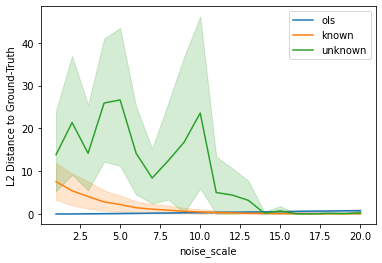

[Text(0.5, 0, 'noise_scale'), Text(0, 0.5, 'L1 Distance to Ground-Truth')]

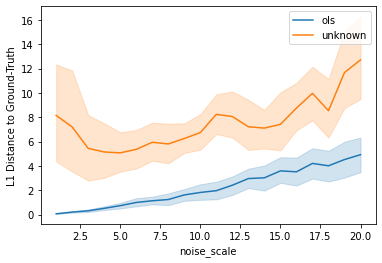

In [73]:
sns.lineplot(data=logs, x='noise_scale', y='ols_param_mse', label='ols')
# sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='noise_scale', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_scale', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

In [66]:
beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(d)

In [60]:
x_trunc.norm(dim=-1).max(), LA.norm(x_trunc, dim=-1, ord=2).max()

(tensor(203.6971), tensor(203.6971))

In [67]:
(x_trunc/beta).norm(dim=-1).max()

tensor(0.9110)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

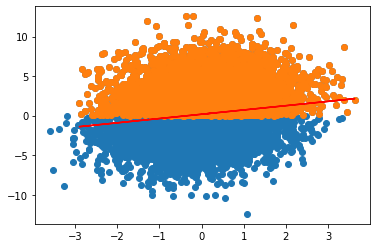

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])

In [6]:
test = ch.nn.Linear(in_features=1, out_features=1)

In [8]:
test.copy_()

ModuleAttributeError: 'Linear' object has no attribute 'copy_'

In [4]:
ch.ones(1).clone()

tensor([1.])

In [110]:
lst = [1, 2, 3]

In [111]:
other = lst 

In [112]:
other

[1, 2, 3]

In [113]:
lst = [4, 5, 6]

In [114]:
other

[1, 2, 3]

In [115]:
lst

[4, 5, 6]